In [11]:
!pip install getenv
!pip install psycopg2
!pip install geoalchemy2

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [12]:
# import the required packages
import pandas as pd
import geopandas as gpd
import getenv
import os
import psycopg2
import pandas as pd
import sqlalchemy
from shapely import wkt
import geoalchemy2
from ast import literal_eval # for unstring the string, e.g., '[1,2]' to [1,2]
import numpy as np
import math
import fiona

In [13]:
pd.set_option('display.max_columns', None)

### Modulation

this part of the analysis takes into account the first map with soil quality indices (notes), and checks whether or not the notes must be modified in the function of their surrounding environment or the additional soil layers (UNITE Carto and VITICOL), and also the slope.

so we use the layer "notes_layer", and we modify the notes taking into account the modulation table and the priority of modifying the notes. Here are layers where their notes will be modified:

1) a buffer of 3m around buildings 

2) a buffer of 3m around roads

3) a buffer of 10m around railways

4) the polygon intersecting with the layer soil unite carto and unite viticol

5) the slope

#### Modulation rules

Aprat from that there are some rules to apply the modulation:

1) if a polygon has intersection with two or more buffer zones, the modulation will be accumulated

2) besides the buffer layers where we always apply the modulation, the priority of other three layers for applying modulation is:

first: UNITE VITICOLE

second: UNITE CARTO

third: SLOPE

3) the notes for each soil quality index should not go below 1 or bigger than 6

##### Unite Carto

1) attribute "PROF_PHYSIOLOGIQUE_TXT" has priority over "PIERROSITE_TXT"

2) attribute "REGIME_HYDRIQUE_TXT" has priority over "TEXTURE_TXT"


##### Unite viticol

1) attribute "PROF_ENRACINEMENT_TXT" has priority over "HYDROMORPHIE_TXT"

In [17]:
conn = psycopg2.connect(
    host='datasource.regionmorges.ch',
    database='',
    user='',
    password='',
    options='')

In [18]:
conn2 = psycopg2.connect(
    host='datasource.regionmorges.ch',
    database='',
    user='',
    password='',
    options='')

In [19]:
# read table notes
sql = "SELECT * FROM iqs_notes_layer_v2"
notes_layer = gpd.GeoDataFrame.from_postgis(sql, conn, geom_col='geometry')

#### slope attribute in notes table

we have to add slope_mean as percentage (degree to percentage) and then based on the percentage ranges, define the attribute values as in the modulation table


In [20]:
for i, row in notes_layer.iterrows():
    slope_percent = np.round(np.tan(math.radians(row['slope_mean'])) * 100)
    if slope_percent<=5:
        notes_layer.at[i, 'slope_attribute'] = '< 5%'
    elif (slope_percent>5 and slope_percent <=10):
        notes_layer.at[i, 'slope_attribute'] = 'entre 5 et 10%'
    elif (slope_percent>10 and slope_percent <=15):
        notes_layer.at[i, 'slope_attribute'] = 'entre 10 et 15% compris'
    elif (slope_percent>15 and slope_percent <=18):
        notes_layer.at[i, 'slope_attribute'] = 'entre 15 et 18% compris'
    elif (slope_percent>18 and slope_percent <=30):
        notes_layer.at[i, 'slope_attribute'] = 'entre 18% et 30'
    elif slope_percent>30:
        notes_layer.at[i, 'slope_attribute'] = '> 30 %'
    

In [21]:
notes_layer['slope_attribute'].unique()

array(['< 5%', 'entre 5 et 10%', 'entre 10 et 15% compris',
       'entre 18% et 30', '> 30 %', 'entre 15 et 18% compris'],
      dtype=object)

In [22]:
# in this part we assign the layer id to the notes layer with the following definition:

# layer id 9 : the buffer 10m around the chemin de fer
# layer id 10: the buffer 3m around the chemin
# layer if 11: the buffer 3m around the batiment

# here I create a list of layer_ids for the three layers of three buffers
# when the polygon consists of building buffer and the road/railway buffer, then the modulation will be accumulated

for i, row in notes_layer.iterrows():
    list_layer_id=[]
    if row['buffer_dur']=='route, chemin':
        if (row['buffer_bat']==None and row['buffer_bat_sout']==None):
            list_layer_id=[10]
            notes_layer.at[i, 'buff_layer']= str(list_layer_id)
        else:
            list_layer_id=[10,11]
            notes_layer.at[i, 'buff_layer']= str(list_layer_id)
    elif row['buffer_dur']=='chemin de fer':
        if (row['buffer_bat']==None and row['buffer_bat_sout']==None):
            list_layer_id=[9]
            notes_layer.at[i, 'buff_layer']= str(list_layer_id)
        else:
            list_layer_id=[9,11]
            notes_layer.at[i, 'buff_layer']= str(list_layer_id)
    elif (row['buffer_bat']!=None or row['buffer_bat_sout']!=None):
        if row['buffer_dur']==None:
            list_layer_id=[11]
            notes_layer.at[i, 'buff_layer']= str(list_layer_id)

In [23]:
 # convert all NaN to None in the notes_layer table
notes_layer = notes_layer.replace(np.nan, None)

In [73]:
# fix soil layer attributes
notes_layer = notes_layer.replace('100 ? 180 cm', '100 – 180 cm')

In [74]:
notes_layer = notes_layer.replace('70 ? 100 cm', '70 – 100 cm')

### Start Modulation 

In [26]:
# read the modulation table from the db
# we filter the modulation table to exclude the id_couche=14 since this layer is Null and it is used for another part of the
# project which is the adjustment tool

query = """select * from modulation where id_couche !=14"""
modulation = pd.read_sql(query, conn2)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [27]:
# read the table attribut from the db
query = """select * from attribut"""
attribute = pd.read_sql(query, conn2)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [28]:
# merge attribute table and modualtion to get the attributes names in the modulation table
modulation = modulation.join(attribute.set_index('id_attribut'), on='id_attribut')

In [29]:
modulation

id_modulation  id_couche  id_attribut  \
0             110         15           16   
1               3         12            2   
2              50         13            7   
3              38         13            6   
4             105         15           15   
..            ...        ...          ...   
76             10         13            3   
77             11         13            3   
78             13         13            3   
79            119         13            6   
80            120          2            1   

                                               valeur  \
0   Excès d'eau temporaire visible à une profondeu...   
1                                                < 5%   
2              Limono-sableux à silto-limoneux (lsul)   
3                 Moraine rhodanienne de fond compact   
4                                           50 -70 cm   
..                                                ...   
76                       Assez superficiel (30-50 cm)   
77                     Moyennement profond (50-70 cm)   
78                             Très profond (>100 cm)   
79                       Moraine rhodanienne sableuse   
80                                Bâtiment souterrain   

                                    ordre_de_priorite comment  \
0                                                None    None   
1                                                None    None   
2                                                None    None   
3                                                None    None   
4   "profondeur enracinement txt" est prioritaire ...    None   
..                                                ...     ...   
76  "prof_physiologique" prioritaire sur "pierrosi...    None   
77  "prof_physiologique" prioritaire sur "pierrosi...    None   
78  "prof_physiologique" prioritaire sur "pierrosi...    None   
79                                               None    None   
80                                               None    None   

    perm_note_pourc  perm_fiab_pourc  prof_note_pourc  prof_note_abs  \
0               NaN              NaN            -40.0            NaN   
1               NaN              NaN              0.0            NaN   
2              10.0             20.0              NaN            NaN   
3               NaN              NaN              NaN            NaN   
4               NaN              NaN              NaN            4.0   
..              ...              ...              ...            ...   
76              NaN              NaN              NaN            3.0   
77              NaN              NaN              NaN            4.0   
78              NaN              NaN              NaN            6.0   
79              NaN              NaN              NaN            NaN   
80              NaN              NaN            -50.0            NaN   

    prof_fiab_pourc  prof_fiab_abs  poro_note_pourc  poro_fiab_pourc  \
0              20.0            NaN              NaN              NaN   
1              20.0            NaN              NaN              NaN   
2               NaN            NaN              NaN              NaN   
3               NaN            NaN            -20.0             20.0   
4               NaN            5.0              NaN              NaN   
..              ...            ...              ...              ...   
76              NaN            5.0              NaN              NaN   
77              NaN            5.0              NaN              NaN   
78              NaN            5.0              NaN              NaN   
79              NaN            NaN             20.0             20.0   
80             20.0            NaN            -50.0             20.0   

   mo_a_note_abs mo_a_fiab_abs  ph_note_abs  ph_fiab_abs pollution_message  \
0           None          None          NaN          NaN              None   
1           None          None          NaN          NaN              None   
2           None          None   

In [30]:
# convert all NaN to None in the modualtion table
modulation = modulation.replace(np.nan, None)

#### Steps to pereform modulation

1) take a row from the notes_layer 

2) check if the row includes buffer by checking the buff_layer column in notes_layer

3) if there is buffer check if the buffer includes only a layer or if it's an overlap of two buffers

4) if overlap of two buffers then sum the modulation values ( for example, a polygon is an overlap of building buffer and road buffer, and the perm_note for building_buffer (-50%) and the perm_note for road buffer (-50%) will multiply together and thus will be 0.5*0.5 = 0.25 >> so the new perm_note = old_perm_note + 0.25. So if the initial perm_notes was 6, then the modulated one will be 1.5

5) then we check soil priority >> viticol > carto > slope

6) then we check the layer priority if soil pr is either carto or viticol

7) we check the value >> if lowr than 1 >> then set as one and if bigger than 6 then set as 6

In [31]:
# a function to merge columns of abs and pourc in one single columns
def merge_col(df, old_col_1, old_col_2, new_col):
    for i, row in df.iterrows():
        if (row[old_col_1]!=None and row[old_col_2]==None):
            df.at[i, new_col] = row[old_col_1]
        elif (row[old_col_1]==None and row[old_col_2]!=None):
            df.at[i, new_col] = row[old_col_2]
        else:
            df.at[i, new_col] = None
    return df

In [32]:
modulation = merge_col(modulation, 'prof_note_pourc', 'prof_note_abs', 'prof_note')

In [33]:
modulation = merge_col(modulation, 'prof_fiab_pourc', 'prof_fiab_abs', 'prof_fiab')

In [34]:
modulation = merge_col(modulation, 'poro_note_pourc', 'poro_note_abs', 'poro_note')

In [35]:
modulation = merge_col(modulation, 'poro_fiab_pourc', 'poro_fiab_abs', 'poro_fiab')

In [36]:
modulation = merge_col(modulation, 'mo_a_note_pourc', 'mo_a_note_abs', 'mo_a_note')

In [37]:
modulation = merge_col(modulation, 'mo_a_fiab_pourc', 'mo_a_fiab_abs', 'mo_a_fiab')

In [38]:
modulation = modulation.drop(columns=['prof_note_pourc', 'prof_note_abs', 'prof_fiab_pourc', 'prof_fiab_abs',
       'poro_note_pourc', 'poro_fiab_pourc', 'mo_a_note_abs', 'mo_a_fiab_abs', 'mo_a_fiab_pourc',
       'mo_a_note_pourc', 'poro_note_abs', 'poro_fiab_abs'])

In [39]:
modulation.columns = ['id_modulation', 'id_couche', 'id_attribut', 'valeur',
       'ordre_de_priorite', 'comment', 'perm_note', 'perm_fiab',
       'ph_note', 'ph_fiab', 'pollution_message', 'attribut',
       'prof_note', 'prof_fiab', 'poro_note', 'poro_fiab', 'mo_a_note',
       'mo_a_fiab']

In [40]:
modulation

id_modulation  id_couche  id_attribut  \
0             110         15           16   
1               3         12            2   
2              50         13            7   
3              38         13            6   
4             105         15           15   
..            ...        ...          ...   
76             10         13            3   
77             11         13            3   
78             13         13            3   
79            119         13            6   
80            120          2            1   

                                               valeur  \
0   Excès d'eau temporaire visible à une profondeu...   
1                                                < 5%   
2              Limono-sableux à silto-limoneux (lsul)   
3                 Moraine rhodanienne de fond compact   
4                                           50 -70 cm   
..                                                ...   
76                       Assez superficiel (30-50 cm)   
77                     Moyennement profond (50-70 cm)   
78                             Très profond (>100 cm)   
79                       Moraine rhodanienne sableuse   
80                                Bâtiment souterrain   

                                    ordre_de_priorite comment perm_note  \
0                                                None    None      None   
1                                                None    None      None   
2                                                None    None      10.0   
3                                                None    None      None   
4   "profondeur enracinement txt" est prioritaire ...    None      None   
..                                                ...     ...       ...   
76  "prof_physiologique" prioritaire sur "pierrosi...    None      None   
77  "prof_physiologique" prioritaire sur "pierrosi...    None      None   
78  "prof_physiologique" prioritaire sur "pierrosi...    None      None   
79                                               None    None      None   
80                                               None    None      None   

   perm_fiab ph_note ph_fiab pollution_message  \
0       None    None    None              None   
1       None    None    None              None   
2       20.0    None    None              None   
3       None    None    None              None   
4       None    None    None              None   
..       ...     ...     ...               ...   
76      None    None    None              None   
77      None    None    None              None   
78      None    None    None              None   
79      None    None    None              None   
80      None    None    None              None   

                                  attribut  prof_note  prof_fiab  poro_note  \
0                         HYDROMORPHIE_TXT      -40.0       20.0        NaN   
1   pente ( calculer moyenne par polygone)        0.0       20.0        NaN   
2                              TEXTURE_TXT        NaN        NaN        NaN   
3                       ROCHE_MERE_SUP_TXT        NaN        NaN      -20.0   
4                    PROF_ENRACINEMENT_TXT        4.0        5.0        NaN   
..                                     ...        ...        ...        ...   
76                  PROF_PHYSIOLOGIQUE_TXT        3.0        5.0        NaN   
77                  PROF_PHYSIOLOGIQUE_TXT        4.0        5.0        NaN   
78                  PROF_PHYSIOLOGIQUE_TXT        6.0        5.0        NaN   
79                      ROCHE_MERE_SUP_TXT        NaN        NaN       20.0   
80                                    None      -50.0       20.0      -50.0   

    poro_fiab  mo_a_note  mo_a_fiab  
0         NaN        NaN        NaN  
1         NaN        NaN        NaN  
2         NaN        NaN        NaN  
3        20.0        NaN        NaN  
4         NaN        NaN        NaN  
..        ...        ...        ...  
76        NaN        NaN        NaN  
77        NaN        Na

In [41]:
# convert all NaN to None in the modualtion table
modulation = modulation.replace(np.nan, None)

In [42]:
# add soil priority to the modulation table

for i, row in modulation.iterrows():
    if row['id_couche']==15:
        modulation.at[i, 'priority_soil']=1
    elif row['id_couche']==13:
        modulation.at[i, 'priority_soil']=2
    elif row['id_couche']==12:
        modulation.at[i, 'priority_soil']=3
        

#### Modulation functions

There are 4 funtions that are defined bellow, but there are two principle functions, and two sub-functions

1) get_soil_modulation_val

1.1) unite_carto

1.2) unite_viticol

2) get_buff_modulation_val




In [81]:
# notes_row: the row in the base map (notes_layer) that we want to modulate the soil indices
# soil index: the index we want to modulate
# df: the modulation table
def unite_carto(df_filtered, priority, notes_row):
    df_p = df_filtered[df_filtered['priority_soil']==priority]
    attributes = df_p['attribut'].unique().tolist()
    if len(attributes)>1:
        if all(elem in attributes for elem in ['PROF_PHYSIOLOGIQUE_TXT', 'PIERROSITE_TXT']):
            val = notes_row['carto_prof_physiologique_txt']
        elif all(elem in attributes for elem in ['REGIME_HYDRIQUE_TXT', 'TEXTURE_TXT']):
            val = notes_row['carto_regime_hydrique_txt']
                
    else:
        val = notes_row['carto_'+attributes[0].lower()]
            ## if there is no value for carto then use slope
           
    if (val == None or val=='Non sondé' or val=='Non déterminé'):
        priority=3
        val = notes_row['slope_attribute']
    #print(val)
    return val

def unite_viticol(df_filtered, priority, notes_row):
    df_p = df_filtered[df_filtered['priority_soil']==priority]
    attributes = df_p['attribut'].unique().tolist()
    #print(attributes)
        
    if len(attributes) > 1:
        # attribute "PROF_ENRACINEMENT_TXT" has priority over "HYDROMORPHIE_TXT"
        val = notes_row['viticol_prof_enracinement_txt']
        #print(val)
    else:
        val = notes_row['viticol_'+attributes[0].lower()]
        ## test to see if code works , then I will optimize the code
    if val == None:
        #print("here")
        new_unique_pr = [n for n in df_filtered['priority_soil'].unique().tolist() if n != 1]
        priority = min(new_unique_pr)
        if priority == 2:
            val = unite_carto(df_filtered, priority, notes_row)
        else:
            val = notes_row['slope_attribute']
    #print(val)
    return val

def get_soil_modulation_val(df_mod, soil_index, notes_row):
    # filter the df for the three layers of carto, viticol , and slope
    df = df_mod[~df_mod['priority_soil'].isnull()]
    # filter the df for particlar soil_index where the values are not null
    df = df[~df[soil_index].isnull()]
    
    priority = min(df['priority_soil'].unique())
    #print(priority)
    #attributes = df['attribut'].unique()
    #print(attributes)
    if priority == 1:
        val = unite_viticol(df, priority, notes_row)
              
    elif priority == 2:
        val = unite_carto(df, priority, notes_row)
        
    else:
        val = notes_row['slope_attribute']
            
    
    soil_mod_prm = df_mod.loc[df_mod['valeur'] == val, soil_index].iloc[0] 
    if soil_mod_prm ==None:
        soil_mod_prm = 0
    
    return (soil_mod_prm,priority)

In [82]:
def get_buff_modulation_val(df,soil_index, notes_row):
    buff = literal_eval(notes_row['buff_layer'])
    if len(buff)==1:
        buff_mod_prm = df.loc[df['id_couche'] == buff[0], soil_index].iloc[0]
        if buff_mod_prm == None:
            buff_mod_prm = 0
        buff_mod_prm = 1 + buff_mod_prm/100
    else:
        buff_mod_prm_1 = df.loc[df['id_couche'] == buff[0], soil_index].iloc[0]
        buff_mod_prm_2 = df.loc[df['id_couche'] == buff[1], soil_index].iloc[0]
        if buff_mod_prm_1 == None:
            buff_mod_prm_1 = 0
        if buff_mod_prm_2 == None:
            buff_mod_prm_2 = 0
        buff_mod_prm = (1 + buff_mod_prm_1/100)*(1 + buff_mod_prm_2/100)
    
    return buff_mod_prm
        

In [83]:
# a copy of notes_layer and modualte the indices int he copied one
notes_modulated = notes_layer.copy()

In [84]:
# now modulate the notes

# list of params to be modulated 
indices = ['perm_note', 'perm_fiab','prof_note','prof_fiab', 'poro_note', 'poro_fiab','mo_a_note', 'mo_a_fiab', 'ph_note', 'ph_fiab']

for i, row in notes_modulated.iterrows():
    if row['mod']:
    #print(i)
        for item in indices:
            #print(item)
            new_note = -1
            if row[item]!=None:
                soil_mod,priority = get_soil_modulation_val(modulation, item, row)
        
                if row['buff_layer']!=None:
                    buff_mod = get_buff_modulation_val(modulation, item, row)
        
                    if (soil_mod in range(1, 7, 1) and priority<3):
                        new_note = soil_mod * buff_mod
                    
                    else:
                        new_note = row[item]* (1 + soil_mod/100) * buff_mod
                else:
                    
                    if (soil_mod in range(1, 7, 1) and priority<3):
                        new_note = soil_mod
                        
                    else:
                        new_note = row[item]* (1 + soil_mod/100)
                    

                if new_note!= -1:
                    if new_note < 1:
                        new_note = 1
                    elif new_note > 6:
                        new_note = 6
    
                    notes_modulated.at[i,item] = round(new_note, 2)
        
        print(i,' :done')
            
        
    

11680  :done
11684  :done
11685  :done
11686  :done
11687  :done
11688  :done
11689  :done
11695  :done
11699  :done
11700  :done
11701  :done
11702  :done
11706  :done
11707  :done
11708  :done
11712  :done
11715  :done
11722  :done
11744  :done
11754  :done
11767  :done
11775  :done
11776  :done
11777  :done
11778  :done
11779  :done
11780  :done
11781  :done
11782  :done
11783  :done
11784  :done
11793  :done
11794  :done
11797  :done
11801  :done
11803  :done
11811  :done
11814  :done
11820  :done
11824  :done
11834  :done
11838  :done
11845  :done
11849  :done
11877  :done
11888  :done
11890  :done
11893  :done
11909  :done
11911  :done
11918  :done
11951  :done
11959  :done
11961  :done
11971  :done
11974  :done
11994  :done
12003  :done
12004  :done
12005  :done
12013  :done
12041  :done
12091  :done
12105  :done
12106  :done
12107  :done
12121  :done
12140  :done
12143  :done
12144  :done
12147  :done
12151  :done
12157  :done
12163  :done
12166  :done
12174  :done
12175  :done

16093  :done
16099  :done
16100  :done
16110  :done
16112  :done
16113  :done
16128  :done
16129  :done
16131  :done
16133  :done
16141  :done
16142  :done
16143  :done
16146  :done
16154  :done
16157  :done
16158  :done
16161  :done
16164  :done
16165  :done
16166  :done
16167  :done
16172  :done
16179  :done
16186  :done
16189  :done
16197  :done
16199  :done
16209  :done
16212  :done
16223  :done
16224  :done
16227  :done
16232  :done
16243  :done
16252  :done
16256  :done
16265  :done
16268  :done
16274  :done
16288  :done
16290  :done
16296  :done
16303  :done
16312  :done
16314  :done
16316  :done
16318  :done
16325  :done
16331  :done
16335  :done
16336  :done
16341  :done
16347  :done
16362  :done
16363  :done
16364  :done
16383  :done
16399  :done
16401  :done
16402  :done
16406  :done
16407  :done
16410  :done
16411  :done
16437  :done
16438  :done
16455  :done
16456  :done
16459  :done
16476  :done
16482  :done
16492  :done
16517  :done
16532  :done
16542  :done
16572  :done

21084  :done
21095  :done
21103  :done
21131  :done
21132  :done
21144  :done
21150  :done
21152  :done
21166  :done
21167  :done
21171  :done
21176  :done
21179  :done
21185  :done
21201  :done
21230  :done
21242  :done
21257  :done
21259  :done
21267  :done
21268  :done
21271  :done
21291  :done
21296  :done
21307  :done
21308  :done
21309  :done
21310  :done
21316  :done
21320  :done
21321  :done
21327  :done
21338  :done
21349  :done
21364  :done
21370  :done
21380  :done
21382  :done
21390  :done
21394  :done
21400  :done
21403  :done
21409  :done
21416  :done
21418  :done
21419  :done
21423  :done
21431  :done
21432  :done
21438  :done
21444  :done
21445  :done
21476  :done
21480  :done
21481  :done
21497  :done
21500  :done
21508  :done
21512  :done
21520  :done
21526  :done
21536  :done
21556  :done
21588  :done
21589  :done
21593  :done
21609  :done
21618  :done
21628  :done
21650  :done
21654  :done
21657  :done
21659  :done
21673  :done
21691  :done
21695  :done
21707  :done

22857  :done
22858  :done
22859  :done
22860  :done
22861  :done
22862  :done
22863  :done
22864  :done
22865  :done
22866  :done
22867  :done
22868  :done
22869  :done
22870  :done
22871  :done
22872  :done
22873  :done
22874  :done
22875  :done
22876  :done
22877  :done
22878  :done
22879  :done
22880  :done
22881  :done
22882  :done
22883  :done
22884  :done
22885  :done
22886  :done
22887  :done
22888  :done
22889  :done
22890  :done
22891  :done
22892  :done
22893  :done
22894  :done
22895  :done
22896  :done
22897  :done
22898  :done
22899  :done
22900  :done
22901  :done
22902  :done
22903  :done
22904  :done
22905  :done
22906  :done
22907  :done
22908  :done
22909  :done
22910  :done
22911  :done
22912  :done
22913  :done
22914  :done
22915  :done
22916  :done
22917  :done
22918  :done
22919  :done
22920  :done
22921  :done
22922  :done
22923  :done
22924  :done
22925  :done
22926  :done
22927  :done
22928  :done
22929  :done
22930  :done
22931  :done
22932  :done
22933  :done

23490  :done
23491  :done
23492  :done
23493  :done
23494  :done
23495  :done
23496  :done
23497  :done
23498  :done
23499  :done
23500  :done
23501  :done
23502  :done
23503  :done
23504  :done
23505  :done
23506  :done
23507  :done
23508  :done
23509  :done
23510  :done
23511  :done
23512  :done
23513  :done
23514  :done
23515  :done
23516  :done
23517  :done
23518  :done
23519  :done
23520  :done
23521  :done
23522  :done
23523  :done
23524  :done
23525  :done
23526  :done
23527  :done
23528  :done
23529  :done
23530  :done
23531  :done
23532  :done
23533  :done
23534  :done
23535  :done
23536  :done
23537  :done
23538  :done
23539  :done
23540  :done
23541  :done
23542  :done
23543  :done
23544  :done
23545  :done
23546  :done
23547  :done
23548  :done
23549  :done
23550  :done
23551  :done
23552  :done
23553  :done
23554  :done
23555  :done
23556  :done
23557  :done
23558  :done
23559  :done
23560  :done
23561  :done
23562  :done
23563  :done
23564  :done
23565  :done
23566  :done

24125  :done
24126  :done
24127  :done
24128  :done
24129  :done
24130  :done
24131  :done
24132  :done
24133  :done
24134  :done
24135  :done
24136  :done
24137  :done
24138  :done
24139  :done
24140  :done
24141  :done
24142  :done
24143  :done
24144  :done
24145  :done
24146  :done
24147  :done
24148  :done
24149  :done
24150  :done
24151  :done
24152  :done
24153  :done
24154  :done
24155  :done
24156  :done
24157  :done
24158  :done
24159  :done
24160  :done
24161  :done
24162  :done
24163  :done
24164  :done
24165  :done
24166  :done
24167  :done
24168  :done
24169  :done
24170  :done
24171  :done
24172  :done
24173  :done
24174  :done
24175  :done
24176  :done
24177  :done
24178  :done
24179  :done
24180  :done
24181  :done
24182  :done
24183  :done
24184  :done
24185  :done
24186  :done
24187  :done
24188  :done
24189  :done
24190  :done
24191  :done
24192  :done
24193  :done
24194  :done
24195  :done
24196  :done
24197  :done
24198  :done
24199  :done
24200  :done
24201  :done

24772  :done
24773  :done
24774  :done
24775  :done
24776  :done
24777  :done
24778  :done
24779  :done
24780  :done
24781  :done
24782  :done
24783  :done
24784  :done
24785  :done
24786  :done
24787  :done
24788  :done
24789  :done
24790  :done
24791  :done
24792  :done
24793  :done
24794  :done
24795  :done
24796  :done
24797  :done
24798  :done
24799  :done
24800  :done
24801  :done
24802  :done
24803  :done
24804  :done
24805  :done
24806  :done
24807  :done
24808  :done
24809  :done
24810  :done
24811  :done
24812  :done
24813  :done
24814  :done
24815  :done
24816  :done
24817  :done
24818  :done
24819  :done
24820  :done
24821  :done
24822  :done
24823  :done
24824  :done
24825  :done
24826  :done
24827  :done
24828  :done
24829  :done
24830  :done
24831  :done
24832  :done
24833  :done
24834  :done
24835  :done
24836  :done
24837  :done
24838  :done
24839  :done
24840  :done
24841  :done
24842  :done
24843  :done
24844  :done
24845  :done
24846  :done
24847  :done
24848  :done

25415  :done
25416  :done
25417  :done
25418  :done
25419  :done
25420  :done
25421  :done
25422  :done
25423  :done
25424  :done
25425  :done
25426  :done
25427  :done
25428  :done
25429  :done
25430  :done
25431  :done
25432  :done
25433  :done
25434  :done
25435  :done
25436  :done
25437  :done
25438  :done
25439  :done
25440  :done
25441  :done
25442  :done
25443  :done
25444  :done
25445  :done
25446  :done
25447  :done
25448  :done
25449  :done
25450  :done
25451  :done
25452  :done
25453  :done
25454  :done
25455  :done
25456  :done
25457  :done
25458  :done
25459  :done
25460  :done
25461  :done
25462  :done
25463  :done
25464  :done
25465  :done
25466  :done
25467  :done
25468  :done
25469  :done
25470  :done
25471  :done
25472  :done
25473  :done
25474  :done
25475  :done
25476  :done
25477  :done
25478  :done
25479  :done
25480  :done
25481  :done
25482  :done
25483  :done
25484  :done
25485  :done
25486  :done
25487  :done
25488  :done
25489  :done
25490  :done
25491  :done

26054  :done
26055  :done
26056  :done
26057  :done
26058  :done
26059  :done
26060  :done
26061  :done
26062  :done
26063  :done
26064  :done
26065  :done
26066  :done
26067  :done
26068  :done
26069  :done
26070  :done
26071  :done
26072  :done
26073  :done
26074  :done
26075  :done
26076  :done
26077  :done
26078  :done
26079  :done
26080  :done
26081  :done
26082  :done
26083  :done
26084  :done
26085  :done
26086  :done
26087  :done
26088  :done
26089  :done
26090  :done
26091  :done
26092  :done
26093  :done
26094  :done
26095  :done
26096  :done
26097  :done
26098  :done
26099  :done
26100  :done
26101  :done
26102  :done
26103  :done
26104  :done
26105  :done
26106  :done
26107  :done
26108  :done
26109  :done
26110  :done
26111  :done
26112  :done
26113  :done
26114  :done
26115  :done
26116  :done
26117  :done
26118  :done
26119  :done
26120  :done
26121  :done
26122  :done
26123  :done
26124  :done
26125  :done
26126  :done
26127  :done
26128  :done
26129  :done
26130  :done

26694  :done
26695  :done
26696  :done
26697  :done
26698  :done
26699  :done
26700  :done
26701  :done
26702  :done
26703  :done
26704  :done
26705  :done
26706  :done
26707  :done
26708  :done
26709  :done
26710  :done
26711  :done
26712  :done
26713  :done
26714  :done
26715  :done
26716  :done
26717  :done
26718  :done
26719  :done
26720  :done
26721  :done
26722  :done
26723  :done
26724  :done
26725  :done
26726  :done
26727  :done
26728  :done
26729  :done
26730  :done
26731  :done
26732  :done
26733  :done
26734  :done
26735  :done
26736  :done
26737  :done
26738  :done
26739  :done
26740  :done
26741  :done
26742  :done
26743  :done
26744  :done
26745  :done
26746  :done
26747  :done
26748  :done
26749  :done
26750  :done
26751  :done
26752  :done
26753  :done
26754  :done
26755  :done
26756  :done
26757  :done
26758  :done
26759  :done
26760  :done
26761  :done
26762  :done
26763  :done
26764  :done
26765  :done
26766  :done
26767  :done
26768  :done
26769  :done
26770  :done

27333  :done
27334  :done
27335  :done
27336  :done
27337  :done
27338  :done
27339  :done
27340  :done
27341  :done
27342  :done
27343  :done
27344  :done
27345  :done
27346  :done
27347  :done
27348  :done
27349  :done
27350  :done
27351  :done
27352  :done
27353  :done
27354  :done
27355  :done
27356  :done
27357  :done
27358  :done
27359  :done
27360  :done
27361  :done
27362  :done
27363  :done
27364  :done
27365  :done
27366  :done
27367  :done
27368  :done
27369  :done
27370  :done
27371  :done
27372  :done
27373  :done
27374  :done
27375  :done
27376  :done
27377  :done
27378  :done
27379  :done
27380  :done
27381  :done
27382  :done
27383  :done
27384  :done
27385  :done
27386  :done
27387  :done
27388  :done
27389  :done
27390  :done
27391  :done
27392  :done
27393  :done
27394  :done
27395  :done
27396  :done
27397  :done
27398  :done
27399  :done
27400  :done
27401  :done
27402  :done
27403  :done
27404  :done
27405  :done
27406  :done
27407  :done
27408  :done
27409  :done

27968  :done
27969  :done
27970  :done
27971  :done
27972  :done
27973  :done
27974  :done
27975  :done
27976  :done
27977  :done
27978  :done
27979  :done
27980  :done
27981  :done
27982  :done
27983  :done
27984  :done
27985  :done
27986  :done
27987  :done
27988  :done
27989  :done
27990  :done
27991  :done
27992  :done
27993  :done
27994  :done
27995  :done
27996  :done
27997  :done
27998  :done
27999  :done
28000  :done
28001  :done
28002  :done
28003  :done
28004  :done
28005  :done
28006  :done
28007  :done
28008  :done
28009  :done
28010  :done
28011  :done
28012  :done
28013  :done
28014  :done
28015  :done
28016  :done
28017  :done
28018  :done
28019  :done
28020  :done
28021  :done
28022  :done
28023  :done
28024  :done
28025  :done
28026  :done
28027  :done
28028  :done
28029  :done
28030  :done
28031  :done
28032  :done
28033  :done
28034  :done
28035  :done
28036  :done
28037  :done
28038  :done
28039  :done
28040  :done
28041  :done
28042  :done
28043  :done
28044  :done

28602  :done
28603  :done
28604  :done
28605  :done
28606  :done
28607  :done
28608  :done
28609  :done
28610  :done
28611  :done
28612  :done
28613  :done
28614  :done
28615  :done
28616  :done
28617  :done
28618  :done
28619  :done
28620  :done
28621  :done
28622  :done
28623  :done
28624  :done
28625  :done
28626  :done
28627  :done
28628  :done
28629  :done
28630  :done
28631  :done
28632  :done
28633  :done
28634  :done
28635  :done
28636  :done
28637  :done
28638  :done
28639  :done
28640  :done
28641  :done
28642  :done
28643  :done
28644  :done
28645  :done
28646  :done
28647  :done
28648  :done
28649  :done
28650  :done
28651  :done
28652  :done
28653  :done
28654  :done
28655  :done
28656  :done
28657  :done
28658  :done
28659  :done
28660  :done
28661  :done
28662  :done
28663  :done
28664  :done
28665  :done
28666  :done
28667  :done
28668  :done
28669  :done
28670  :done
28671  :done
28672  :done
28673  :done
28674  :done
28675  :done
28676  :done
28677  :done
28678  :done

29249  :done
29250  :done
29251  :done
29252  :done
29253  :done
29254  :done
29255  :done
29256  :done
29257  :done
29258  :done
29259  :done
29260  :done
29261  :done
29262  :done
29263  :done
29264  :done
29265  :done
29266  :done
29267  :done
29268  :done
29269  :done
29270  :done
29271  :done
29272  :done
29273  :done
29274  :done
29275  :done
29276  :done
29277  :done
29278  :done
29279  :done
29280  :done
29281  :done
29282  :done
29283  :done
29284  :done
29285  :done
29286  :done
29287  :done
29288  :done
29289  :done
29290  :done
29291  :done
29292  :done
29293  :done
29294  :done
29295  :done
29296  :done
29297  :done
29298  :done
29299  :done
29300  :done
29301  :done
29302  :done
29303  :done
29304  :done
29305  :done
29306  :done
29307  :done
29308  :done
29309  :done
29310  :done
29311  :done
29312  :done
29313  :done
29314  :done
29315  :done
29316  :done
29317  :done
29318  :done
29319  :done
29320  :done
29321  :done
29322  :done
29323  :done
29324  :done
29325  :done

29886  :done
29887  :done
29888  :done
29889  :done
29890  :done
29891  :done
29892  :done
29893  :done
29894  :done
29895  :done
29896  :done
29897  :done
29898  :done
29899  :done
29900  :done
29901  :done
29902  :done
29903  :done
29904  :done
29905  :done
29906  :done
29907  :done
29908  :done
29909  :done
29910  :done
29911  :done
29912  :done
29913  :done
29914  :done
29915  :done
29916  :done
29917  :done
29918  :done
29919  :done
29920  :done
29921  :done
29922  :done
29923  :done
29924  :done
29925  :done
29926  :done
29927  :done
29928  :done
29929  :done
29930  :done
29931  :done
29932  :done
29933  :done
29934  :done
29935  :done
29936  :done
29937  :done
29938  :done
29939  :done
29940  :done
29941  :done
29942  :done
29943  :done
29944  :done
29945  :done
29946  :done
29947  :done
29948  :done
29949  :done
29950  :done
29951  :done
29952  :done
29953  :done
29954  :done
29955  :done
29956  :done
29957  :done
29958  :done
29959  :done
29960  :done
29961  :done
29962  :done

30521  :done
30522  :done
30523  :done
30524  :done
30525  :done
30526  :done
30527  :done
30528  :done
30529  :done
30530  :done
30531  :done
30532  :done
30533  :done
30534  :done
30535  :done
30536  :done
30537  :done
30538  :done
30539  :done
30540  :done
30541  :done
30542  :done
30543  :done
30544  :done
30545  :done
30546  :done
30547  :done
30548  :done
30549  :done
30550  :done
30551  :done
30552  :done
30553  :done
30554  :done
30555  :done
30556  :done
30557  :done
30558  :done
30559  :done
30560  :done
30561  :done
30562  :done
30563  :done
30564  :done
30565  :done
30566  :done
30567  :done
30568  :done
30569  :done
30570  :done
30571  :done
30572  :done
30573  :done
30574  :done
30575  :done
30576  :done
30577  :done
30578  :done
30579  :done
30580  :done
30581  :done
30582  :done
30583  :done
30584  :done
30585  :done
30586  :done
30587  :done
30588  :done
30589  :done
30590  :done
30591  :done
30592  :done
30593  :done
30594  :done
30595  :done
30596  :done
30597  :done

31153  :done
31154  :done
31155  :done
31156  :done
31157  :done
31158  :done
31159  :done
31160  :done
31161  :done
31162  :done
31163  :done
31164  :done
31165  :done
31166  :done
31167  :done
31168  :done
31169  :done
31170  :done
31171  :done
31172  :done
31173  :done
31174  :done
31175  :done
31176  :done
31177  :done
31178  :done
31179  :done
31180  :done
31181  :done
31182  :done
31183  :done
31184  :done
31185  :done
31186  :done
31187  :done
31188  :done
31189  :done
31190  :done
31191  :done
31192  :done
31193  :done
31194  :done
31195  :done
31196  :done
31197  :done
31198  :done
31199  :done
31200  :done
31201  :done
31202  :done
31203  :done
31204  :done
31205  :done
31206  :done
31207  :done
31208  :done
31209  :done
31210  :done
31211  :done
31212  :done
31213  :done
31214  :done
31215  :done
31216  :done
31217  :done
31218  :done
31219  :done
31220  :done
31221  :done
31222  :done
31223  :done
31224  :done
31225  :done
31226  :done
31227  :done
31228  :done
31229  :done

31797  :done
31798  :done
31799  :done
31800  :done
31801  :done
31802  :done
31803  :done
31804  :done
31805  :done
31806  :done
31807  :done
31808  :done
31809  :done
31810  :done
31811  :done
31812  :done
31813  :done
31814  :done
31815  :done
31816  :done
31817  :done
31818  :done
31819  :done
31820  :done
31821  :done
31822  :done
31823  :done
31824  :done
31825  :done
31826  :done
31827  :done
31828  :done
31829  :done
31830  :done
31831  :done
31832  :done
31833  :done
31834  :done
31835  :done
31836  :done
31837  :done
31838  :done
31839  :done
31840  :done
31841  :done
31842  :done
31843  :done
31844  :done
31845  :done
31846  :done
31847  :done
31848  :done
31849  :done
31850  :done
31851  :done
31852  :done
31853  :done
31854  :done
31855  :done
31856  :done
31857  :done
31858  :done
31859  :done
31860  :done
31861  :done
31862  :done
31863  :done
31864  :done
31865  :done
31866  :done
31867  :done
31868  :done
31869  :done
31870  :done
31871  :done
31872  :done
31873  :done

32438  :done
32439  :done
32440  :done
32441  :done
32442  :done
32443  :done
32444  :done
32445  :done
32446  :done
32447  :done
32448  :done
32449  :done
32450  :done
32451  :done
32452  :done
32453  :done
32454  :done
32455  :done
32456  :done
32457  :done
32458  :done
32459  :done
32460  :done
32461  :done
32462  :done
32463  :done
32464  :done
32465  :done
32466  :done
32467  :done
32468  :done
32469  :done
32470  :done
32471  :done
32472  :done
32473  :done
32474  :done
32475  :done
32476  :done
32477  :done
32478  :done
32479  :done
32480  :done
32481  :done
32482  :done
32483  :done
32484  :done
32485  :done
32486  :done
32487  :done
32488  :done
32489  :done
32490  :done
32491  :done
32492  :done
32493  :done
32494  :done
32495  :done
32496  :done
32497  :done
32498  :done
32499  :done
32500  :done
32501  :done
32502  :done
32503  :done
32504  :done
32505  :done
32506  :done
32507  :done
32508  :done
32509  :done
32510  :done
32511  :done
32512  :done
32513  :done
32514  :done

33085  :done
33086  :done
33087  :done
33088  :done
33089  :done
33090  :done
33091  :done
33092  :done
33093  :done
33094  :done
33095  :done
33096  :done
33097  :done
33098  :done
33099  :done
33100  :done
33101  :done
33102  :done
33103  :done
33104  :done
33105  :done
33106  :done
33107  :done
33108  :done
33109  :done
33110  :done
33111  :done
33112  :done
33113  :done
33114  :done
33115  :done
33116  :done
33117  :done
33118  :done
33119  :done
33120  :done
33121  :done
33122  :done
33123  :done
33125  :done
33126  :done
33127  :done
33128  :done
33129  :done
33131  :done
33132  :done
33133  :done
33134  :done
33135  :done
33136  :done
33137  :done
33138  :done
33139  :done
33140  :done
33141  :done
33142  :done
33143  :done
33144  :done
33145  :done
33146  :done
33147  :done
33148  :done
33149  :done
33150  :done
33151  :done
33152  :done
33153  :done
33154  :done
33155  :done
33156  :done
33157  :done
33158  :done
33159  :done
33160  :done
33161  :done
33162  :done
33163  :done

33748  :done
33749  :done
33750  :done
33751  :done
33752  :done
33753  :done
33754  :done
33755  :done
33756  :done
33757  :done
33758  :done
33759  :done
33760  :done
33761  :done
33762  :done
33763  :done
33764  :done
33765  :done
33766  :done
33767  :done
33768  :done
33769  :done
33770  :done
33771  :done
33772  :done
33773  :done
33774  :done
33775  :done
33776  :done
33777  :done
33778  :done
33779  :done
33780  :done
33781  :done
33782  :done
33783  :done
33784  :done
33785  :done
33786  :done
33787  :done
33788  :done
33789  :done
33790  :done
33791  :done
33792  :done
33793  :done
33794  :done
33798  :done
33799  :done
33800  :done
33803  :done
33805  :done
33806  :done
33807  :done
33808  :done
33809  :done
33810  :done
33811  :done
33812  :done
33813  :done
33814  :done
33815  :done
33816  :done
33817  :done
33818  :done
33819  :done
33820  :done
33821  :done
33822  :done
33823  :done
33824  :done
33825  :done
33826  :done
33827  :done
33828  :done
33829  :done
33830  :done

34410  :done
34411  :done
34412  :done
34413  :done
34414  :done
34415  :done
34416  :done
34417  :done
34418  :done
34419  :done
34420  :done
34421  :done
34422  :done
34423  :done
34424  :done
34425  :done
34426  :done
34427  :done
34428  :done
34429  :done
34430  :done
34431  :done
34432  :done
34433  :done
34435  :done
34436  :done
34437  :done
34438  :done
34439  :done
34440  :done
34441  :done
34442  :done
34443  :done
34445  :done
34446  :done
34447  :done
34448  :done
34449  :done
34450  :done
34451  :done
34452  :done
34453  :done
34454  :done
34455  :done
34456  :done
34457  :done
34458  :done
34459  :done
34460  :done
34461  :done
34462  :done
34463  :done
34465  :done
34466  :done
34467  :done
34469  :done
34470  :done
34471  :done
34472  :done
34473  :done
34474  :done
34475  :done
34476  :done
34477  :done
34478  :done
34479  :done
34480  :done
34481  :done
34482  :done
34483  :done
34484  :done
34485  :done
34486  :done
34487  :done
34488  :done
34489  :done
34490  :done

35103  :done
35104  :done
35105  :done
35106  :done
35107  :done
35108  :done
35109  :done
35110  :done
35111  :done
35112  :done
35113  :done
35114  :done
35115  :done
35116  :done
35117  :done
35118  :done
35119  :done
35120  :done
35121  :done
35122  :done
35123  :done
35124  :done
35125  :done
35126  :done
35127  :done
35128  :done
35129  :done
35130  :done
35131  :done
35132  :done
35133  :done
35134  :done
35135  :done
35136  :done
35137  :done
35138  :done
35139  :done
35140  :done
35141  :done
35142  :done
35143  :done
35144  :done
35145  :done
35146  :done
35147  :done
35148  :done
35149  :done
35150  :done
35151  :done
35152  :done
35153  :done
35154  :done
35155  :done
35156  :done
35157  :done
35158  :done
35159  :done
35160  :done
35161  :done
35162  :done
35163  :done
35164  :done
35165  :done
35166  :done
35167  :done
35168  :done
35169  :done
35170  :done
35171  :done
35172  :done
35173  :done
35174  :done
35176  :done
35177  :done
35178  :done
35179  :done
35180  :done

35781  :done
35785  :done
35787  :done
35788  :done
35789  :done
35790  :done
35791  :done
35792  :done
35793  :done
35794  :done
35795  :done
35796  :done
35797  :done
35798  :done
35799  :done
35800  :done
35801  :done
35803  :done
35806  :done
35808  :done
35809  :done
35810  :done
35811  :done
35812  :done
35813  :done
35814  :done
35815  :done
35816  :done
35817  :done
35818  :done
35819  :done
35820  :done
35821  :done
35822  :done
35823  :done
35824  :done
35826  :done
35827  :done
35829  :done
35831  :done
35832  :done
35833  :done
35834  :done
35835  :done
35837  :done
35838  :done
35839  :done
35840  :done
35841  :done
35842  :done
35843  :done
35844  :done
35845  :done
35847  :done
35848  :done
35849  :done
35850  :done
35853  :done
35854  :done
35855  :done
35856  :done
35857  :done
35858  :done
35859  :done
35860  :done
35863  :done
35864  :done
35866  :done
35867  :done
35868  :done
35870  :done
35871  :done
35872  :done
35873  :done
35874  :done
35875  :done
35876  :done

36523  :done
36524  :done
36525  :done
36526  :done
36527  :done
36528  :done
36529  :done
36530  :done
36531  :done
36532  :done
36533  :done
36534  :done
36535  :done
36536  :done
36537  :done
36538  :done
36539  :done
36540  :done
36541  :done
36542  :done
36543  :done
36544  :done
36545  :done
36546  :done
36547  :done
36548  :done
36549  :done
36550  :done
36551  :done
36553  :done
36554  :done
36555  :done
36556  :done
36557  :done
36558  :done
36559  :done
36560  :done
36561  :done
36562  :done
36563  :done
36564  :done
36565  :done
36566  :done
36567  :done
36568  :done
36569  :done
36570  :done
36571  :done
36572  :done
36573  :done
36574  :done
36575  :done
36576  :done
36577  :done
36578  :done
36579  :done
36580  :done
36581  :done
36582  :done
36583  :done
36584  :done
36585  :done
36586  :done
36587  :done
36588  :done
36589  :done
36590  :done
36591  :done
36592  :done
36593  :done
36594  :done
36595  :done
36596  :done
36597  :done
36598  :done
36599  :done
36600  :done

37167  :done
37168  :done
37169  :done
37170  :done
37171  :done
37172  :done
37173  :done
37175  :done
37176  :done
37177  :done
37178  :done
37179  :done
37180  :done
37181  :done
37182  :done
37183  :done
37184  :done
37185  :done
37186  :done
37187  :done
37188  :done
37189  :done
37190  :done
37191  :done
37192  :done
37193  :done
37194  :done
37195  :done
37196  :done
37197  :done
37198  :done
37199  :done
37200  :done
37201  :done
37202  :done
37203  :done
37204  :done
37205  :done
37206  :done
37207  :done
37208  :done
37209  :done
37210  :done
37211  :done
37212  :done
37213  :done
37214  :done
37215  :done
37216  :done
37217  :done
37218  :done
37219  :done
37220  :done
37221  :done
37222  :done
37223  :done
37224  :done
37225  :done
37226  :done
37227  :done
37228  :done
37229  :done
37230  :done
37231  :done
37232  :done
37233  :done
37234  :done
37235  :done
37236  :done
37237  :done
37238  :done
37239  :done
37240  :done
37241  :done
37242  :done
37243  :done
37244  :done

37849  :done
37850  :done
37851  :done
37852  :done
37853  :done
37854  :done
37855  :done
37856  :done
37857  :done
37858  :done
37859  :done
37860  :done
37861  :done
37862  :done
37863  :done
37864  :done
37865  :done
37866  :done
37867  :done
37868  :done
37869  :done
37870  :done
37871  :done
37872  :done
37873  :done
37874  :done
37875  :done
37876  :done
37877  :done
37878  :done
37879  :done
37880  :done
37881  :done
37882  :done
37883  :done
37884  :done
37885  :done
37886  :done
37887  :done
37888  :done
37889  :done
37890  :done
37891  :done
37892  :done
37893  :done
37894  :done
37895  :done
37896  :done
37897  :done
37898  :done
37899  :done
37900  :done
37901  :done
37902  :done
37903  :done
37904  :done
37905  :done
37906  :done
37907  :done
37908  :done
37909  :done
37910  :done
37911  :done
37912  :done
37913  :done
37914  :done
37915  :done
37916  :done
37917  :done
37918  :done
37919  :done
37920  :done
37921  :done
37922  :done
37923  :done
37924  :done
37925  :done

38535  :done
38536  :done
38537  :done
38538  :done
38539  :done
38540  :done
38541  :done
38542  :done
38543  :done
38545  :done
38546  :done
38547  :done
38548  :done
38549  :done
38550  :done
38551  :done
38552  :done
38553  :done
38554  :done
38555  :done
38556  :done
38557  :done
38558  :done
38559  :done
38560  :done
38561  :done
38562  :done
38563  :done
38564  :done
38565  :done
38566  :done
38567  :done
38568  :done
38569  :done
38570  :done
38571  :done
38572  :done
38573  :done
38574  :done
38575  :done
38576  :done
38577  :done
38578  :done
38579  :done
38580  :done
38581  :done
38582  :done
38583  :done
38584  :done
38585  :done
38586  :done
38587  :done
38588  :done
38589  :done
38590  :done
38591  :done
38592  :done
38594  :done
38597  :done
38598  :done
38599  :done
38600  :done
38603  :done
38604  :done
38605  :done
38606  :done
38607  :done
38608  :done
38609  :done
38610  :done
38611  :done
38612  :done
38613  :done
38614  :done
38615  :done
38616  :done
38617  :done

39207  :done
39208  :done
39209  :done
39210  :done
39211  :done
39212  :done
39213  :done
39214  :done
39215  :done
39216  :done
39217  :done
39218  :done
39219  :done
39220  :done
39221  :done
39222  :done
39223  :done
39224  :done
39225  :done
39226  :done
39227  :done
39228  :done
39229  :done
39230  :done
39231  :done
39232  :done
39233  :done
39234  :done
39235  :done
39236  :done
39237  :done
39238  :done
39241  :done
39242  :done
39243  :done
39244  :done
39245  :done
39246  :done
39247  :done
39248  :done
39249  :done
39250  :done
39251  :done
39252  :done
39253  :done
39254  :done
39255  :done
39256  :done
39257  :done
39258  :done
39259  :done
39260  :done
39261  :done
39262  :done
39263  :done
39264  :done
39265  :done
39266  :done
39267  :done
39268  :done
39269  :done
39270  :done
39271  :done
39272  :done
39273  :done
39275  :done
39276  :done
39277  :done
39278  :done
39279  :done
39280  :done
39281  :done
39282  :done
39283  :done
39284  :done
39285  :done
39286  :done

39885  :done
39886  :done
39887  :done
39888  :done
39889  :done
39890  :done
39891  :done
39896  :done
39897  :done
39898  :done
39899  :done
39900  :done
39901  :done
39902  :done
39903  :done
39904  :done
39905  :done
39906  :done
39907  :done
39908  :done
39909  :done
39910  :done
39911  :done
39912  :done
39913  :done
39914  :done
39915  :done
39916  :done
39917  :done
39918  :done
39919  :done
39920  :done
39921  :done
39922  :done
39923  :done
39924  :done
39925  :done
39926  :done
39927  :done
39928  :done
39929  :done
39930  :done
39931  :done
39932  :done
39933  :done
39934  :done
39935  :done
39936  :done
39937  :done
39938  :done
39940  :done
39942  :done
39943  :done
39944  :done
39945  :done
39947  :done
39948  :done
39949  :done
39951  :done
39953  :done
39954  :done
39956  :done
39957  :done
39958  :done
39959  :done
39960  :done
39961  :done
39962  :done
39963  :done
39964  :done
39965  :done
39966  :done
39967  :done
39968  :done
39969  :done
39970  :done
39971  :done

40549  :done
40550  :done
40551  :done
40552  :done
40553  :done
40554  :done
40555  :done
40556  :done
40557  :done
40558  :done
40559  :done
40560  :done
40561  :done
40563  :done
40564  :done
40565  :done
40566  :done
40567  :done
40568  :done
40569  :done
40570  :done
40571  :done
40572  :done
40573  :done
40574  :done
40575  :done
40576  :done
40577  :done
40578  :done
40579  :done
40580  :done
40583  :done
40584  :done
40585  :done
40586  :done
40587  :done
40588  :done
40589  :done
40590  :done
40591  :done
40592  :done
40593  :done
40594  :done
40595  :done
40596  :done
40597  :done
40598  :done
40599  :done
40600  :done
40601  :done
40602  :done
40603  :done
40604  :done
40605  :done
40606  :done
40607  :done
40608  :done
40609  :done
40611  :done
40612  :done
40613  :done
40614  :done
40615  :done
40616  :done
40617  :done
40618  :done
40619  :done
40620  :done
40621  :done
40622  :done
40623  :done
40624  :done
40625  :done
40626  :done
40627  :done
40629  :done
40630  :done

41215  :done
41216  :done
41217  :done
41218  :done
41219  :done
41220  :done
41221  :done
41222  :done
41223  :done
41224  :done
41225  :done
41226  :done
41227  :done
41228  :done
41229  :done
41230  :done
41231  :done
41232  :done
41233  :done
41234  :done
41235  :done
41236  :done
41237  :done
41238  :done
41239  :done
41240  :done
41241  :done
41242  :done
41243  :done
41244  :done
41245  :done
41246  :done
41247  :done
41248  :done
41249  :done
41250  :done
41251  :done
41252  :done
41253  :done
41254  :done
41255  :done
41256  :done
41257  :done
41258  :done
41259  :done
41260  :done
41261  :done
41262  :done
41263  :done
41264  :done
41265  :done
41266  :done
41267  :done
41268  :done
41269  :done
41270  :done
41271  :done
41272  :done
41273  :done
41274  :done
41275  :done
41276  :done
41277  :done
41278  :done
41279  :done
41280  :done
41281  :done
41282  :done
41283  :done
41284  :done
41285  :done
41286  :done
41287  :done
41288  :done
41289  :done
41290  :done
41291  :done

41857  :done
41858  :done
41859  :done
41860  :done
41861  :done
41862  :done
41863  :done
41864  :done
41865  :done
41866  :done
41867  :done
41868  :done
41869  :done
41870  :done
41871  :done
41872  :done
41873  :done
41874  :done
41875  :done
41876  :done
41877  :done
41878  :done
41879  :done
41880  :done
41881  :done
41882  :done
41883  :done
41884  :done
41885  :done
41886  :done
41887  :done
41888  :done
41889  :done
41890  :done
41891  :done
41892  :done
41893  :done
41894  :done
41895  :done
41896  :done
41897  :done
41898  :done
41899  :done
41900  :done
41901  :done
41902  :done
41903  :done
41904  :done
41905  :done
41906  :done
41907  :done
41908  :done
41909  :done
41910  :done
41911  :done
41912  :done
41913  :done
41914  :done
41915  :done
41916  :done
41917  :done
41918  :done
41919  :done
41920  :done
41921  :done
41922  :done
41923  :done
41924  :done
41925  :done
41926  :done
41927  :done
41928  :done
41929  :done
41930  :done
41931  :done
41932  :done
41933  :done

42505  :done
42506  :done
42507  :done
42508  :done
42509  :done
42510  :done
42511  :done
42512  :done
42513  :done
42514  :done
42515  :done
42517  :done
42518  :done
42519  :done
42520  :done
42521  :done
42522  :done
42523  :done
42524  :done
42525  :done
42526  :done
42527  :done
42528  :done
42529  :done
42530  :done
42531  :done
42532  :done
42533  :done
42534  :done
42535  :done
42536  :done
42537  :done
42538  :done
42539  :done
42540  :done
42541  :done
42542  :done
42543  :done
42544  :done
42545  :done
42546  :done
42547  :done
42548  :done
42549  :done
42550  :done
42551  :done
42552  :done
42553  :done
42554  :done
42555  :done
42556  :done
42557  :done
42558  :done
42559  :done
42560  :done
42561  :done
42562  :done
42563  :done
42564  :done
42565  :done
42568  :done
42569  :done
42570  :done
42571  :done
42572  :done
42573  :done
42574  :done
42575  :done
42576  :done
42577  :done
42578  :done
42579  :done
42580  :done
42581  :done
42582  :done
42583  :done
42584  :done

43323  :done
43324  :done
43325  :done
43326  :done
43327  :done
43328  :done
43329  :done
43330  :done
43331  :done
43332  :done
43333  :done
43334  :done
43335  :done
43336  :done
43337  :done
43338  :done
43339  :done
43340  :done
43341  :done
43342  :done
43343  :done
43344  :done
43345  :done
43346  :done
43347  :done
43348  :done
43349  :done
43350  :done
43351  :done
43352  :done
43353  :done
43354  :done
43355  :done
43356  :done
43357  :done
43358  :done
43359  :done
43360  :done
43361  :done
43362  :done
43363  :done
43364  :done
43365  :done
43366  :done
43367  :done
43368  :done
43369  :done
43370  :done
43371  :done
43372  :done
43373  :done
43374  :done
43375  :done
43376  :done
43377  :done
43378  :done
43379  :done
43380  :done
43381  :done
43382  :done
43383  :done
43384  :done
43385  :done
43386  :done
43387  :done
43388  :done
43389  :done
43390  :done
43391  :done
43392  :done
43393  :done
43394  :done
43395  :done
43396  :done
43397  :done
43398  :done
43399  :done

43966  :done
43967  :done
43968  :done
43969  :done
43970  :done
43971  :done
43972  :done
43973  :done
43974  :done
43975  :done
43976  :done
43977  :done
43978  :done
43979  :done
43980  :done
43981  :done
43982  :done
43983  :done
43984  :done
43985  :done
43986  :done
43987  :done
43988  :done
43989  :done
43990  :done
43991  :done
43992  :done
43993  :done
43994  :done
43995  :done
43996  :done
43997  :done
43998  :done
43999  :done
44000  :done
44001  :done
44002  :done
44003  :done
44004  :done
44005  :done
44006  :done
44007  :done
44008  :done
44009  :done
44010  :done
44011  :done
44012  :done
44013  :done
44014  :done
44015  :done
44016  :done
44017  :done
44018  :done
44019  :done
44020  :done
44021  :done
44022  :done
44023  :done
44024  :done
44025  :done
44026  :done
44027  :done
44028  :done
44029  :done
44030  :done
44031  :done
44032  :done
44033  :done
44034  :done
44035  :done
44036  :done
44037  :done
44038  :done
44039  :done
44040  :done
44041  :done
44042  :done

44665  :done
44666  :done
44667  :done
44668  :done
44669  :done
44670  :done
44671  :done
44672  :done
44673  :done
44674  :done
44675  :done
44676  :done
44677  :done
44678  :done
44679  :done
44680  :done
44681  :done
44682  :done
44683  :done
44684  :done
44685  :done
44686  :done
44687  :done
44688  :done
44689  :done
44690  :done
44691  :done
44692  :done
44693  :done
44694  :done
44695  :done
44696  :done
44697  :done
44698  :done
44699  :done
44700  :done
44701  :done
44702  :done
44703  :done
44704  :done
44705  :done
44706  :done
44707  :done
44708  :done
44709  :done
44710  :done
44711  :done
44712  :done
44713  :done
44714  :done
44715  :done
44716  :done
44717  :done
44718  :done
44719  :done
44720  :done
44721  :done
44722  :done
44723  :done
44724  :done
44725  :done
44726  :done
44727  :done
44728  :done
44729  :done
44730  :done
44731  :done
44732  :done
44733  :done
44734  :done
44735  :done
44736  :done
44738  :done
44739  :done
44740  :done
44741  :done
44742  :done

45318  :done
45319  :done
45320  :done
45321  :done
45322  :done
45323  :done
45324  :done
45325  :done
45326  :done
45327  :done
45328  :done
45329  :done
45330  :done
45331  :done
45332  :done
45333  :done
45334  :done
45335  :done
45336  :done
45337  :done
45338  :done
45339  :done
45340  :done
45341  :done
45342  :done
45343  :done
45344  :done
45345  :done
45346  :done
45347  :done
45348  :done
45349  :done
45350  :done
45351  :done
45352  :done
45353  :done
45354  :done
45355  :done
45356  :done
45357  :done
45358  :done
45359  :done
45360  :done
45361  :done
45362  :done
45363  :done
45364  :done
45365  :done
45366  :done
45367  :done
45368  :done
45369  :done
45370  :done
45371  :done
45372  :done
45373  :done
45374  :done
45375  :done
45376  :done
45377  :done
45378  :done
45379  :done
45380  :done
45381  :done
45382  :done
45383  :done
45384  :done
45385  :done
45386  :done
45387  :done
45388  :done
45389  :done
45390  :done
45391  :done
45392  :done
45393  :done
45394  :done

45969  :done
45970  :done
45971  :done
45972  :done
45973  :done
45974  :done
45975  :done
45976  :done
45977  :done
45978  :done
45979  :done
45980  :done
45981  :done
45982  :done
45983  :done
45984  :done
45985  :done
45986  :done
45987  :done
45988  :done
45989  :done
45990  :done
45991  :done
45992  :done
45993  :done
45994  :done
45995  :done
45996  :done
45997  :done
45998  :done
45999  :done
46000  :done
46001  :done
46002  :done
46003  :done
46004  :done
46005  :done
46006  :done
46007  :done
46008  :done
46009  :done
46010  :done
46011  :done
46012  :done
46013  :done
46014  :done
46015  :done
46016  :done
46017  :done
46018  :done
46019  :done
46020  :done
46021  :done
46022  :done
46023  :done
46024  :done
46025  :done
46026  :done
46027  :done
46028  :done
46029  :done
46030  :done
46031  :done
46032  :done
46033  :done
46034  :done
46035  :done
46036  :done
46037  :done
46038  :done
46039  :done
46040  :done
46041  :done
46042  :done
46043  :done
46044  :done
46045  :done

46625  :done
46626  :done
46627  :done
46628  :done
46629  :done
46630  :done
46631  :done
46632  :done
46633  :done
46634  :done
46635  :done
46636  :done
46637  :done
46638  :done
46640  :done
46641  :done
46642  :done
46643  :done
46644  :done
46645  :done
46646  :done
46647  :done
46648  :done
46649  :done
46650  :done
46651  :done
46652  :done
46653  :done
46654  :done
46655  :done
46656  :done
46657  :done
46658  :done
46659  :done
46660  :done
46661  :done
46662  :done
46663  :done
46664  :done
46665  :done
46666  :done
46667  :done
46668  :done
46669  :done
46670  :done
46671  :done
46672  :done
46673  :done
46674  :done
46678  :done
46679  :done
46680  :done
46681  :done
46682  :done
46683  :done
46685  :done
46686  :done
46687  :done
46689  :done
46690  :done
46691  :done
46692  :done
46693  :done
46700  :done
46701  :done
46702  :done
46703  :done
46704  :done
46705  :done
46706  :done
46707  :done
46709  :done
46710  :done
46711  :done
46712  :done
46713  :done
46714  :done

47295  :done
47296  :done
47297  :done
47298  :done
47299  :done
47300  :done
47301  :done
47302  :done
47303  :done
47304  :done
47305  :done
47306  :done
47307  :done
47308  :done
47309  :done
47310  :done
47311  :done
47312  :done
47313  :done
47314  :done
47315  :done
47316  :done
47317  :done
47318  :done
47319  :done
47320  :done
47321  :done
47322  :done
47323  :done
47324  :done
47325  :done
47326  :done
47327  :done
47328  :done
47329  :done
47330  :done
47331  :done
47332  :done
47333  :done
47334  :done
47335  :done
47336  :done
47337  :done
47338  :done
47339  :done
47340  :done
47341  :done
47342  :done
47343  :done
47344  :done
47345  :done
47346  :done
47347  :done
47348  :done
47349  :done
47350  :done
47351  :done
47352  :done
47353  :done
47354  :done
47355  :done
47356  :done
47357  :done
47358  :done
47359  :done
47360  :done
47361  :done
47362  :done
47363  :done
47364  :done
47365  :done
47366  :done
47367  :done
47368  :done
47369  :done
47370  :done
47371  :done

47939  :done
47940  :done
47941  :done
47942  :done
47943  :done
47944  :done
47945  :done
47946  :done
47947  :done
47949  :done
47950  :done
47951  :done
47952  :done
47953  :done
47954  :done
47955  :done
47956  :done
47957  :done
47958  :done
47959  :done
47961  :done
47964  :done
47965  :done
47966  :done
47974  :done
47975  :done
47976  :done
47977  :done
47978  :done
47979  :done
47980  :done
47981  :done
47982  :done
47983  :done
47984  :done
47985  :done
47986  :done
47987  :done
47988  :done
47989  :done
47990  :done
47991  :done
47992  :done
47993  :done
47994  :done
47995  :done
47996  :done
47997  :done
47998  :done
47999  :done
48000  :done
48001  :done
48002  :done
48003  :done
48004  :done
48005  :done
48006  :done
48007  :done
48008  :done
48009  :done
48010  :done
48011  :done
48012  :done
48013  :done
48014  :done
48015  :done
48016  :done
48017  :done
48018  :done
48019  :done
48020  :done
48021  :done
48022  :done
48023  :done
48024  :done
48025  :done
48026  :done

48640  :done
48641  :done
48642  :done
48643  :done
48644  :done
48645  :done
48646  :done
48647  :done
48648  :done
48649  :done
48650  :done
48651  :done
48652  :done
48653  :done
48654  :done
48655  :done
48656  :done
48657  :done
48658  :done
48659  :done
48660  :done
48661  :done
48662  :done
48663  :done
48664  :done
48665  :done
48666  :done
48667  :done
48668  :done
48669  :done
48670  :done
48671  :done
48672  :done
48673  :done
48674  :done
48675  :done
48676  :done
48677  :done
48678  :done
48679  :done
48680  :done
48681  :done
48682  :done
48683  :done
48684  :done
48685  :done
48686  :done
48687  :done
48688  :done
48689  :done
48690  :done
48691  :done
48692  :done
48693  :done
48694  :done
48695  :done
48696  :done
48697  :done
48698  :done
48699  :done
48700  :done
48701  :done
48702  :done
48703  :done
48704  :done
48705  :done
48706  :done
48707  :done
48708  :done
48709  :done
48710  :done
48711  :done
48712  :done
48713  :done
48714  :done
48715  :done
48716  :done

49316  :done
49317  :done
49318  :done
49319  :done
49320  :done
49321  :done
49322  :done
49323  :done
49324  :done
49326  :done
49327  :done
49328  :done
49330  :done
49331  :done
49333  :done
49334  :done
49335  :done
49336  :done
49337  :done
49338  :done
49339  :done
49340  :done
49341  :done
49342  :done
49343  :done
49344  :done
49345  :done
49346  :done
49347  :done
49348  :done
49349  :done
49350  :done
49351  :done
49352  :done
49353  :done
49354  :done
49355  :done
49356  :done
49357  :done
49358  :done
49359  :done
49360  :done
49361  :done
49366  :done
49367  :done
49368  :done
49370  :done
49371  :done
49372  :done
49373  :done
49375  :done
49378  :done
49379  :done
49380  :done
49381  :done
49382  :done
49383  :done
49384  :done
49385  :done
49386  :done
49387  :done
49388  :done
49389  :done
49390  :done
49391  :done
49392  :done
49393  :done
49394  :done
49395  :done
49396  :done
49397  :done
49398  :done
49399  :done
49401  :done
49411  :done
49412  :done
49413  :done

50006  :done
50007  :done
50008  :done
50009  :done
50010  :done
50011  :done
50012  :done
50013  :done
50014  :done
50015  :done
50016  :done
50017  :done
50018  :done
50019  :done
50020  :done
50021  :done
50022  :done
50023  :done
50024  :done
50025  :done
50026  :done
50027  :done
50028  :done
50032  :done
50033  :done
50034  :done
50035  :done
50036  :done
50037  :done
50038  :done
50039  :done
50040  :done
50041  :done
50042  :done
50043  :done
50044  :done
50045  :done
50046  :done
50047  :done
50050  :done
50051  :done
50052  :done
50053  :done
50054  :done
50055  :done
50058  :done
50061  :done
50062  :done
50063  :done
50064  :done
50065  :done
50066  :done
50067  :done
50068  :done
50069  :done
50070  :done
50071  :done
50072  :done
50073  :done
50074  :done
50075  :done
50076  :done
50077  :done
50078  :done
50079  :done
50080  :done
50081  :done
50082  :done
50083  :done
50084  :done
50085  :done
50086  :done
50087  :done
50088  :done
50089  :done
50090  :done
50091  :done

50687  :done
50688  :done
50689  :done
50690  :done
50691  :done
50692  :done
50693  :done
50694  :done
50695  :done
50697  :done
50698  :done
50699  :done
50700  :done
50701  :done
50702  :done
50703  :done
50704  :done
50705  :done
50706  :done
50707  :done
50708  :done
50709  :done
50710  :done
50711  :done
50712  :done
50713  :done
50714  :done
50715  :done
50718  :done
50719  :done
50720  :done
50721  :done
50722  :done
50723  :done
50724  :done
50725  :done
50726  :done
50727  :done
50728  :done
50729  :done
50730  :done
50733  :done
50734  :done
50737  :done
50738  :done
50739  :done
50740  :done
50741  :done
50742  :done
50743  :done
50744  :done
50745  :done
50746  :done
50747  :done
50748  :done
50749  :done
50750  :done
50751  :done
50752  :done
50755  :done
50756  :done
50757  :done
50758  :done
50759  :done
50760  :done
50761  :done
50762  :done
50763  :done
50764  :done
50765  :done
50766  :done
50767  :done
50768  :done
50769  :done
50770  :done
50771  :done
50772  :done

51446  :done
51447  :done
51448  :done
51449  :done
51450  :done
51451  :done
51452  :done
51453  :done
51454  :done
51455  :done
51456  :done
51457  :done
51458  :done
51459  :done
51460  :done
51461  :done
51462  :done
51463  :done
51464  :done
51465  :done
51466  :done
51467  :done
51468  :done
51469  :done
51470  :done
51471  :done
51472  :done
51473  :done
51474  :done
51475  :done
51476  :done
51477  :done
51478  :done
51479  :done
51480  :done
51481  :done
51482  :done
51483  :done
51484  :done
51485  :done
51486  :done
51487  :done
51488  :done
51489  :done
51490  :done
51491  :done
51492  :done
51493  :done
51494  :done
51495  :done
51496  :done
51497  :done
51498  :done
51499  :done
51500  :done
51501  :done
51503  :done
51504  :done
51513  :done
51514  :done
51516  :done
51517  :done
51518  :done
51519  :done
51520  :done
51521  :done
51523  :done
51524  :done
51525  :done
51526  :done
51527  :done
51528  :done
51529  :done
51530  :done
51531  :done
51532  :done
51533  :done

52138  :done
52139  :done
52140  :done
52141  :done
52142  :done
52143  :done
52144  :done
52145  :done
52146  :done
52147  :done
52148  :done
52149  :done
52150  :done
52151  :done
52152  :done
52153  :done
52154  :done
52155  :done
52156  :done
52157  :done
52158  :done
52159  :done
52160  :done
52161  :done
52162  :done
52163  :done
52164  :done
52165  :done
52166  :done
52167  :done
52168  :done
52169  :done
52170  :done
52171  :done
52172  :done
52173  :done
52174  :done
52175  :done
52176  :done
52177  :done
52178  :done
52179  :done
52180  :done
52181  :done
52182  :done
52183  :done
52184  :done
52185  :done
52189  :done
52190  :done
52191  :done
52192  :done
52193  :done
52194  :done
52195  :done
52196  :done
52197  :done
52198  :done
52199  :done
52200  :done
52201  :done
52204  :done
52206  :done
52207  :done
52208  :done
52209  :done
52210  :done
52211  :done
52212  :done
52213  :done
52214  :done
52215  :done
52216  :done
52217  :done
52218  :done
52219  :done
52221  :done

52794  :done
52795  :done
52796  :done
52798  :done
52800  :done
52801  :done
52802  :done
52803  :done
52804  :done
52805  :done
52807  :done
52808  :done
52809  :done
52811  :done
52812  :done
52813  :done
52814  :done
52815  :done
52816  :done
52817  :done
52818  :done
52819  :done
52820  :done
52821  :done
52822  :done
52823  :done
52824  :done
52825  :done
52827  :done
52828  :done
52829  :done
52830  :done
52831  :done
52832  :done
52833  :done
52834  :done
52835  :done
52836  :done
52837  :done
52838  :done
52839  :done
52840  :done
52841  :done
52842  :done
52843  :done
52844  :done
52845  :done
52846  :done
52847  :done
52848  :done
52849  :done
52850  :done
52851  :done
52852  :done
52853  :done
52854  :done
52855  :done
52856  :done
52857  :done
52858  :done
52859  :done
52860  :done
52861  :done
52862  :done
52863  :done
52864  :done
52865  :done
52866  :done
52867  :done
52868  :done
52869  :done
52870  :done
52871  :done
52872  :done
52873  :done
52874  :done
52875  :done

53514  :done
53515  :done
53516  :done
53517  :done
53518  :done
53519  :done
53520  :done
53521  :done
53522  :done
53523  :done
53524  :done
53525  :done
53526  :done
53527  :done
53528  :done
53529  :done
53530  :done
53531  :done
53532  :done
53533  :done
53534  :done
53535  :done
53536  :done
53537  :done
53538  :done
53539  :done
53540  :done
53541  :done
53542  :done
53543  :done
53544  :done
53545  :done
53546  :done
53547  :done
53548  :done
53549  :done
53550  :done
53551  :done
53552  :done
53553  :done
53554  :done
53555  :done
53556  :done
53557  :done
53558  :done
53559  :done
53560  :done
53561  :done
53562  :done
53563  :done
53564  :done
53565  :done
53566  :done
53567  :done
53568  :done
53569  :done
53570  :done
53571  :done
53572  :done
53573  :done
53574  :done
53575  :done
53576  :done
53577  :done
53578  :done
53579  :done
53580  :done
53581  :done
53582  :done
53583  :done
53584  :done
53585  :done
53586  :done
53587  :done
53588  :done
53589  :done
53590  :done

54162  :done
54163  :done
54164  :done
54165  :done
54166  :done
54167  :done
54168  :done
54169  :done
54170  :done
54171  :done
54172  :done
54173  :done
54174  :done
54175  :done
54176  :done
54177  :done
54178  :done
54179  :done
54180  :done
54181  :done
54182  :done
54183  :done
54184  :done
54185  :done
54186  :done
54187  :done
54188  :done
54189  :done
54190  :done
54191  :done
54192  :done
54193  :done
54194  :done
54195  :done
54196  :done
54197  :done
54198  :done
54199  :done
54200  :done
54201  :done
54202  :done
54203  :done
54204  :done
54205  :done
54206  :done
54207  :done
54208  :done
54209  :done
54210  :done
54211  :done
54212  :done
54213  :done
54214  :done
54215  :done
54216  :done
54217  :done
54218  :done
54219  :done
54220  :done
54221  :done
54222  :done
54223  :done
54224  :done
54225  :done
54226  :done
54227  :done
54228  :done
54229  :done
54230  :done
54231  :done
54232  :done
54233  :done
54234  :done
54235  :done
54236  :done
54237  :done
54238  :done

54806  :done
54807  :done
54808  :done
54809  :done
54810  :done
54811  :done
54812  :done
54813  :done
54814  :done
54815  :done
54816  :done
54817  :done
54818  :done
54819  :done
54820  :done
54821  :done
54822  :done
54823  :done
54824  :done
54825  :done
54826  :done
54827  :done
54828  :done
54829  :done
54830  :done
54831  :done
54832  :done
54833  :done
54834  :done
54835  :done
54836  :done
54837  :done
54838  :done
54839  :done
54840  :done
54841  :done
54842  :done
54843  :done
54844  :done
54845  :done
54846  :done
54847  :done
54848  :done
54849  :done
54850  :done
54851  :done
54852  :done
54853  :done
54854  :done
54855  :done
54856  :done
54857  :done
54858  :done
54859  :done
54860  :done
54861  :done
54862  :done
54863  :done
54864  :done
54865  :done
54866  :done
54867  :done
54868  :done
54869  :done
54870  :done
54871  :done
54872  :done
54873  :done
54874  :done
54875  :done
54876  :done
54877  :done
54878  :done
54879  :done
54880  :done
54881  :done
54882  :done

55444  :done
55445  :done
55446  :done
55447  :done
55448  :done
55449  :done
55450  :done
55451  :done
55452  :done
55453  :done
55454  :done
55455  :done
55456  :done
55457  :done
55458  :done
55459  :done
55460  :done
55461  :done
55462  :done
55463  :done
55464  :done
55465  :done
55466  :done
55467  :done
55468  :done
55469  :done
55470  :done
55471  :done
55472  :done
55473  :done
55474  :done
55475  :done
55476  :done
55477  :done
55478  :done
55479  :done
55480  :done
55481  :done
55482  :done
55483  :done
55484  :done
55485  :done
55486  :done
55487  :done
55488  :done
55489  :done
55490  :done
55491  :done
55492  :done
55493  :done
55494  :done
55495  :done
55496  :done
55497  :done
55498  :done
55499  :done
55500  :done
55501  :done
55502  :done
55503  :done
55504  :done
55505  :done
55506  :done
55507  :done
55508  :done
55509  :done
55510  :done
55511  :done
55512  :done
55513  :done
55514  :done
55515  :done
55516  :done
55517  :done
55518  :done
55519  :done
55520  :done

56084  :done
56085  :done
56086  :done
56087  :done
56088  :done
56089  :done
56090  :done
56091  :done
56092  :done
56093  :done
56094  :done
56095  :done
56096  :done
56097  :done
56098  :done
56099  :done
56100  :done
56101  :done
56102  :done
56103  :done
56104  :done
56105  :done
56106  :done
56107  :done
56108  :done
56109  :done
56110  :done
56111  :done
56112  :done
56113  :done
56114  :done
56115  :done
56116  :done
56117  :done
56118  :done
56119  :done
56120  :done
56121  :done
56122  :done
56123  :done
56124  :done
56125  :done
56126  :done
56127  :done
56128  :done
56129  :done
56130  :done
56131  :done
56132  :done
56133  :done
56134  :done
56135  :done
56136  :done
56137  :done
56138  :done
56139  :done
56140  :done
56141  :done
56142  :done
56143  :done
56144  :done
56145  :done
56146  :done
56147  :done
56148  :done
56149  :done
56150  :done
56151  :done
56152  :done
56153  :done
56154  :done
56155  :done
56156  :done
56157  :done
56158  :done
56159  :done
56160  :done

56726  :done
56727  :done
56728  :done
56729  :done
56730  :done
56731  :done
56732  :done
56733  :done
56734  :done
56735  :done
56736  :done
56737  :done
56738  :done
56739  :done
56740  :done
56741  :done
56742  :done
56743  :done
56744  :done
56745  :done
56746  :done
56747  :done
56748  :done
56749  :done
56750  :done
56751  :done
56752  :done
56753  :done
56754  :done
56755  :done
56756  :done
56757  :done
56758  :done
56759  :done
56760  :done
56761  :done
56762  :done
56763  :done
56764  :done
56765  :done
56766  :done
56767  :done
56768  :done
56769  :done
56770  :done
56771  :done
56772  :done
56773  :done
56774  :done
56775  :done
56776  :done
56777  :done
56778  :done
56779  :done
56780  :done
56781  :done
56782  :done
56783  :done
56784  :done
56785  :done
56786  :done
56787  :done
56788  :done
56789  :done
56790  :done
56791  :done
56792  :done
56793  :done
56794  :done
56795  :done
56796  :done
56797  :done
56798  :done
56799  :done
56800  :done
56801  :done
56802  :done

57369  :done
57370  :done
57371  :done
57372  :done
57373  :done
57374  :done
57375  :done
57376  :done
57377  :done
57378  :done
57379  :done
57380  :done
57381  :done
57382  :done
57383  :done
57384  :done
57385  :done
57386  :done
57387  :done
57388  :done
57389  :done
57390  :done
57391  :done
57392  :done
57393  :done
57394  :done
57395  :done
57396  :done
57397  :done
57398  :done
57399  :done
57400  :done
57401  :done
57402  :done
57403  :done
57404  :done
57405  :done
57406  :done
57407  :done
57408  :done
57409  :done
57410  :done
57411  :done
57412  :done
57413  :done
57414  :done
57415  :done
57416  :done
57417  :done
57418  :done
57419  :done
57420  :done
57421  :done
57422  :done
57423  :done
57424  :done
57425  :done
57426  :done
57427  :done
57428  :done
57429  :done
57430  :done
57431  :done
57432  :done
57433  :done
57434  :done
57435  :done
57436  :done
57437  :done
57438  :done
57439  :done
57440  :done
57441  :done
57442  :done
57443  :done
57444  :done
57445  :done

58015  :done
58016  :done
58017  :done
58018  :done
58019  :done
58020  :done
58021  :done
58022  :done
58023  :done
58024  :done
58025  :done
58026  :done
58027  :done
58028  :done
58029  :done
58030  :done
58031  :done
58032  :done
58033  :done
58034  :done
58035  :done
58036  :done
58037  :done
58038  :done
58039  :done
58040  :done
58041  :done
58042  :done
58043  :done
58044  :done
58045  :done
58046  :done
58047  :done
58048  :done
58049  :done
58050  :done
58051  :done
58052  :done
58053  :done
58054  :done
58055  :done
58056  :done
58057  :done
58058  :done
58059  :done
58060  :done
58061  :done
58062  :done
58063  :done
58064  :done
58065  :done
58066  :done
58067  :done
58068  :done
58069  :done
58070  :done
58071  :done
58072  :done
58073  :done
58074  :done
58075  :done
58076  :done
58077  :done
58078  :done
58079  :done
58080  :done
58081  :done
58082  :done
58083  :done
58084  :done
58085  :done
58086  :done
58087  :done
58088  :done
58089  :done
58090  :done
58091  :done

58658  :done
58659  :done
58660  :done
58661  :done
58662  :done
58663  :done
58664  :done
58665  :done
58666  :done
58667  :done
58668  :done
58669  :done
58670  :done
58671  :done
58672  :done
58673  :done
58674  :done
58675  :done
58676  :done
58677  :done
58678  :done
58679  :done
58680  :done
58681  :done
58682  :done
58683  :done
58684  :done
58685  :done
58686  :done
58687  :done
58688  :done
58689  :done
58690  :done
58691  :done
58692  :done
58693  :done
58694  :done
58695  :done
58696  :done
58697  :done
58698  :done
58699  :done
58700  :done
58701  :done
58702  :done
58703  :done
58704  :done
58705  :done
58706  :done
58707  :done
58708  :done
58709  :done
58710  :done
58711  :done
58712  :done
58713  :done
58714  :done
58715  :done
58716  :done
58717  :done
58718  :done
58719  :done
58720  :done
58721  :done
58722  :done
58723  :done
58724  :done
58725  :done
58726  :done
58727  :done
58728  :done
58729  :done
58730  :done
58731  :done
58732  :done
58733  :done
58734  :done

59299  :done
59300  :done
59301  :done
59302  :done
59303  :done
59304  :done
59305  :done
59306  :done
59307  :done
59308  :done
59309  :done
59310  :done
59311  :done
59312  :done
59313  :done
59314  :done
59315  :done
59316  :done
59317  :done
59318  :done
59319  :done
59320  :done
59321  :done
59322  :done
59323  :done
59324  :done
59325  :done
59326  :done
59327  :done
59328  :done
59329  :done
59330  :done
59331  :done
59332  :done
59333  :done
59334  :done
59335  :done
59336  :done
59337  :done
59338  :done
59339  :done
59340  :done
59341  :done
59342  :done
59343  :done
59344  :done
59345  :done
59346  :done
59347  :done
59348  :done
59349  :done
59350  :done
59351  :done
59352  :done
59353  :done
59354  :done
59355  :done
59356  :done
59357  :done
59358  :done
59359  :done
59360  :done
59361  :done
59362  :done
59363  :done
59364  :done
59365  :done
59366  :done
59367  :done
59368  :done
59369  :done
59370  :done
59371  :done
59372  :done
59373  :done
59374  :done
59375  :done

59935  :done
59936  :done
59937  :done
59938  :done
59939  :done
59940  :done
59941  :done
59942  :done
59943  :done
59944  :done
59945  :done
59946  :done
59947  :done
59948  :done
59949  :done
59950  :done
59951  :done
59952  :done
59953  :done
59954  :done
59955  :done
59956  :done
59957  :done
59958  :done
59959  :done
59960  :done
59961  :done
59962  :done
59963  :done
59964  :done
59965  :done
59966  :done
59967  :done
59968  :done
59969  :done
59970  :done
59971  :done
59972  :done
59973  :done
59974  :done
59975  :done
59976  :done
59977  :done
59978  :done
59979  :done
59980  :done
59981  :done
59982  :done
59983  :done
59984  :done
59985  :done
59986  :done
59987  :done
59988  :done
59989  :done
59990  :done
59991  :done
59992  :done
59993  :done
59994  :done
59995  :done
59996  :done
59997  :done
59998  :done
59999  :done
60000  :done
60001  :done
60002  :done
60003  :done
60004  :done
60005  :done
60006  :done
60007  :done
60008  :done
60009  :done
60010  :done
60011  :done

60581  :done
60582  :done
60583  :done
60584  :done
60585  :done
60586  :done
60587  :done
60588  :done
60589  :done
60590  :done
60591  :done
60592  :done
60593  :done
60594  :done
60595  :done
60596  :done
60597  :done
60598  :done
60599  :done
60600  :done
60601  :done
60602  :done
60603  :done
60604  :done
60605  :done
60606  :done
60607  :done
60608  :done
60609  :done
60610  :done
60611  :done
60612  :done
60613  :done
60614  :done
60615  :done
60616  :done
60617  :done
60618  :done
60619  :done
60620  :done
60621  :done
60622  :done
60623  :done
60624  :done
60625  :done
60626  :done
60627  :done
60628  :done
60629  :done
60630  :done
60631  :done
60632  :done
60633  :done
60634  :done
60635  :done
60636  :done
60637  :done
60638  :done
60639  :done
60640  :done
60641  :done
60642  :done
60643  :done
60644  :done
60645  :done
60646  :done
60647  :done
60648  :done
60649  :done
60650  :done
60651  :done
60652  :done
60653  :done
60654  :done
60655  :done
60656  :done
60657  :done

61227  :done
61228  :done
61229  :done
61230  :done
61231  :done
61232  :done
61233  :done
61234  :done
61235  :done
61236  :done
61237  :done
61238  :done
61239  :done
61240  :done
61241  :done
61242  :done
61243  :done
61244  :done
61245  :done
61246  :done
61247  :done
61248  :done
61249  :done
61250  :done
61251  :done
61252  :done
61253  :done
61254  :done
61255  :done
61256  :done
61257  :done
61258  :done
61259  :done
61260  :done
61261  :done
61262  :done
61263  :done
61264  :done
61265  :done
61266  :done
61267  :done
61268  :done
61269  :done
61270  :done
61271  :done
61272  :done
61273  :done
61274  :done
61275  :done
61276  :done
61277  :done
61278  :done
61279  :done
61280  :done
61281  :done
61282  :done
61283  :done
61284  :done
61285  :done
61286  :done
61287  :done
61288  :done
61289  :done
61290  :done
61291  :done
61292  :done
61293  :done
61294  :done
61295  :done
61296  :done
61297  :done
61298  :done
61299  :done
61300  :done
61301  :done
61302  :done
61303  :done

61868  :done
61869  :done
61870  :done
61871  :done
61872  :done
61873  :done
61874  :done
61875  :done
61876  :done
61877  :done
61878  :done
61879  :done
61880  :done
61881  :done
61882  :done
61883  :done
61884  :done
61885  :done
61886  :done
61887  :done
61888  :done
61889  :done
61890  :done
61891  :done
61892  :done
61893  :done
61894  :done
61895  :done
61896  :done
61897  :done
61898  :done
61899  :done
61900  :done
61901  :done
61902  :done
61903  :done
61904  :done
61905  :done
61906  :done
61907  :done
61908  :done
61909  :done
61910  :done
61911  :done
61912  :done
61913  :done
61914  :done
61915  :done
61916  :done
61917  :done
61918  :done
61919  :done
61920  :done
61921  :done
61922  :done
61923  :done
61924  :done
61925  :done
61926  :done
61927  :done
61928  :done
61929  :done
61930  :done
61931  :done
61932  :done
61933  :done
61934  :done
61935  :done
61936  :done
61937  :done
61938  :done
61939  :done
61940  :done
61941  :done
61942  :done
61943  :done
61944  :done

62517  :done
62518  :done
62519  :done
62520  :done
62521  :done
62522  :done
62523  :done
62524  :done
62525  :done
62526  :done
62527  :done
62528  :done
62529  :done
62530  :done
62531  :done
62532  :done
62533  :done
62534  :done
62535  :done
62536  :done
62537  :done
62538  :done
62539  :done
62540  :done
62541  :done
62542  :done
62543  :done
62544  :done
62545  :done
62546  :done
62547  :done
62548  :done
62549  :done
62550  :done
62551  :done
62552  :done
62553  :done
62554  :done
62555  :done
62556  :done
62557  :done
62558  :done
62559  :done
62560  :done
62561  :done
62562  :done
62563  :done
62564  :done
62565  :done
62566  :done
62567  :done
62568  :done
62569  :done
62570  :done
62571  :done
62572  :done
62573  :done
62574  :done
62575  :done
62576  :done
62577  :done
62578  :done
62579  :done
62580  :done
62581  :done
62582  :done
62583  :done
62584  :done
62585  :done
62586  :done
62587  :done
62588  :done
62589  :done
62590  :done
62591  :done
62592  :done
62593  :done

63159  :done
63160  :done
63161  :done
63162  :done
63163  :done
63164  :done
63165  :done
63166  :done
63167  :done
63168  :done
63169  :done
63170  :done
63171  :done
63172  :done
63173  :done
63174  :done
63175  :done
63176  :done
63177  :done
63178  :done
63179  :done
63180  :done
63181  :done
63182  :done
63183  :done
63184  :done
63185  :done
63186  :done
63187  :done
63188  :done
63189  :done
63190  :done
63191  :done
63192  :done
63193  :done
63194  :done
63195  :done
63196  :done
63197  :done
63198  :done
63199  :done
63200  :done
63201  :done
63202  :done
63203  :done
63204  :done
63205  :done
63206  :done
63207  :done
63208  :done
63209  :done
63210  :done
63211  :done
63212  :done
63213  :done
63214  :done
63215  :done
63216  :done
63217  :done
63218  :done
63219  :done
63220  :done
63221  :done
63222  :done
63223  :done
63224  :done
63225  :done
63226  :done
63227  :done
63228  :done
63229  :done
63230  :done
63231  :done
63232  :done
63233  :done
63234  :done
63235  :done

63801  :done
63802  :done
63803  :done
63804  :done
63805  :done
63806  :done
63807  :done
63808  :done
63809  :done
63810  :done
63811  :done
63812  :done
63813  :done
63814  :done
63815  :done
63816  :done
63817  :done
63818  :done
63819  :done
63820  :done
63821  :done
63822  :done
63823  :done
63824  :done
63825  :done
63826  :done
63827  :done
63828  :done
63829  :done
63830  :done
63831  :done
63832  :done
63833  :done
63834  :done
63835  :done
63836  :done
63837  :done
63838  :done
63839  :done
63840  :done
63841  :done
63842  :done
63843  :done
63844  :done
63845  :done
63846  :done
63847  :done
63848  :done
63849  :done
63850  :done
63851  :done
63852  :done
63853  :done
63854  :done
63855  :done
63856  :done
63857  :done
63858  :done
63859  :done
63860  :done
63861  :done
63862  :done
63863  :done
63864  :done
63865  :done
63866  :done
63867  :done
63868  :done
63869  :done
63870  :done
63871  :done
63872  :done
63873  :done
63874  :done
63875  :done
63876  :done
63877  :done

64446  :done
64447  :done
64448  :done
64449  :done
64450  :done
64451  :done
64452  :done
64453  :done
64454  :done
64455  :done
64456  :done
64457  :done
64458  :done
64459  :done
64460  :done
64461  :done
64462  :done
64463  :done
64464  :done
64465  :done
64466  :done
64467  :done
64468  :done
64469  :done
64470  :done
64471  :done
64472  :done
64473  :done
64474  :done
64475  :done
64476  :done
64477  :done
64478  :done
64479  :done
64480  :done
64481  :done
64482  :done
64483  :done
64484  :done
64485  :done
64486  :done
64487  :done
64488  :done
64489  :done
64490  :done
64491  :done
64492  :done
64493  :done
64494  :done
64495  :done
64496  :done
64497  :done
64498  :done
64499  :done
64500  :done
64501  :done
64502  :done
64503  :done
64504  :done
64505  :done
64506  :done
64507  :done
64508  :done
64509  :done
64510  :done
64511  :done
64512  :done
64513  :done
64514  :done
64515  :done
64516  :done
64517  :done
64518  :done
64519  :done
64520  :done
64521  :done
64522  :done

65085  :done
65086  :done
65087  :done
65088  :done
65089  :done
65090  :done
65091  :done
65092  :done
65093  :done
65094  :done
65095  :done
65096  :done
65097  :done
65098  :done
65099  :done
65100  :done
65101  :done
65102  :done
65103  :done
65104  :done
65105  :done
65106  :done
65107  :done
65108  :done
65109  :done
65110  :done
65111  :done
65112  :done
65113  :done
65114  :done
65115  :done
65116  :done
65117  :done
65118  :done
65119  :done
65120  :done
65121  :done
65122  :done
65123  :done
65124  :done
65125  :done
65126  :done
65127  :done
65128  :done
65129  :done
65130  :done
65131  :done
65132  :done
65133  :done
65134  :done
65135  :done
65136  :done
65137  :done
65138  :done
65139  :done
65140  :done
65141  :done
65142  :done
65143  :done
65144  :done
65145  :done
65146  :done
65147  :done
65148  :done
65149  :done
65150  :done
65151  :done
65152  :done
65153  :done
65154  :done
65155  :done
65156  :done
65157  :done
65158  :done
65159  :done
65160  :done
65161  :done

65721  :done
65722  :done
65723  :done
65724  :done
65725  :done
65726  :done
65727  :done
65728  :done
65729  :done
65730  :done
65731  :done
65732  :done
65733  :done
65734  :done
65735  :done
65736  :done
65737  :done
65738  :done
65739  :done
65740  :done
65741  :done
65742  :done
65743  :done
65744  :done
65745  :done
65746  :done
65747  :done
65748  :done
65749  :done
65750  :done
65751  :done
65752  :done
65753  :done
65754  :done
65755  :done
65756  :done
65757  :done
65758  :done
65759  :done
65760  :done
65761  :done
65762  :done
65763  :done
65764  :done
65765  :done
65766  :done
65767  :done
65768  :done
65769  :done
65770  :done
65771  :done
65772  :done
65773  :done
65774  :done
65775  :done
65776  :done
65777  :done
65778  :done
65779  :done
65780  :done
65781  :done
65782  :done
65783  :done
65784  :done
65785  :done
65786  :done
65787  :done
65788  :done
65789  :done
65790  :done
65791  :done
65792  :done
65793  :done
65794  :done
65795  :done
65796  :done
65797  :done

66356  :done
66357  :done
66358  :done
66359  :done
66360  :done
66361  :done
66362  :done
66363  :done
66364  :done
66365  :done
66366  :done
66367  :done
66368  :done
66369  :done
66370  :done
66371  :done
66372  :done
66373  :done
66374  :done
66375  :done
66376  :done
66377  :done
66378  :done
66379  :done
66380  :done
66381  :done
66382  :done
66383  :done
66384  :done
66385  :done
66386  :done
66387  :done
66388  :done
66389  :done
66390  :done
66391  :done
66392  :done
66393  :done
66394  :done
66395  :done
66396  :done
66397  :done
66398  :done
66399  :done
66400  :done
66401  :done
66402  :done
66403  :done
66404  :done
66405  :done
66406  :done
66407  :done
66408  :done
66409  :done
66410  :done
66411  :done
66412  :done
66413  :done
66414  :done
66415  :done
66416  :done
66417  :done
66418  :done
66419  :done
66420  :done
66421  :done
66422  :done
66423  :done
66424  :done
66425  :done
66426  :done
66427  :done
66428  :done
66429  :done
66430  :done
66431  :done
66432  :done

66997  :done
66998  :done
66999  :done
67000  :done
67001  :done
67002  :done
67003  :done
67004  :done
67005  :done
67006  :done
67007  :done
67008  :done
67009  :done
67010  :done
67011  :done
67012  :done
67013  :done
67014  :done
67015  :done
67016  :done
67017  :done
67018  :done
67019  :done
67020  :done
67021  :done
67022  :done
67023  :done
67024  :done
67025  :done
67026  :done
67027  :done
67028  :done
67029  :done
67030  :done
67031  :done
67032  :done
67033  :done
67034  :done
67035  :done
67036  :done
67037  :done
67038  :done
67039  :done
67040  :done
67041  :done
67042  :done
67043  :done
67044  :done
67045  :done
67046  :done
67047  :done
67048  :done
67049  :done
67050  :done
67051  :done
67052  :done
67053  :done
67054  :done
67055  :done
67056  :done
67057  :done
67058  :done
67059  :done
67060  :done
67061  :done
67062  :done
67063  :done
67064  :done
67065  :done
67066  :done
67067  :done
67068  :done
67069  :done
67070  :done
67071  :done
67072  :done
67073  :done

67634  :done
67635  :done
67636  :done
67637  :done
67638  :done
67639  :done
67640  :done
67641  :done
67642  :done
67643  :done
67644  :done
67645  :done
67646  :done
67647  :done
67648  :done
67649  :done
67650  :done
67651  :done
67652  :done
67653  :done
67654  :done
67655  :done
67656  :done
67657  :done
67658  :done
67659  :done
67660  :done
67661  :done
67662  :done
67663  :done
67664  :done
67665  :done
67666  :done
67667  :done
67668  :done
67669  :done
67670  :done
67671  :done
67672  :done
67673  :done
67674  :done
67675  :done
67676  :done
67677  :done
67678  :done
67679  :done
67680  :done
67681  :done
67682  :done
67683  :done
67684  :done
67685  :done
67686  :done
67687  :done
67688  :done
67689  :done
67690  :done
67691  :done
67692  :done
67693  :done
67694  :done
67695  :done
67696  :done
67697  :done
67698  :done
67699  :done
67700  :done
67701  :done
67702  :done
67703  :done
67704  :done
67705  :done
67706  :done
67707  :done
67708  :done
67709  :done
67710  :done

68275  :done
68276  :done
68277  :done
68278  :done
68279  :done
68280  :done
68281  :done
68282  :done
68283  :done
68284  :done
68285  :done
68286  :done
68287  :done
68288  :done
68289  :done
68290  :done
68291  :done
68292  :done
68293  :done
68294  :done
68295  :done
68296  :done
68297  :done
68298  :done
68299  :done
68300  :done
68301  :done
68302  :done
68303  :done
68304  :done
68305  :done
68306  :done
68307  :done
68308  :done
68309  :done
68310  :done
68311  :done
68312  :done
68313  :done
68314  :done
68315  :done
68316  :done
68317  :done
68318  :done
68319  :done
68320  :done
68321  :done
68322  :done
68323  :done
68324  :done
68325  :done
68326  :done
68327  :done
68328  :done
68329  :done
68330  :done
68331  :done
68332  :done
68333  :done
68334  :done
68335  :done
68336  :done
68337  :done
68338  :done
68339  :done
68340  :done
68341  :done
68342  :done
68343  :done
68344  :done
68345  :done
68346  :done
68347  :done
68348  :done
68349  :done
68350  :done
68351  :done

68908  :done
68909  :done
68910  :done
68911  :done
68912  :done
68913  :done
68914  :done
68915  :done
68916  :done
68917  :done
68918  :done
68919  :done
68920  :done
68921  :done
68922  :done
68923  :done
68924  :done
68925  :done
68926  :done
68927  :done
68928  :done
68929  :done
68930  :done
68931  :done
68932  :done
68933  :done
68934  :done
68935  :done
68936  :done
68937  :done
68938  :done
68939  :done
68940  :done
68941  :done
68942  :done
68943  :done
68944  :done
68945  :done
68946  :done
68947  :done
68948  :done
68949  :done
68950  :done
68951  :done
68952  :done
68953  :done
68954  :done
68955  :done
68956  :done
68957  :done
68958  :done
68959  :done
68960  :done
68961  :done
68962  :done
68963  :done
68964  :done
68965  :done
68966  :done
68967  :done
68968  :done
68969  :done
68970  :done
68971  :done
68972  :done
68973  :done
68974  :done
68975  :done
68976  :done
68977  :done
68978  :done
68979  :done
68980  :done
68981  :done
68982  :done
68983  :done
68984  :done

69546  :done
69547  :done
69548  :done
69549  :done
69550  :done
69551  :done
69552  :done
69553  :done
69554  :done
69555  :done
69556  :done
69557  :done
69558  :done
69559  :done
69560  :done
69561  :done
69562  :done
69563  :done
69564  :done
69565  :done
69566  :done
69567  :done
69568  :done
69569  :done
69570  :done
69571  :done
69572  :done
69573  :done
69574  :done
69575  :done
69576  :done
69577  :done
69578  :done
69579  :done
69580  :done
69581  :done
69582  :done
69583  :done
69584  :done
69585  :done
69586  :done
69587  :done
69588  :done
69589  :done
69590  :done
69591  :done
69592  :done
69593  :done
69594  :done
69595  :done
69596  :done
69597  :done
69598  :done
69599  :done
69600  :done
69601  :done
69602  :done
69603  :done
69604  :done
69605  :done
69606  :done
69607  :done
69608  :done
69609  :done
69610  :done
69611  :done
69612  :done
69613  :done
69614  :done
69615  :done
69616  :done
69617  :done
69618  :done
69619  :done
69620  :done
69621  :done
69622  :done

70181  :done
70182  :done
70183  :done
70184  :done
70185  :done
70186  :done
70187  :done
70188  :done
70189  :done
70190  :done
70191  :done
70192  :done
70193  :done
70194  :done
70195  :done
70196  :done
70197  :done
70198  :done
70199  :done
70200  :done
70201  :done
70202  :done
70203  :done
70204  :done
70205  :done
70206  :done
70207  :done
70208  :done
70209  :done
70210  :done
70211  :done
70212  :done
70213  :done
70214  :done
70215  :done
70216  :done
70217  :done
70218  :done
70219  :done
70220  :done
70221  :done
70222  :done
70223  :done
70224  :done
70225  :done
70226  :done
70227  :done
70228  :done
70229  :done
70230  :done
70231  :done
70232  :done
70233  :done
70234  :done
70235  :done
70236  :done
70237  :done
70238  :done
70239  :done
70240  :done
70241  :done
70242  :done
70243  :done
70244  :done
70245  :done
70246  :done
70247  :done
70248  :done
70249  :done
70250  :done
70251  :done
70252  :done
70253  :done
70254  :done
70255  :done
70256  :done
70257  :done

70825  :done
70826  :done
70827  :done
70828  :done
70829  :done
70830  :done
70831  :done
70832  :done
70833  :done
70834  :done
70835  :done
70836  :done
70837  :done
70838  :done
70839  :done
70840  :done
70841  :done
70842  :done
70843  :done
70844  :done
70845  :done
70846  :done
70847  :done
70848  :done
70849  :done
70850  :done
70851  :done
70852  :done
70853  :done
70854  :done
70855  :done
70856  :done
70857  :done
70858  :done
70859  :done
70860  :done
70861  :done
70862  :done
70863  :done
70864  :done
70865  :done
70866  :done
70867  :done
70868  :done
70869  :done
70870  :done
70871  :done
70872  :done
70873  :done
70874  :done
70875  :done
70876  :done
70877  :done
70878  :done
70879  :done
70880  :done
70881  :done
70882  :done
70883  :done
70884  :done
70885  :done
70886  :done
70887  :done
70888  :done
70889  :done
70890  :done
70891  :done
70892  :done
70893  :done
70894  :done
70895  :done
70896  :done
70897  :done
70898  :done
70899  :done
70900  :done
70901  :done

71470  :done
71471  :done
71472  :done
71473  :done
71474  :done
71475  :done
71476  :done
71477  :done
71478  :done
71479  :done
71480  :done
71481  :done
71482  :done
71483  :done
71484  :done
71485  :done
71486  :done
71487  :done
71488  :done
71489  :done
71490  :done
71491  :done
71492  :done
71493  :done
71494  :done
71495  :done
71496  :done
71497  :done
71498  :done
71499  :done
71500  :done
71501  :done
71502  :done
71503  :done
71504  :done
71505  :done
71506  :done
71507  :done
71508  :done
71509  :done
71510  :done
71511  :done
71512  :done
71513  :done
71514  :done
71515  :done
71516  :done
71517  :done
71518  :done
71519  :done
71520  :done
71521  :done
71522  :done
71523  :done
71524  :done
71525  :done
71526  :done
71527  :done
71528  :done
71529  :done
71530  :done
71531  :done
71532  :done
71533  :done
71534  :done
71535  :done
71536  :done
71537  :done
71538  :done
71539  :done
71540  :done
71541  :done
71542  :done
71543  :done
71544  :done
71545  :done
71546  :done

72103  :done
72104  :done
72105  :done
72106  :done
72107  :done
72108  :done
72109  :done
72110  :done
72111  :done
72112  :done
72113  :done
72114  :done
72115  :done
72116  :done
72117  :done
72118  :done
72119  :done
72120  :done
72121  :done
72122  :done
72123  :done
72124  :done
72125  :done
72126  :done
72127  :done
72128  :done
72129  :done
72130  :done
72131  :done
72132  :done
72133  :done
72134  :done
72135  :done
72136  :done
72137  :done
72138  :done
72139  :done
72140  :done
72141  :done
72142  :done
72143  :done
72144  :done
72145  :done
72146  :done
72147  :done
72148  :done
72149  :done
72150  :done
72151  :done
72152  :done
72153  :done
72154  :done
72155  :done
72156  :done
72157  :done
72158  :done
72159  :done
72160  :done
72161  :done
72162  :done
72163  :done
72164  :done
72165  :done
72166  :done
72167  :done
72168  :done
72169  :done
72170  :done
72171  :done
72172  :done
72173  :done
72174  :done
72175  :done
72176  :done
72177  :done
72178  :done
72179  :done

72735  :done
72736  :done
72737  :done
72738  :done
72739  :done
72740  :done
72741  :done
72742  :done
72743  :done
72744  :done
72745  :done
72746  :done
72747  :done
72748  :done
72749  :done
72750  :done
72751  :done
72752  :done
72753  :done
72754  :done
72755  :done
72756  :done
72757  :done
72758  :done
72759  :done
72760  :done
72761  :done
72762  :done
72763  :done
72764  :done
72765  :done
72766  :done
72767  :done
72768  :done
72769  :done
72770  :done
72771  :done
72772  :done
72773  :done
72774  :done
72775  :done
72776  :done
72777  :done
72778  :done
72779  :done
72780  :done
72781  :done
72782  :done
72783  :done
72784  :done
72785  :done
72786  :done
72787  :done
72788  :done
72789  :done
72790  :done
72791  :done
72792  :done
72793  :done
72794  :done
72795  :done
72796  :done
72797  :done
72798  :done
72799  :done
72800  :done
72801  :done
72802  :done
72803  :done
72804  :done
72805  :done
72806  :done
72807  :done
72808  :done
72809  :done
72810  :done
72811  :done

73373  :done
73374  :done
73375  :done
73376  :done
73377  :done
73378  :done
73379  :done
73380  :done
73381  :done
73382  :done
73383  :done
73384  :done
73385  :done
73386  :done
73387  :done
73388  :done
73389  :done
73390  :done
73391  :done
73392  :done
73393  :done
73394  :done
73395  :done
73396  :done
73397  :done
73398  :done
73399  :done
73400  :done
73401  :done
73402  :done
73403  :done
73404  :done
73405  :done
73406  :done
73407  :done
73408  :done
73409  :done
73410  :done
73411  :done
73412  :done
73413  :done
73414  :done
73415  :done
73416  :done
73417  :done
73418  :done
73419  :done
73420  :done
73421  :done
73422  :done
73423  :done
73424  :done
73425  :done
73426  :done
73427  :done
73428  :done
73429  :done
73430  :done
73431  :done
73432  :done
73433  :done
73434  :done
73435  :done
73436  :done
73437  :done
73438  :done
73439  :done
73440  :done
73441  :done
73442  :done
73443  :done
73444  :done
73445  :done
73446  :done
73447  :done
73448  :done
73449  :done

74012  :done
74013  :done
74014  :done
74015  :done
74016  :done
74017  :done
74018  :done
74019  :done
74020  :done
74021  :done
74022  :done
74023  :done
74024  :done
74025  :done
74026  :done
74027  :done
74028  :done
74029  :done
74030  :done
74031  :done
74032  :done
74033  :done
74034  :done
74035  :done
74036  :done
74037  :done
74038  :done
74039  :done
74040  :done
74041  :done
74042  :done
74043  :done
74044  :done
74045  :done
74046  :done
74047  :done
74048  :done
74049  :done
74050  :done
74051  :done
74052  :done
74053  :done
74054  :done
74055  :done
74056  :done
74057  :done
74058  :done
74059  :done
74060  :done
74061  :done
74062  :done
74063  :done
74064  :done
74065  :done
74066  :done
74067  :done
74068  :done
74069  :done
74070  :done
74071  :done
74072  :done
74073  :done
74074  :done
74075  :done
74076  :done
74077  :done
74078  :done
74079  :done
74080  :done
74081  :done
74082  :done
74083  :done
74084  :done
74085  :done
74086  :done
74087  :done
74088  :done

74657  :done
74658  :done
74659  :done
74660  :done
74661  :done
74662  :done
74663  :done
74664  :done
74665  :done
74666  :done
74667  :done
74668  :done
74669  :done
74670  :done
74671  :done
74672  :done
74673  :done
74674  :done
74675  :done
74676  :done
74677  :done
74678  :done
74679  :done
74680  :done
74681  :done
74682  :done
74683  :done
74684  :done
74685  :done
74686  :done
74687  :done
74688  :done
74689  :done
74690  :done
74691  :done
74692  :done
74693  :done
74694  :done
74695  :done
74696  :done
74697  :done
74698  :done
74699  :done
74700  :done
74701  :done
74702  :done
74703  :done
74704  :done
74705  :done
74706  :done
74707  :done
74708  :done
74709  :done
74710  :done
74711  :done
74712  :done
74713  :done
74714  :done
74715  :done
74716  :done
74717  :done
74718  :done
74719  :done
74720  :done
74721  :done
74722  :done
74723  :done
74724  :done
74725  :done
74726  :done
74727  :done
74728  :done
74729  :done
74730  :done
74731  :done
74732  :done
74733  :done

75298  :done
75299  :done
75300  :done
75301  :done
75302  :done
75303  :done
75304  :done
75305  :done
75306  :done
75307  :done
75308  :done
75309  :done
75310  :done
75311  :done
75312  :done
75313  :done
75314  :done
75315  :done
75316  :done
75317  :done
75318  :done
75319  :done
75320  :done
75321  :done
75322  :done
75323  :done
75324  :done
75325  :done
75326  :done
75327  :done
75328  :done
75329  :done
75330  :done
75331  :done
75332  :done
75333  :done
75334  :done
75335  :done
75336  :done
75337  :done
75338  :done
75339  :done
75340  :done
75341  :done
75342  :done
75343  :done
75344  :done
75345  :done
75346  :done
75347  :done
75348  :done
75349  :done
75350  :done
75351  :done
75352  :done
75353  :done
75354  :done
75355  :done
75356  :done
75357  :done
75358  :done
75359  :done
75360  :done
75361  :done
75362  :done
75363  :done
75364  :done
75365  :done
75366  :done
75367  :done
75368  :done
75369  :done
75370  :done
75371  :done
75372  :done
75373  :done
75374  :done

75942  :done
75943  :done
75944  :done
75945  :done
75946  :done
75947  :done
75948  :done
75949  :done
75950  :done
75951  :done
75952  :done
75953  :done
75954  :done
75955  :done
75956  :done
75957  :done
75958  :done
75959  :done
75960  :done
75961  :done
75962  :done
75963  :done
75964  :done
75965  :done
75966  :done
75967  :done
75968  :done
75969  :done
75970  :done
75971  :done
75972  :done
75973  :done
75974  :done
75975  :done
75976  :done
75977  :done
75978  :done
75979  :done
75980  :done
75981  :done
75982  :done
75983  :done
75984  :done
75985  :done
75986  :done
75987  :done
75988  :done
75989  :done
75990  :done
75991  :done
75992  :done
75993  :done
75994  :done
75995  :done
75996  :done
75997  :done
75998  :done
75999  :done
76000  :done
76001  :done
76002  :done
76003  :done
76004  :done
76005  :done
76006  :done
76007  :done
76008  :done
76009  :done
76010  :done
76011  :done
76012  :done
76013  :done
76014  :done
76015  :done
76016  :done
76017  :done
76018  :done

76585  :done
76586  :done
76587  :done
76588  :done
76589  :done
76590  :done
76591  :done
76592  :done
76593  :done
76594  :done
76595  :done
76596  :done
76597  :done
76598  :done
76599  :done
76600  :done
76601  :done
76602  :done
76603  :done
76604  :done
76605  :done
76606  :done
76607  :done
76608  :done
76609  :done
76610  :done
76611  :done
76612  :done
76613  :done
76614  :done
76615  :done
76616  :done
76617  :done
76618  :done
76619  :done
76620  :done
76621  :done
76622  :done
76623  :done
76624  :done
76625  :done
76626  :done
76627  :done
76628  :done
76629  :done
76630  :done
76631  :done
76632  :done
76633  :done
76634  :done
76635  :done
76636  :done
76637  :done
76638  :done
76639  :done
76640  :done
76641  :done
76642  :done
76643  :done
76644  :done
76645  :done
76646  :done
76647  :done
76648  :done
76649  :done
76650  :done
76651  :done
76652  :done
76653  :done
76654  :done
76655  :done
76656  :done
76657  :done
76658  :done
76659  :done
76660  :done
76661  :done

77227  :done
77228  :done
77229  :done
77230  :done
77231  :done
77232  :done
77233  :done
77234  :done
77235  :done
77236  :done
77237  :done
77238  :done
77239  :done
77240  :done
77241  :done
77242  :done
77243  :done
77244  :done
77245  :done
77246  :done
77247  :done
77248  :done
77249  :done
77250  :done
77251  :done
77252  :done
77253  :done
77254  :done
77255  :done
77256  :done
77257  :done
77258  :done
77259  :done
77260  :done
77261  :done
77262  :done
77263  :done
77264  :done
77265  :done
77266  :done
77267  :done
77268  :done
77269  :done
77270  :done
77271  :done
77272  :done
77273  :done
77274  :done
77275  :done
77276  :done
77277  :done
77278  :done
77279  :done
77280  :done
77281  :done
77282  :done
77283  :done
77284  :done
77285  :done
77286  :done
77287  :done
77288  :done
77289  :done
77290  :done
77291  :done
77292  :done
77293  :done
77294  :done
77295  :done
77296  :done
77297  :done
77298  :done
77299  :done
77300  :done
77301  :done
77302  :done
77303  :done

77864  :done
77865  :done
77866  :done
77867  :done
77868  :done
77869  :done
77870  :done
77871  :done
77872  :done
77873  :done
77874  :done
77875  :done
77876  :done
77877  :done
77878  :done
77879  :done
77880  :done
77881  :done
77882  :done
77883  :done
77884  :done
77885  :done
77886  :done
77887  :done
77888  :done
77889  :done
77890  :done
77891  :done
77892  :done
77893  :done
77894  :done
77895  :done
77896  :done
77897  :done
77898  :done
77899  :done
77900  :done
77901  :done
77902  :done
77903  :done
77904  :done
77905  :done
77906  :done
77907  :done
77908  :done
77909  :done
77910  :done
77911  :done
77912  :done
77913  :done
77914  :done
77915  :done
77916  :done
77917  :done
77918  :done
77919  :done
77920  :done
77921  :done
77922  :done
77923  :done
77924  :done
77925  :done
77926  :done
77927  :done
77928  :done
77929  :done
77930  :done
77931  :done
77932  :done
77933  :done
77934  :done
77935  :done
77936  :done
77937  :done
77938  :done
77939  :done
77940  :done

78506  :done
78507  :done
78508  :done
78509  :done
78510  :done
78511  :done
78512  :done
78513  :done
78514  :done
78515  :done
78516  :done
78517  :done
78518  :done
78519  :done
78520  :done
78521  :done
78522  :done
78523  :done
78524  :done
78525  :done
78526  :done
78527  :done
78528  :done
78529  :done
78530  :done
78531  :done
78532  :done
78533  :done
78534  :done
78535  :done
78536  :done
78537  :done
78538  :done
78539  :done
78540  :done
78541  :done
78542  :done
78543  :done
78544  :done
78545  :done
78546  :done
78547  :done
78548  :done
78549  :done
78550  :done
78551  :done
78552  :done
78553  :done
78554  :done
78555  :done
78556  :done
78557  :done
78558  :done
78559  :done
78560  :done
78561  :done
78562  :done
78563  :done
78564  :done
78565  :done
78566  :done
78567  :done
78568  :done
78569  :done
78570  :done
78571  :done
78572  :done
78573  :done
78574  :done
78575  :done
78576  :done
78577  :done
78578  :done
78579  :done
78580  :done
78581  :done
78582  :done

79139  :done
79140  :done
79141  :done
79142  :done
79143  :done
79144  :done
79145  :done
79146  :done
79147  :done
79148  :done
79149  :done
79150  :done
79151  :done
79152  :done
79153  :done
79154  :done
79155  :done
79156  :done
79157  :done
79158  :done
79159  :done
79160  :done
79161  :done
79162  :done
79163  :done
79164  :done
79165  :done
79166  :done
79167  :done
79168  :done
79169  :done
79170  :done
79171  :done
79172  :done
79173  :done
79174  :done
79175  :done
79176  :done
79177  :done
79178  :done
79179  :done
79180  :done
79181  :done
79182  :done
79183  :done
79184  :done
79185  :done
79186  :done
79187  :done
79188  :done
79189  :done
79190  :done
79191  :done
79192  :done
79193  :done
79194  :done
79195  :done
79196  :done
79197  :done
79198  :done
79199  :done
79200  :done
79201  :done
79202  :done
79203  :done
79204  :done
79205  :done
79206  :done
79207  :done
79208  :done
79209  :done
79210  :done
79211  :done
79212  :done
79213  :done
79214  :done
79215  :done

79778  :done
79779  :done
79780  :done
79781  :done
79782  :done
79783  :done
79784  :done
79785  :done
79786  :done
79787  :done
79788  :done
79789  :done
79790  :done
79791  :done
79792  :done
79793  :done
79794  :done
79795  :done
79796  :done
79797  :done
79798  :done
79799  :done
79800  :done
79801  :done
79802  :done
79803  :done
79804  :done
79805  :done
79806  :done
79807  :done
79808  :done
79809  :done
79810  :done
79811  :done
79812  :done
79813  :done
79814  :done
79815  :done
79816  :done
79817  :done
79818  :done
79819  :done
79820  :done
79821  :done
79822  :done
79823  :done
79824  :done
79825  :done
79826  :done
79827  :done
79828  :done
79829  :done
79830  :done
79831  :done
79832  :done
79833  :done
79834  :done
79835  :done
79836  :done
79837  :done
79838  :done
79839  :done
79840  :done
79841  :done
79842  :done
79843  :done
79844  :done
79845  :done
79846  :done
79847  :done
79848  :done
79849  :done
79850  :done
79851  :done
79852  :done
79853  :done
79854  :done

80414  :done
80415  :done
80416  :done
80417  :done
80418  :done
80419  :done
80420  :done
80421  :done
80422  :done
80423  :done
80424  :done
80425  :done
80426  :done
80427  :done
80428  :done
80429  :done
80430  :done
80431  :done
80432  :done
80433  :done
80434  :done
80435  :done
80436  :done
80437  :done
80438  :done
80439  :done
80440  :done
80441  :done
80442  :done
80443  :done
80444  :done
80445  :done
80446  :done
80447  :done
80448  :done
80449  :done
80450  :done
80451  :done
80452  :done
80453  :done
80454  :done
80455  :done
80456  :done
80457  :done
80458  :done
80459  :done
80460  :done
80461  :done
80462  :done
80463  :done
80464  :done
80465  :done
80466  :done
80467  :done
80468  :done
80469  :done
80470  :done
80471  :done
80472  :done
80473  :done
80474  :done
80475  :done
80476  :done
80477  :done
80478  :done
80479  :done
80480  :done
80481  :done
80482  :done
80483  :done
80484  :done
80485  :done
80486  :done
80487  :done
80488  :done
80489  :done
80490  :done

81058  :done
81059  :done
81060  :done
81061  :done
81062  :done
81063  :done
81064  :done
81065  :done
81066  :done
81067  :done
81068  :done
81069  :done
81070  :done
81071  :done
81072  :done
81073  :done
81074  :done
81075  :done
81076  :done
81077  :done
81078  :done
81079  :done
81080  :done
81081  :done
81082  :done
81083  :done
81084  :done
81085  :done
81086  :done
81087  :done
81088  :done
81089  :done
81090  :done
81091  :done
81092  :done
81093  :done
81094  :done
81095  :done
81096  :done
81097  :done
81098  :done
81099  :done
81100  :done
81101  :done
81102  :done
81103  :done
81104  :done
81105  :done
81106  :done
81107  :done
81108  :done
81109  :done
81110  :done
81111  :done
81112  :done
81113  :done
81114  :done
81115  :done
81116  :done
81117  :done
81118  :done
81119  :done
81120  :done
81121  :done
81122  :done
81123  :done
81124  :done
81125  :done
81126  :done
81127  :done
81128  :done
81129  :done
81130  :done
81131  :done
81132  :done
81133  :done
81134  :done

81695  :done
81696  :done
81697  :done
81698  :done
81699  :done
81700  :done
81701  :done
81702  :done
81703  :done
81704  :done
81705  :done
81706  :done
81707  :done
81708  :done
81709  :done
81710  :done
81711  :done
81712  :done
81713  :done
81714  :done
81715  :done
81716  :done
81717  :done
81718  :done
81719  :done
81720  :done
81721  :done
81722  :done
81723  :done
81724  :done
81725  :done
81726  :done
81727  :done
81728  :done
81729  :done
81730  :done
81731  :done
81732  :done
81733  :done
81734  :done
81735  :done
81736  :done
81737  :done
81738  :done
81739  :done
81740  :done
81741  :done
81742  :done
81743  :done
81744  :done
81745  :done
81746  :done
81747  :done
81748  :done
81749  :done
81750  :done
81751  :done
81752  :done
81753  :done
81754  :done
81755  :done
81756  :done
81757  :done
81758  :done
81759  :done
81760  :done
81761  :done
81762  :done
81763  :done
81764  :done
81765  :done
81766  :done
81767  :done
81768  :done
81769  :done
81770  :done
81771  :done

82332  :done
82333  :done
82334  :done
82335  :done
82336  :done
82337  :done
82338  :done
82339  :done
82340  :done
82341  :done
82342  :done
82343  :done
82344  :done
82345  :done
82346  :done
82347  :done
82348  :done
82349  :done
82350  :done
82351  :done
82352  :done
82353  :done
82354  :done
82355  :done
82356  :done
82357  :done
82358  :done
82359  :done
82360  :done
82361  :done
82362  :done
82363  :done
82364  :done
82365  :done
82366  :done
82367  :done
82368  :done
82369  :done
82370  :done
82371  :done
82372  :done
82373  :done
82374  :done
82375  :done
82376  :done
82377  :done
82378  :done
82379  :done
82380  :done
82381  :done
82382  :done
82383  :done
82384  :done
82385  :done
82386  :done
82387  :done
82388  :done
82389  :done
82390  :done
82391  :done
82392  :done
82393  :done
82394  :done
82395  :done
82396  :done
82397  :done
82398  :done
82399  :done
82400  :done
82401  :done
82402  :done
82403  :done
82404  :done
82405  :done
82406  :done
82407  :done
82408  :done

82974  :done
82975  :done
82976  :done
82977  :done
82978  :done
82979  :done
82980  :done
82981  :done
82982  :done
82983  :done
82984  :done
82985  :done
82986  :done
82987  :done
82988  :done
82989  :done
82990  :done
82991  :done
82992  :done
82993  :done
82994  :done
82995  :done
82996  :done
82997  :done
82998  :done
82999  :done
83000  :done
83001  :done
83002  :done
83003  :done
83004  :done
83005  :done
83006  :done
83007  :done
83008  :done
83009  :done
83010  :done
83011  :done
83012  :done
83013  :done
83014  :done
83015  :done
83016  :done
83017  :done
83018  :done
83019  :done
83020  :done
83021  :done
83022  :done
83023  :done
83024  :done
83025  :done
83026  :done
83027  :done
83028  :done
83029  :done
83030  :done
83031  :done
83032  :done
83033  :done
83034  :done
83035  :done
83036  :done
83037  :done
83038  :done
83039  :done
83040  :done
83041  :done
83042  :done
83043  :done
83044  :done
83045  :done
83046  :done
83047  :done
83048  :done
83049  :done
83050  :done

83614  :done
83615  :done
83616  :done
83617  :done
83618  :done
83619  :done
83620  :done
83621  :done
83622  :done
83623  :done
83624  :done
83625  :done
83626  :done
83627  :done
83628  :done
83629  :done
83630  :done
83631  :done
83632  :done
83633  :done
83634  :done
83635  :done
83636  :done
83637  :done
83638  :done
83639  :done
83640  :done
83641  :done
83642  :done
83643  :done
83644  :done
83645  :done
83646  :done
83647  :done
83648  :done
83649  :done
83650  :done
83651  :done
83652  :done
83653  :done
83654  :done
83655  :done
83656  :done
83657  :done
83658  :done
83659  :done
83660  :done
83661  :done
83662  :done
83663  :done
83664  :done
83665  :done
83666  :done
83667  :done
83668  :done
83669  :done
83670  :done
83671  :done
83672  :done
83673  :done
83674  :done
83675  :done
83676  :done
83677  :done
83678  :done
83679  :done
83680  :done
83681  :done
83682  :done
83683  :done
83684  :done
83685  :done
83686  :done
83687  :done
83688  :done
83689  :done
83690  :done

84257  :done
84258  :done
84259  :done
84260  :done
84261  :done
84262  :done
84263  :done
84264  :done
84265  :done
84266  :done
84267  :done
84268  :done
84269  :done
84270  :done
84271  :done
84272  :done
84273  :done
84274  :done
84275  :done
84276  :done
84277  :done
84278  :done
84279  :done
84280  :done
84281  :done
84282  :done
84283  :done
84284  :done
84285  :done
84286  :done
84287  :done
84288  :done
84289  :done
84290  :done
84291  :done
84292  :done
84293  :done
84294  :done
84295  :done
84296  :done
84297  :done
84298  :done
84299  :done
84300  :done
84301  :done
84302  :done
84303  :done
84304  :done
84305  :done
84306  :done
84307  :done
84308  :done
84309  :done
84310  :done
84311  :done
84312  :done
84313  :done
84314  :done
84315  :done
84316  :done
84317  :done
84318  :done
84319  :done
84320  :done
84321  :done
84322  :done
84323  :done
84324  :done
84325  :done
84326  :done
84327  :done
84328  :done
84329  :done
84330  :done
84331  :done
84332  :done
84333  :done

84899  :done
84900  :done
84901  :done
84902  :done
84903  :done
84904  :done
84905  :done
84906  :done
84907  :done
84908  :done
84909  :done
84910  :done
84911  :done
84912  :done
84913  :done
84914  :done
84915  :done
84916  :done
84917  :done
84918  :done
84919  :done
84920  :done
84921  :done
84922  :done
84923  :done
84924  :done
84925  :done
84926  :done
84927  :done
84928  :done
84929  :done
84930  :done
84931  :done
84932  :done
84933  :done
84934  :done
84935  :done
84936  :done
84937  :done
84938  :done
84939  :done
84940  :done
84941  :done
84942  :done
84943  :done
84944  :done
84945  :done
84946  :done
84947  :done
84948  :done
84949  :done
84950  :done
84951  :done
84952  :done
84953  :done
84954  :done
84955  :done
84956  :done
84957  :done
84958  :done
84959  :done
84960  :done
84961  :done
84962  :done
84963  :done
84964  :done
84965  :done
84966  :done
84967  :done
84968  :done
84969  :done
84970  :done
84971  :done
84972  :done
84973  :done
84974  :done
84975  :done

85533  :done
85534  :done
85535  :done
85536  :done
85537  :done
85538  :done
85539  :done
85540  :done
85541  :done
85542  :done
85543  :done
85544  :done
85545  :done
85546  :done
85547  :done
85548  :done
85549  :done
85550  :done
85551  :done
85552  :done
85553  :done
85554  :done
85555  :done
85556  :done
85557  :done
85558  :done
85559  :done
85560  :done
85561  :done
85562  :done
85563  :done
85564  :done
85565  :done
85566  :done
85567  :done
85568  :done
85569  :done
85570  :done
85571  :done
85572  :done
85573  :done
85574  :done
85575  :done
85576  :done
85577  :done
85578  :done
85579  :done
85580  :done
85581  :done
85582  :done
85583  :done
85584  :done
85585  :done
85586  :done
85587  :done
85588  :done
85589  :done
85590  :done
85591  :done
85592  :done
85593  :done
85594  :done
85595  :done
85596  :done
85597  :done
85598  :done
85599  :done
85600  :done
85601  :done
85602  :done
85603  :done
85604  :done
85605  :done
85606  :done
85607  :done
85608  :done
85609  :done

86171  :done
86172  :done
86173  :done
86174  :done
86175  :done
86176  :done
86177  :done
86178  :done
86179  :done
86180  :done
86181  :done
86182  :done
86183  :done
86184  :done
86185  :done
86186  :done
86187  :done
86188  :done
86189  :done
86190  :done
86191  :done
86192  :done
86193  :done
86194  :done
86195  :done
86196  :done
86197  :done
86198  :done
86199  :done
86200  :done
86201  :done
86202  :done
86203  :done
86204  :done
86205  :done
86206  :done
86207  :done
86208  :done
86209  :done
86210  :done
86211  :done
86212  :done
86213  :done
86214  :done
86215  :done
86216  :done
86217  :done
86218  :done
86219  :done
86220  :done
86221  :done
86222  :done
86223  :done
86224  :done
86225  :done
86226  :done
86227  :done
86228  :done
86229  :done
86230  :done
86231  :done
86232  :done
86233  :done
86234  :done
86235  :done
86236  :done
86237  :done
86238  :done
86239  :done
86240  :done
86241  :done
86242  :done
86243  :done
86244  :done
86245  :done
86246  :done
86247  :done

86804  :done
86805  :done
86806  :done
86807  :done
86808  :done
86809  :done
86810  :done
86811  :done
86812  :done
86813  :done
86814  :done
86815  :done
86816  :done
86817  :done
86818  :done
86819  :done
86820  :done
86821  :done
86822  :done
86823  :done
86824  :done
86825  :done
86826  :done
86827  :done
86828  :done
86829  :done
86830  :done
86831  :done
86832  :done
86833  :done
86834  :done
86835  :done
86836  :done
86837  :done
86838  :done
86839  :done
86840  :done
86841  :done
86842  :done
86843  :done
86844  :done
86845  :done
86846  :done
86847  :done
86848  :done
86849  :done
86850  :done
86851  :done
86852  :done
86853  :done
86854  :done
86855  :done
86856  :done
86857  :done
86858  :done
86859  :done
86860  :done
86861  :done
86862  :done
86863  :done
86864  :done
86865  :done
86866  :done
86867  :done
86868  :done
86869  :done
86870  :done
86871  :done
86872  :done
86873  :done
86874  :done
86875  :done
86876  :done
86877  :done
86878  :done
86879  :done
86880  :done

87438  :done
87439  :done
87440  :done
87441  :done
87442  :done
87443  :done
87444  :done
87445  :done
87446  :done
87447  :done
87448  :done
87449  :done
87450  :done
87451  :done
87452  :done
87453  :done
87454  :done
87455  :done
87456  :done
87457  :done
87458  :done
87459  :done
87460  :done
87461  :done
87462  :done
87463  :done
87464  :done
87465  :done
87466  :done
87467  :done
87468  :done
87469  :done
87470  :done
87471  :done
87472  :done
87473  :done
87474  :done
87475  :done
87476  :done
87477  :done
87478  :done
87479  :done
87480  :done
87481  :done
87482  :done
87483  :done
87484  :done
87485  :done
87486  :done
87487  :done
87488  :done
87489  :done
87490  :done
87491  :done
87492  :done
87493  :done
87494  :done
87495  :done
87496  :done
87497  :done
87498  :done
87499  :done
87500  :done
87501  :done
87502  :done
87503  :done
87504  :done
87505  :done
87506  :done
87507  :done
87508  :done
87509  :done
87510  :done
87511  :done
87512  :done
87513  :done
87514  :done

88078  :done
88079  :done
88080  :done
88081  :done
88082  :done
88083  :done
88084  :done
88085  :done
88086  :done
88087  :done
88088  :done
88089  :done
88090  :done
88091  :done
88092  :done
88093  :done
88094  :done
88095  :done
88096  :done
88097  :done
88098  :done
88099  :done
88100  :done
88101  :done
88102  :done
88103  :done
88104  :done
88105  :done
88106  :done
88107  :done
88108  :done
88109  :done
88110  :done
88111  :done
88112  :done
88113  :done
88114  :done
88115  :done
88116  :done
88117  :done
88118  :done
88119  :done
88120  :done
88121  :done
88122  :done
88123  :done
88124  :done
88125  :done
88126  :done
88127  :done
88128  :done
88129  :done
88130  :done
88131  :done
88132  :done
88133  :done
88134  :done
88135  :done
88136  :done
88137  :done
88138  :done
88139  :done
88140  :done
88141  :done
88142  :done
88143  :done
88144  :done
88145  :done
88146  :done
88147  :done
88148  :done
88149  :done
88150  :done
88151  :done
88152  :done
88153  :done
88154  :done

88717  :done
88718  :done
88719  :done
88720  :done
88721  :done
88722  :done
88723  :done
88724  :done
88725  :done
88726  :done
88727  :done
88728  :done
88729  :done
88730  :done
88731  :done
88732  :done
88733  :done
88734  :done
88735  :done
88736  :done
88737  :done
88738  :done
88739  :done
88740  :done
88741  :done
88742  :done
88743  :done
88744  :done
88745  :done
88746  :done
88747  :done
88748  :done
88749  :done
88750  :done
88751  :done
88752  :done
88753  :done
88754  :done
88755  :done
88756  :done
88757  :done
88758  :done
88759  :done
88760  :done
88761  :done
88762  :done
88763  :done
88764  :done
88765  :done
88766  :done
88767  :done
88768  :done
88769  :done
88770  :done
88771  :done
88772  :done
88773  :done
88774  :done
88775  :done
88776  :done
88777  :done
88778  :done
88779  :done
88780  :done
88781  :done
88782  :done
88783  :done
88784  :done
88785  :done
88786  :done
88787  :done
88788  :done
88789  :done
88790  :done
88791  :done
88792  :done
88793  :done

89362  :done
89363  :done
89364  :done
89365  :done
89366  :done
89367  :done
89368  :done
89369  :done
89370  :done
89371  :done
89372  :done
89373  :done
89374  :done
89375  :done
89376  :done
89377  :done
89378  :done
89379  :done
89380  :done
89381  :done
89382  :done
89383  :done
89384  :done
89385  :done
89386  :done
89387  :done
89388  :done
89389  :done
89390  :done
89391  :done
89392  :done
89393  :done
89394  :done
89395  :done
89396  :done
89397  :done
89398  :done
89399  :done
89400  :done
89401  :done
89402  :done
89403  :done
89404  :done
89405  :done
89406  :done
89407  :done
89408  :done
89409  :done
89410  :done
89411  :done
89412  :done
89413  :done
89414  :done
89415  :done
89416  :done
89417  :done
89418  :done
89419  :done
89420  :done
89421  :done
89422  :done
89423  :done
89424  :done
89425  :done
89426  :done
89427  :done
89428  :done
89429  :done
89430  :done
89431  :done
89432  :done
89433  :done
89434  :done
89435  :done
89436  :done
89437  :done
89438  :done

90003  :done
90004  :done
90005  :done
90006  :done
90007  :done
90008  :done
90009  :done
90010  :done
90011  :done
90012  :done
90013  :done
90014  :done
90015  :done
90016  :done
90017  :done
90018  :done
90019  :done
90020  :done
90021  :done
90022  :done
90023  :done
90024  :done
90025  :done
90026  :done
90027  :done
90028  :done
90029  :done
90030  :done
90031  :done
90032  :done
90033  :done
90034  :done
90035  :done
90036  :done
90037  :done
90038  :done
90039  :done
90040  :done
90041  :done
90042  :done
90043  :done
90044  :done
90045  :done
90046  :done
90047  :done
90048  :done
90049  :done
90050  :done
90051  :done
90052  :done
90053  :done
90054  :done
90055  :done
90056  :done
90057  :done
90058  :done
90059  :done
90060  :done
90061  :done
90062  :done
90063  :done
90064  :done
90065  :done
90066  :done
90067  :done
90068  :done
90069  :done
90070  :done
90071  :done
90072  :done
90073  :done
90074  :done
90075  :done
90076  :done
90077  :done
90078  :done
90079  :done

90646  :done
90647  :done
90648  :done
90649  :done
90650  :done
90651  :done
90652  :done
90653  :done
90654  :done
90655  :done
90656  :done
90657  :done
90658  :done
90659  :done
90660  :done
90661  :done
90662  :done
90663  :done
90664  :done
90665  :done
90666  :done
90667  :done
90668  :done
90669  :done
90670  :done
90671  :done
90672  :done
90673  :done
90674  :done
90675  :done
90676  :done
90677  :done
90678  :done
90679  :done
90680  :done
90681  :done
90682  :done
90683  :done
90684  :done
90685  :done
90686  :done
90687  :done
90688  :done
90689  :done
90690  :done
90691  :done
90692  :done
90693  :done
90694  :done
90695  :done
90696  :done
90697  :done
90698  :done
90699  :done
90700  :done
90701  :done
90702  :done
90703  :done
90704  :done
90705  :done
90706  :done
90707  :done
90708  :done
90709  :done
90710  :done
90711  :done
90712  :done
90713  :done
90714  :done
90715  :done
90716  :done
90717  :done
90718  :done
90719  :done
90720  :done
90721  :done
90722  :done

91281  :done
91282  :done
91283  :done
91284  :done
91285  :done
91286  :done
91287  :done
91288  :done
91289  :done
91290  :done
91291  :done
91292  :done
91293  :done
91294  :done
91295  :done
91296  :done
91297  :done
91298  :done
91299  :done
91300  :done
91301  :done
91302  :done
91303  :done
91304  :done
91305  :done
91306  :done
91307  :done
91308  :done
91309  :done
91310  :done
91311  :done
91312  :done
91313  :done
91314  :done
91315  :done
91316  :done
91317  :done
91318  :done
91319  :done
91320  :done
91321  :done
91322  :done
91323  :done
91324  :done
91325  :done
91326  :done
91327  :done
91328  :done
91329  :done
91330  :done
91331  :done
91332  :done
91333  :done
91334  :done
91335  :done
91336  :done
91337  :done
91338  :done
91339  :done
91340  :done
91341  :done
91342  :done
91343  :done
91344  :done
91345  :done
91346  :done
91347  :done
91348  :done
91349  :done
91350  :done
91351  :done
91352  :done
91353  :done
91354  :done
91355  :done
91356  :done
91357  :done

91914  :done
91915  :done
91916  :done
91917  :done
91918  :done
91919  :done
91920  :done
91921  :done
91922  :done
91923  :done
91924  :done
91925  :done
91926  :done
91927  :done
91928  :done
91929  :done
91930  :done
91931  :done
91932  :done
91933  :done
91934  :done
91935  :done
91936  :done
91937  :done
91938  :done
91939  :done
91940  :done
91941  :done
91942  :done
91943  :done
91944  :done
91945  :done
91946  :done
91947  :done
91948  :done
91949  :done
91950  :done
91951  :done
91952  :done
91953  :done
91954  :done
91955  :done
91956  :done
91957  :done
91958  :done
91959  :done
91960  :done
91961  :done
91962  :done
91963  :done
91964  :done
91965  :done
91966  :done
91967  :done
91968  :done
91969  :done
91970  :done
91971  :done
91972  :done
91973  :done
91974  :done
91975  :done
91976  :done
91977  :done
91978  :done
91979  :done
91980  :done
91981  :done
91982  :done
91983  :done
91984  :done
91985  :done
91986  :done
91987  :done
91988  :done
91989  :done
91990  :done

92546  :done
92547  :done
92548  :done
92549  :done
92550  :done
92551  :done
92552  :done
92553  :done
92554  :done
92555  :done
92556  :done
92557  :done
92558  :done
92559  :done
92560  :done
92561  :done
92562  :done
92563  :done
92564  :done
92565  :done
92566  :done
92567  :done
92568  :done
92569  :done
92570  :done
92571  :done
92572  :done
92573  :done
92574  :done
92575  :done
92576  :done
92577  :done
92578  :done
92579  :done
92580  :done
92581  :done
92582  :done
92583  :done
92584  :done
92585  :done
92586  :done
92587  :done
92588  :done
92589  :done
92590  :done
92591  :done
92592  :done
92593  :done
92594  :done
92595  :done
92596  :done
92597  :done
92598  :done
92599  :done
92600  :done
92601  :done
92602  :done
92603  :done
92604  :done
92605  :done
92606  :done
92607  :done
92608  :done
92609  :done
92610  :done
92611  :done
92612  :done
92613  :done
92614  :done
92615  :done
92616  :done
92617  :done
92618  :done
92619  :done
92620  :done
92621  :done
92622  :done

93191  :done
93192  :done
93193  :done
93194  :done
93195  :done
93196  :done
93197  :done
93198  :done
93199  :done
93200  :done
93201  :done
93202  :done
93203  :done
93204  :done
93205  :done
93206  :done
93207  :done
93208  :done
93209  :done
93210  :done
93211  :done
93212  :done
93213  :done
93214  :done
93215  :done
93216  :done
93217  :done
93218  :done
93219  :done
93220  :done
93221  :done
93222  :done
93223  :done
93224  :done
93225  :done
93226  :done
93227  :done
93228  :done
93229  :done
93230  :done
93231  :done
93232  :done
93233  :done
93234  :done
93235  :done
93236  :done
93237  :done
93238  :done
93239  :done
93240  :done
93241  :done
93242  :done
93243  :done
93244  :done
93245  :done
93246  :done
93247  :done
93248  :done
93249  :done
93250  :done
93251  :done
93252  :done
93253  :done
93254  :done
93255  :done
93256  :done
93257  :done
93258  :done
93259  :done
93260  :done
93261  :done
93262  :done
93263  :done
93264  :done
93265  :done
93266  :done
93267  :done

93835  :done
93836  :done
93837  :done
93838  :done
93839  :done
93840  :done
93841  :done
93842  :done
93843  :done
93844  :done
93845  :done
93846  :done
93847  :done
93848  :done
93849  :done
93850  :done
93851  :done
93852  :done
93853  :done
93854  :done
93855  :done
93856  :done
93857  :done
93858  :done
93859  :done
93860  :done
93861  :done
93862  :done
93863  :done
93864  :done
93865  :done
93866  :done
93867  :done
93868  :done
93869  :done
93870  :done
93871  :done
93872  :done
93873  :done
93874  :done
93875  :done
93876  :done
93877  :done
93878  :done
93879  :done
93880  :done
93881  :done
93882  :done
93883  :done
93884  :done
93885  :done
93886  :done
93887  :done
93888  :done
93889  :done
93890  :done
93891  :done
93892  :done
93893  :done
93894  :done
93895  :done
93896  :done
93897  :done
93898  :done
93899  :done
93900  :done
93901  :done
93902  :done
93903  :done
93904  :done
93905  :done
93906  :done
93907  :done
93908  :done
93909  :done
93910  :done
93911  :done

94470  :done
94471  :done
94472  :done
94473  :done
94474  :done
94475  :done
94476  :done
94477  :done
94478  :done
94479  :done
94480  :done
94481  :done
94482  :done
94483  :done
94484  :done
94485  :done
94486  :done
94487  :done
94488  :done
94489  :done
94490  :done
94491  :done
94492  :done
94493  :done
94494  :done
94495  :done
94496  :done
94497  :done
94498  :done
94499  :done
94500  :done
94501  :done
94502  :done
94503  :done
94504  :done
94505  :done
94506  :done
94507  :done
94508  :done
94509  :done
94510  :done
94511  :done
94512  :done
94513  :done
94514  :done
94515  :done
94516  :done
94517  :done
94518  :done
94519  :done
94520  :done
94521  :done
94522  :done
94523  :done
94524  :done
94525  :done
94526  :done
94527  :done
94528  :done
94529  :done
94530  :done
94531  :done
94532  :done
94533  :done
94534  :done
94535  :done
94536  :done
94537  :done
94538  :done
94539  :done
94540  :done
94541  :done
94542  :done
94543  :done
94544  :done
94545  :done
94546  :done

95109  :done
95110  :done
95111  :done
95112  :done
95113  :done
95114  :done
95115  :done
95116  :done
95117  :done
95118  :done
95119  :done
95120  :done
95121  :done
95122  :done
95123  :done
95124  :done
95125  :done
95126  :done
95127  :done
95128  :done
95129  :done
95130  :done
95131  :done
95132  :done
95133  :done
95134  :done
95135  :done
95136  :done
95137  :done
95138  :done
95139  :done
95140  :done
95141  :done
95142  :done
95143  :done
95144  :done
95145  :done
95146  :done
95147  :done
95148  :done
95149  :done
95150  :done
95151  :done
95152  :done
95153  :done
95154  :done
95155  :done
95156  :done
95157  :done
95158  :done
95159  :done
95160  :done
95161  :done
95162  :done
95163  :done
95164  :done
95165  :done
95166  :done
95167  :done
95168  :done
95169  :done
95170  :done
95171  :done
95172  :done
95173  :done
95174  :done
95175  :done
95176  :done
95177  :done
95178  :done
95179  :done
95180  :done
95181  :done
95182  :done
95183  :done
95184  :done
95185  :done

95744  :done
95745  :done
95746  :done
95747  :done
95748  :done
95749  :done
95750  :done
95751  :done
95752  :done
95753  :done
95754  :done
95755  :done
95756  :done
95757  :done
95758  :done
95759  :done
95760  :done
95761  :done
95762  :done
95763  :done
95764  :done
95765  :done
95766  :done
95767  :done
95768  :done
95769  :done
95770  :done
95771  :done
95772  :done
95773  :done
95774  :done
95775  :done
95776  :done
95777  :done
95778  :done
95779  :done
95780  :done
95781  :done
95782  :done
95783  :done
95784  :done
95785  :done
95786  :done
95787  :done
95788  :done
95789  :done
95790  :done
95791  :done
95792  :done
95793  :done
95794  :done
95795  :done
95796  :done
95797  :done
95798  :done
95799  :done
95800  :done
95801  :done
95802  :done
95803  :done
95804  :done
95805  :done
95806  :done
95807  :done
95808  :done
95809  :done
95810  :done
95811  :done
95812  :done
95813  :done
95814  :done
95815  :done
95816  :done
95817  :done
95818  :done
95819  :done
95820  :done

96383  :done
96384  :done
96385  :done
96386  :done
96387  :done
96388  :done
96389  :done
96390  :done
96391  :done
96392  :done
96393  :done
96394  :done
96395  :done
96396  :done
96397  :done
96398  :done
96399  :done
96400  :done
96401  :done
96402  :done
96403  :done
96404  :done
96405  :done
96406  :done
96407  :done
96408  :done
96409  :done
96410  :done
96411  :done
96412  :done
96413  :done
96414  :done
96415  :done
96416  :done
96417  :done
96418  :done
96419  :done
96420  :done
96421  :done
96422  :done
96423  :done
96424  :done
96425  :done
96426  :done
96427  :done
96428  :done
96429  :done
96430  :done
96431  :done
96432  :done
96433  :done
96434  :done
96435  :done
96436  :done
96437  :done
96438  :done
96439  :done
96440  :done
96441  :done
96442  :done
96443  :done
96444  :done
96445  :done
96446  :done
96447  :done
96448  :done
96449  :done
96450  :done
96451  :done
96452  :done
96453  :done
96454  :done
96455  :done
96456  :done
96457  :done
96458  :done
96459  :done

97023  :done
97024  :done
97025  :done
97026  :done
97027  :done
97028  :done
97029  :done
97030  :done
97031  :done
97032  :done
97033  :done
97034  :done
97035  :done
97036  :done
97037  :done
97038  :done
97039  :done
97040  :done
97041  :done
97042  :done
97043  :done
97044  :done
97045  :done
97046  :done
97047  :done
97048  :done
97049  :done
97050  :done
97051  :done
97052  :done
97053  :done
97054  :done
97055  :done
97056  :done
97057  :done
97058  :done
97059  :done
97060  :done
97061  :done
97062  :done
97063  :done
97064  :done
97065  :done
97066  :done
97067  :done
97068  :done
97069  :done
97070  :done
97071  :done
97072  :done
97073  :done
97074  :done
97075  :done
97076  :done
97077  :done
97078  :done
97079  :done
97080  :done
97081  :done
97082  :done
97083  :done
97084  :done
97085  :done
97086  :done
97087  :done
97088  :done
97089  :done
97090  :done
97091  :done
97092  :done
97093  :done
97094  :done
97095  :done
97096  :done
97097  :done
97098  :done
97099  :done

97662  :done
97663  :done
97664  :done
97665  :done
97666  :done
97667  :done
97668  :done
97669  :done
97670  :done
97671  :done
97672  :done
97673  :done
97674  :done
97675  :done
97676  :done
97677  :done
97678  :done
97679  :done
97680  :done
97681  :done
97682  :done
97683  :done
97684  :done
97685  :done
97686  :done
97687  :done
97688  :done
97689  :done
97690  :done
97691  :done
97692  :done
97693  :done
97694  :done
97695  :done
97696  :done
97697  :done
97698  :done
97699  :done
97700  :done
97701  :done
97702  :done
97703  :done
97704  :done
97705  :done
97706  :done
97707  :done
97708  :done
97709  :done
97710  :done
97711  :done
97712  :done
97713  :done
97714  :done
97715  :done
97716  :done
97717  :done
97718  :done
97719  :done
97720  :done
97721  :done
97722  :done
97723  :done
97724  :done
97725  :done
97726  :done
97727  :done
97728  :done
97729  :done
97730  :done
97731  :done
97732  :done
97733  :done
97734  :done
97735  :done
97736  :done
97737  :done
97738  :done

98293  :done
98294  :done
98295  :done
98296  :done
98297  :done
98298  :done
98299  :done
98300  :done
98301  :done
98302  :done
98303  :done
98304  :done
98305  :done
98306  :done
98307  :done
98308  :done
98309  :done
98310  :done
98311  :done
98312  :done
98313  :done
98314  :done
98315  :done
98316  :done
98317  :done
98318  :done
98319  :done
98320  :done
98321  :done
98322  :done
98323  :done
98324  :done
98325  :done
98326  :done
98327  :done
98328  :done
98329  :done
98330  :done
98331  :done
98332  :done
98333  :done
98334  :done
98335  :done
98336  :done
98337  :done
98338  :done
98339  :done
98340  :done
98341  :done
98342  :done
98343  :done
98344  :done
98345  :done
98346  :done
98347  :done
98348  :done
98349  :done
98350  :done
98351  :done
98352  :done
98353  :done
98354  :done
98355  :done
98356  :done
98357  :done
98358  :done
98359  :done
98360  :done
98361  :done
98362  :done
98363  :done
98364  :done
98365  :done
98366  :done
98367  :done
98368  :done
98369  :done

98933  :done
98934  :done
98935  :done
98936  :done
98937  :done
98938  :done
98939  :done
98940  :done
98941  :done
98942  :done
98943  :done
98944  :done
98945  :done
98946  :done
98947  :done
98948  :done
98949  :done
98950  :done
98951  :done
98952  :done
98953  :done
98954  :done
98955  :done
98956  :done
98957  :done
98958  :done
98959  :done
98960  :done
98961  :done
98962  :done
98963  :done
98964  :done
98965  :done
98966  :done
98967  :done
98968  :done
98969  :done
98970  :done
98971  :done
98972  :done
98973  :done
98974  :done
98975  :done
98976  :done
98977  :done
98978  :done
98979  :done
98980  :done
98981  :done
98982  :done
98983  :done
98984  :done
98985  :done
98986  :done
98987  :done
98988  :done
98989  :done
98990  :done
98991  :done
98992  :done
98993  :done
98994  :done
98995  :done
98996  :done
98997  :done
98998  :done
98999  :done
99000  :done
99001  :done
99002  :done
99003  :done
99004  :done
99005  :done
99006  :done
99007  :done
99008  :done
99009  :done

99564  :done
99565  :done
99566  :done
99567  :done
99568  :done
99569  :done
99570  :done
99571  :done
99572  :done
99573  :done
99574  :done
99575  :done
99576  :done
99577  :done
99578  :done
99579  :done
99580  :done
99581  :done
99582  :done
99583  :done
99584  :done
99585  :done
99586  :done
99587  :done
99588  :done
99589  :done
99590  :done
99591  :done
99592  :done
99593  :done
99594  :done
99595  :done
99596  :done
99597  :done
99598  :done
99599  :done
99600  :done
99601  :done
99602  :done
99603  :done
99604  :done
99605  :done
99606  :done
99607  :done
99608  :done
99609  :done
99610  :done
99611  :done
99612  :done
99613  :done
99614  :done
99615  :done
99616  :done
99617  :done
99618  :done
99619  :done
99620  :done
99621  :done
99622  :done
99623  :done
99624  :done
99625  :done
99626  :done
99627  :done
99628  :done
99629  :done
99630  :done
99631  :done
99632  :done
99633  :done
99634  :done
99635  :done
99636  :done
99637  :done
99638  :done
99639  :done
99640  :done

100185  :done
100186  :done
100187  :done
100188  :done
100189  :done
100190  :done
100191  :done
100192  :done
100193  :done
100194  :done
100195  :done
100196  :done
100197  :done
100198  :done
100199  :done
100200  :done
100201  :done
100202  :done
100203  :done
100204  :done
100205  :done
100206  :done
100207  :done
100208  :done
100209  :done
100210  :done
100211  :done
100212  :done
100213  :done
100214  :done
100215  :done
100216  :done
100217  :done
100218  :done
100219  :done
100220  :done
100221  :done
100222  :done
100223  :done
100224  :done
100225  :done
100226  :done
100227  :done
100228  :done
100229  :done
100230  :done
100231  :done
100232  :done
100233  :done
100234  :done
100235  :done
100236  :done
100237  :done
100238  :done
100239  :done
100240  :done
100241  :done
100242  :done
100243  :done
100244  :done
100245  :done
100246  :done
100247  :done
100248  :done
100249  :done
100250  :done
100251  :done
100252  :done
100253  :done
100254  :done
100255  :done
100256

100779  :done
100780  :done
100781  :done
100782  :done
100783  :done
100784  :done
100785  :done
100786  :done
100787  :done
100788  :done
100789  :done
100790  :done
100791  :done
100792  :done
100793  :done
100794  :done
100795  :done
100796  :done
100797  :done
100798  :done
100799  :done
100800  :done
100801  :done
100802  :done
100803  :done
100804  :done
100805  :done
100806  :done
100807  :done
100808  :done
100809  :done
100810  :done
100811  :done
100812  :done
100813  :done
100814  :done
100815  :done
100816  :done
100817  :done
100818  :done
100819  :done
100820  :done
100821  :done
100822  :done
100823  :done
100824  :done
100825  :done
100826  :done
100827  :done
100828  :done
100829  :done
100830  :done
100831  :done
100832  :done
100833  :done
100834  :done
100835  :done
100836  :done
100837  :done
100838  :done
100839  :done
100840  :done
100841  :done
100842  :done
100843  :done
100844  :done
100845  :done
100846  :done
100847  :done
100848  :done
100849  :done
100850

101366  :done
101367  :done
101368  :done
101369  :done
101370  :done
101371  :done
101372  :done
101373  :done
101374  :done
101375  :done
101376  :done
101377  :done
101378  :done
101379  :done
101380  :done
101381  :done
101382  :done
101383  :done
101384  :done
101385  :done
101386  :done
101387  :done
101388  :done
101389  :done
101390  :done
101391  :done
101392  :done
101393  :done
101394  :done
101395  :done
101396  :done
101397  :done
101398  :done
101399  :done
101400  :done
101401  :done
101402  :done
101403  :done
101404  :done
101405  :done
101406  :done
101407  :done
101408  :done
101409  :done
101410  :done
101411  :done
101412  :done
101413  :done
101414  :done
101415  :done
101416  :done
101417  :done
101418  :done
101419  :done
101420  :done
101421  :done
101422  :done
101423  :done
101424  :done
101425  :done
101426  :done
101427  :done
101428  :done
101429  :done
101430  :done
101431  :done
101432  :done
101433  :done
101434  :done
101435  :done
101436  :done
101437

101958  :done
101959  :done
101960  :done
101961  :done
101962  :done
101963  :done
101964  :done
101965  :done
101966  :done
101967  :done
101968  :done
101969  :done
101970  :done
101971  :done
101972  :done
101973  :done
101974  :done
101975  :done
101976  :done
101977  :done
101978  :done
101979  :done
101980  :done
101981  :done
101982  :done
101983  :done
101984  :done
101985  :done
101986  :done
101987  :done
101988  :done
101989  :done
101990  :done
101991  :done
101992  :done
101993  :done
101994  :done
101995  :done
101996  :done
101997  :done
101998  :done
101999  :done
102000  :done
102001  :done
102002  :done
102003  :done
102004  :done
102005  :done
102006  :done
102007  :done
102008  :done
102009  :done
102010  :done
102011  :done
102012  :done
102013  :done
102014  :done
102015  :done
102016  :done
102017  :done
102018  :done
102019  :done
102020  :done
102021  :done
102022  :done
102023  :done
102024  :done
102025  :done
102026  :done
102027  :done
102028  :done
102029

102546  :done
102547  :done
102548  :done
102549  :done
102550  :done
102551  :done
102552  :done
102553  :done
102554  :done
102555  :done
102556  :done
102557  :done
102558  :done
102559  :done
102560  :done
102561  :done
102562  :done
102563  :done
102564  :done
102565  :done
102566  :done
102567  :done
102568  :done
102569  :done
102570  :done
102571  :done
102572  :done
102573  :done
102574  :done
102575  :done
102576  :done
102577  :done
102578  :done
102579  :done
102580  :done
102581  :done
102582  :done
102583  :done
102584  :done
102585  :done
102586  :done
102587  :done
102588  :done
102589  :done
102590  :done
102591  :done
102592  :done
102593  :done
102594  :done
102595  :done
102596  :done
102597  :done
102598  :done
102599  :done
102600  :done
102601  :done
102602  :done
102603  :done
102604  :done
102605  :done
102606  :done
102607  :done
102608  :done
102609  :done
102610  :done
102611  :done
102612  :done
102613  :done
102614  :done
102615  :done
102616  :done
102617

103138  :done
103139  :done
103140  :done
103141  :done
103142  :done
103143  :done
103144  :done
103145  :done
103146  :done
103147  :done
103148  :done
103149  :done
103150  :done
103151  :done
103152  :done
103153  :done
103154  :done
103155  :done
103156  :done
103157  :done
103158  :done
103159  :done
103160  :done
103161  :done
103162  :done
103163  :done
103164  :done
103165  :done
103166  :done
103167  :done
103168  :done
103169  :done
103170  :done
103171  :done
103172  :done
103173  :done
103174  :done
103175  :done
103176  :done
103177  :done
103178  :done
103179  :done
103180  :done
103181  :done
103182  :done
103183  :done
103184  :done
103185  :done
103186  :done
103187  :done
103188  :done
103189  :done
103190  :done
103191  :done
103192  :done
103193  :done
103194  :done
103195  :done
103196  :done
103197  :done
103198  :done
103199  :done
103200  :done
103201  :done
103202  :done
103203  :done
103204  :done
103205  :done
103206  :done
103207  :done
103208  :done
103209

103733  :done
103734  :done
103735  :done
103736  :done
103737  :done
103738  :done
103739  :done
103740  :done
103741  :done
103742  :done
103743  :done
103744  :done
103745  :done
103746  :done
103747  :done
103748  :done
103749  :done
103750  :done
103751  :done
103752  :done
103753  :done
103754  :done
103755  :done
103756  :done
103757  :done
103758  :done
103759  :done
103760  :done
103761  :done
103762  :done
103763  :done
103764  :done
103765  :done
103766  :done
103767  :done
103768  :done
103769  :done
103770  :done
103771  :done
103772  :done
103773  :done
103774  :done
103775  :done
103776  :done
103777  :done
103778  :done
103779  :done
103780  :done
103781  :done
103782  :done
103783  :done
103784  :done
103785  :done
103786  :done
103787  :done
103788  :done
103789  :done
103790  :done
103791  :done
103792  :done
103793  :done
103794  :done
103795  :done
103796  :done
103797  :done
103798  :done
103799  :done
103800  :done
103801  :done
103802  :done
103803  :done
103804

104325  :done
104326  :done
104327  :done
104328  :done
104329  :done
104330  :done
104331  :done
104332  :done
104333  :done
104334  :done
104335  :done
104336  :done
104337  :done
104338  :done
104339  :done
104340  :done
104341  :done
104342  :done
104343  :done
104344  :done
104345  :done
104346  :done
104347  :done
104348  :done
104349  :done
104350  :done
104351  :done
104352  :done
104353  :done
104354  :done
104355  :done
104356  :done
104357  :done
104358  :done
104359  :done
104360  :done
104361  :done
104362  :done
104363  :done
104364  :done
104365  :done
104366  :done
104367  :done
104368  :done
104369  :done
104370  :done
104371  :done
104372  :done
104373  :done
104374  :done
104375  :done
104376  :done
104377  :done
104378  :done
104379  :done
104380  :done
104381  :done
104382  :done
104383  :done
104384  :done
104385  :done
104386  :done
104387  :done
104388  :done
104389  :done
104390  :done
104391  :done
104392  :done
104393  :done
104394  :done
104395  :done
104396

104924  :done
104925  :done
104926  :done
104927  :done
104928  :done
104929  :done
104930  :done
104931  :done
104932  :done
104933  :done
104934  :done
104935  :done
104936  :done
104937  :done
104938  :done
104939  :done
104940  :done
104941  :done
104942  :done
104943  :done
104944  :done
104945  :done
104946  :done
104947  :done
104948  :done
104949  :done
104950  :done
104951  :done
104952  :done
104953  :done
104954  :done
104955  :done
104956  :done
104957  :done
104958  :done
104959  :done
104960  :done
104961  :done
104962  :done
104963  :done
104964  :done
104965  :done
104966  :done
104967  :done
104968  :done
104969  :done
104970  :done
104971  :done
104972  :done
104973  :done
104974  :done
104975  :done
104976  :done
104977  :done
104978  :done
104979  :done
104980  :done
104981  :done
104982  :done
104983  :done
104984  :done
104985  :done
104986  :done
104987  :done
104988  :done
104989  :done
104990  :done
104991  :done
104992  :done
104993  :done
104994  :done
104995

105521  :done
105522  :done
105523  :done
105524  :done
105525  :done
105526  :done
105527  :done
105528  :done
105529  :done
105530  :done
105531  :done
105532  :done
105533  :done
105534  :done
105535  :done
105536  :done
105537  :done
105538  :done
105539  :done
105540  :done
105541  :done
105542  :done
105543  :done
105544  :done
105545  :done
105546  :done
105547  :done
105548  :done
105549  :done
105550  :done
105551  :done
105552  :done
105553  :done
105554  :done
105555  :done
105556  :done
105557  :done
105558  :done
105559  :done
105560  :done
105561  :done
105562  :done
105563  :done
105564  :done
105565  :done
105566  :done
105567  :done
105568  :done
105569  :done
105570  :done
105571  :done
105572  :done
105573  :done
105574  :done
105575  :done
105576  :done
105577  :done
105578  :done
105579  :done
105580  :done
105581  :done
105582  :done
105583  :done
105584  :done
105585  :done
105586  :done
105587  :done
105588  :done
105589  :done
105590  :done
105591  :done
105592

106112  :done
106113  :done
106114  :done
106115  :done
106116  :done
106117  :done
106118  :done
106119  :done
106120  :done
106121  :done
106122  :done
106123  :done
106124  :done
106125  :done
106126  :done
106127  :done
106128  :done
106129  :done
106130  :done
106131  :done
106132  :done
106133  :done
106134  :done
106135  :done
106136  :done
106137  :done
106138  :done
106139  :done
106140  :done
106141  :done
106142  :done
106143  :done
106144  :done
106145  :done
106146  :done
106147  :done
106148  :done
106149  :done
106150  :done
106151  :done
106152  :done
106153  :done
106154  :done
106155  :done
106156  :done
106157  :done
106158  :done
106159  :done
106160  :done
106161  :done
106162  :done
106163  :done
106164  :done
106165  :done
106166  :done
106167  :done
106168  :done
106169  :done
106170  :done
106171  :done
106172  :done
106173  :done
106174  :done
106175  :done
106176  :done
106177  :done
106178  :done
106179  :done
106180  :done
106181  :done
106182  :done
106183

106705  :done
106706  :done
106707  :done
106708  :done
106709  :done
106710  :done
106711  :done
106712  :done
106713  :done
106714  :done
106715  :done
106716  :done
106717  :done
106718  :done
106719  :done
106720  :done
106721  :done
106722  :done
106723  :done
106724  :done
106725  :done
106726  :done
106727  :done
106728  :done
106729  :done
106730  :done
106731  :done
106732  :done
106733  :done
106734  :done
106735  :done
106736  :done
106737  :done
106738  :done
106739  :done
106740  :done
106741  :done
106742  :done
106743  :done
106744  :done
106745  :done
106746  :done
106747  :done
106748  :done
106749  :done
106750  :done
106751  :done
106752  :done
106753  :done
106754  :done
106755  :done
106756  :done
106757  :done
106758  :done
106759  :done
106760  :done
106761  :done
106762  :done
106763  :done
106764  :done
106765  :done
106766  :done
106767  :done
106768  :done
106769  :done
106770  :done
106771  :done
106772  :done
106773  :done
106774  :done
106775  :done
106776

107292  :done
107293  :done
107294  :done
107295  :done
107296  :done
107297  :done
107298  :done
107299  :done
107300  :done
107301  :done
107302  :done
107303  :done
107304  :done
107305  :done
107306  :done
107307  :done
107308  :done
107309  :done
107310  :done
107311  :done
107312  :done
107313  :done
107314  :done
107315  :done
107316  :done
107317  :done
107318  :done
107319  :done
107320  :done
107321  :done
107322  :done
107323  :done
107324  :done
107325  :done
107326  :done
107327  :done
107328  :done
107329  :done
107330  :done
107331  :done
107332  :done
107333  :done
107334  :done
107335  :done
107336  :done
107337  :done
107338  :done
107339  :done
107340  :done
107341  :done
107342  :done
107343  :done
107344  :done
107345  :done
107346  :done
107347  :done
107348  :done
107349  :done
107350  :done
107351  :done
107352  :done
107353  :done
107354  :done
107355  :done
107356  :done
107357  :done
107358  :done
107359  :done
107360  :done
107361  :done
107362  :done
107363

107886  :done
107887  :done
107888  :done
107889  :done
107890  :done
107891  :done
107892  :done
107893  :done
107894  :done
107895  :done
107896  :done
107897  :done
107898  :done
107899  :done
107900  :done
107901  :done
107902  :done
107903  :done
107904  :done
107905  :done
107906  :done
107907  :done
107908  :done
107909  :done
107910  :done
107911  :done
107912  :done
107913  :done
107914  :done
107915  :done
107916  :done
107917  :done
107918  :done
107919  :done
107920  :done
107921  :done
107922  :done
107923  :done
107924  :done
107925  :done
107926  :done
107927  :done
107928  :done
107929  :done
107930  :done
107931  :done
107932  :done
107933  :done
107934  :done
107935  :done
107936  :done
107937  :done
107938  :done
107939  :done
107940  :done
107941  :done
107942  :done
107943  :done
107944  :done
107945  :done
107946  :done
107947  :done
107948  :done
107949  :done
107950  :done
107951  :done
107952  :done
107953  :done
107954  :done
107955  :done
107956  :done
107957

108474  :done
108475  :done
108476  :done
108477  :done
108478  :done
108479  :done
108480  :done
108481  :done
108482  :done
108483  :done
108484  :done
108485  :done
108486  :done
108487  :done
108488  :done
108489  :done
108490  :done
108491  :done
108492  :done
108493  :done
108494  :done
108495  :done
108496  :done
108497  :done
108498  :done
108499  :done
108500  :done
108501  :done
108502  :done
108503  :done
108504  :done
108505  :done
108506  :done
108507  :done
108508  :done
108509  :done
108510  :done
108511  :done
108512  :done
108513  :done
108514  :done
108515  :done
108516  :done
108517  :done
108518  :done
108519  :done
108520  :done
108521  :done
108522  :done
108523  :done
108524  :done
108525  :done
108526  :done
108527  :done
108528  :done
108529  :done
108530  :done
108531  :done
108532  :done
108533  :done
108534  :done
108535  :done
108536  :done
108537  :done
108538  :done
108539  :done
108540  :done
108541  :done
108542  :done
108543  :done
108544  :done
108545

109067  :done
109068  :done
109069  :done
109070  :done
109071  :done
109072  :done
109073  :done
109074  :done
109075  :done
109076  :done
109077  :done
109078  :done
109079  :done
109080  :done
109081  :done
109082  :done
109083  :done
109084  :done
109085  :done
109086  :done
109087  :done
109088  :done
109089  :done
109090  :done
109091  :done
109092  :done
109093  :done
109094  :done
109095  :done
109096  :done
109097  :done
109098  :done
109099  :done
109100  :done
109101  :done
109102  :done
109103  :done
109104  :done
109105  :done
109106  :done
109107  :done
109108  :done
109109  :done
109110  :done
109111  :done
109112  :done
109113  :done
109114  :done
109115  :done
109116  :done
109117  :done
109118  :done
109119  :done
109120  :done
109121  :done
109122  :done
109123  :done
109124  :done
109125  :done
109126  :done
109127  :done
109128  :done
109129  :done
109130  :done
109131  :done
109132  :done
109133  :done
109134  :done
109135  :done
109136  :done
109137  :done
109138

109660  :done
109661  :done
109662  :done
109663  :done
109664  :done
109665  :done
109666  :done
109667  :done
109668  :done
109669  :done
109670  :done
109671  :done
109672  :done
109673  :done
109674  :done
109675  :done
109676  :done
109677  :done
109678  :done
109679  :done
109680  :done
109681  :done
109682  :done
109683  :done
109684  :done
109685  :done
109686  :done
109687  :done
109688  :done
109689  :done
109690  :done
109691  :done
109692  :done
109693  :done
109694  :done
109695  :done
109696  :done
109697  :done
109698  :done
109699  :done
109700  :done
109701  :done
109702  :done
109703  :done
109704  :done
109705  :done
109706  :done
109707  :done
109708  :done
109709  :done
109710  :done
109711  :done
109712  :done
109713  :done
109714  :done
109715  :done
109716  :done
109717  :done
109718  :done
109719  :done
109720  :done
109721  :done
109722  :done
109723  :done
109724  :done
109725  :done
109726  :done
109727  :done
109728  :done
109729  :done
109730  :done
109731

110248  :done
110249  :done
110250  :done
110251  :done
110252  :done
110253  :done
110254  :done
110255  :done
110256  :done
110257  :done
110258  :done
110259  :done
110260  :done
110261  :done
110262  :done
110263  :done
110264  :done
110265  :done
110266  :done
110267  :done
110268  :done
110269  :done
110270  :done
110271  :done
110272  :done
110273  :done
110274  :done
110275  :done
110276  :done
110277  :done
110278  :done
110279  :done
110280  :done
110281  :done
110282  :done
110283  :done
110284  :done
110285  :done
110286  :done
110287  :done
110288  :done
110289  :done
110290  :done
110291  :done
110292  :done
110293  :done
110294  :done
110295  :done
110296  :done
110297  :done
110298  :done
110299  :done
110300  :done
110301  :done
110302  :done
110303  :done
110304  :done
110305  :done
110306  :done
110307  :done
110308  :done
110309  :done
110310  :done
110311  :done
110312  :done
110313  :done
110314  :done
110315  :done
110316  :done
110317  :done
110318  :done
110319

110845  :done
110846  :done
110847  :done
110848  :done
110849  :done
110850  :done
110851  :done
110852  :done
110853  :done
110854  :done
110855  :done
110856  :done
110857  :done
110858  :done
110859  :done
110860  :done
110861  :done
110862  :done
110863  :done
110864  :done
110865  :done
110866  :done
110867  :done
110868  :done
110869  :done
110870  :done
110871  :done
110872  :done
110873  :done
110874  :done
110875  :done
110876  :done
110877  :done
110878  :done
110879  :done
110880  :done
110881  :done
110882  :done
110883  :done
110884  :done
110885  :done
110886  :done
110887  :done
110888  :done
110889  :done
110890  :done
110891  :done
110892  :done
110893  :done
110894  :done
110895  :done
110896  :done
110897  :done
110898  :done
110899  :done
110900  :done
110901  :done
110902  :done
110903  :done
110904  :done
110905  :done
110906  :done
110907  :done
110908  :done
110909  :done
110910  :done
110911  :done
110912  :done
110913  :done
110914  :done
110915  :done
110916

111436  :done
111437  :done
111438  :done
111439  :done
111440  :done
111441  :done
111442  :done
111443  :done
111444  :done
111445  :done
111446  :done
111447  :done
111448  :done
111449  :done
111450  :done
111451  :done
111452  :done
111453  :done
111454  :done
111455  :done
111456  :done
111457  :done
111458  :done
111459  :done
111460  :done
111461  :done
111462  :done
111463  :done
111464  :done
111465  :done
111466  :done
111467  :done
111468  :done
111469  :done
111470  :done
111471  :done
111472  :done
111473  :done
111474  :done
111475  :done
111476  :done
111477  :done
111478  :done
111479  :done
111480  :done
111481  :done
111482  :done
111483  :done
111484  :done
111485  :done
111486  :done
111487  :done
111488  :done
111489  :done
111490  :done
111491  :done
111492  :done
111493  :done
111494  :done
111495  :done
111496  :done
111497  :done
111498  :done
111499  :done
111500  :done
111501  :done
111502  :done
111503  :done
111504  :done
111505  :done
111506  :done
111507

112033  :done
112034  :done
112035  :done
112036  :done
112037  :done
112038  :done
112039  :done
112040  :done
112041  :done
112042  :done
112043  :done
112044  :done
112045  :done
112046  :done
112047  :done
112048  :done
112049  :done
112050  :done
112051  :done
112052  :done
112053  :done
112054  :done
112055  :done
112056  :done
112057  :done
112058  :done
112059  :done
112060  :done
112061  :done
112062  :done
112063  :done
112064  :done
112065  :done
112066  :done
112067  :done
112068  :done
112069  :done
112070  :done
112071  :done
112072  :done
112073  :done
112074  :done
112075  :done
112076  :done
112077  :done
112078  :done
112079  :done
112080  :done
112081  :done
112082  :done
112083  :done
112084  :done
112085  :done
112086  :done
112087  :done
112088  :done
112089  :done
112090  :done
112091  :done
112092  :done
112093  :done
112094  :done
112095  :done
112096  :done
112097  :done
112098  :done
112099  :done
112100  :done
112101  :done
112102  :done
112103  :done
112104

112622  :done
112623  :done
112624  :done
112625  :done
112626  :done
112627  :done
112628  :done
112629  :done
112630  :done
112631  :done
112632  :done
112633  :done
112634  :done
112635  :done
112636  :done
112637  :done
112638  :done
112639  :done
112640  :done
112641  :done
112642  :done
112643  :done
112644  :done
112645  :done
112646  :done
112647  :done
112648  :done
112649  :done
112650  :done
112651  :done
112652  :done
112653  :done
112654  :done
112655  :done
112656  :done
112657  :done
112658  :done
112659  :done
112660  :done
112661  :done
112662  :done
112663  :done
112664  :done
112665  :done
112666  :done
112667  :done
112668  :done
112669  :done
112670  :done
112671  :done
112672  :done
112673  :done
112674  :done
112675  :done
112676  :done
112677  :done
112678  :done
112679  :done
112680  :done
112681  :done
112682  :done
112683  :done
112684  :done
112685  :done
112686  :done
112687  :done
112688  :done
112689  :done
112690  :done
112691  :done
112692  :done
112693

113215  :done
113216  :done
113217  :done
113218  :done
113219  :done
113220  :done
113221  :done
113222  :done
113223  :done
113224  :done
113225  :done
113226  :done
113227  :done
113228  :done
113229  :done
113230  :done
113231  :done
113232  :done
113233  :done
113234  :done
113235  :done
113236  :done
113237  :done
113238  :done
113239  :done
113240  :done
113241  :done
113242  :done
113243  :done
113244  :done
113245  :done
113246  :done
113247  :done
113248  :done
113249  :done
113250  :done
113251  :done
113252  :done
113253  :done
113254  :done
113255  :done
113256  :done
113257  :done
113258  :done
113259  :done
113260  :done
113261  :done
113262  :done
113263  :done
113264  :done
113265  :done
113266  :done
113267  :done
113268  :done
113269  :done
113270  :done
113271  :done
113272  :done
113273  :done
113274  :done
113275  :done
113276  :done
113277  :done
113278  :done
113279  :done
113280  :done
113281  :done
113282  :done
113283  :done
113284  :done
113285  :done
113286

113803  :done
113804  :done
113805  :done
113806  :done
113807  :done
113808  :done
113809  :done
113810  :done
113811  :done
113812  :done
113813  :done
113814  :done
113815  :done
113816  :done
113817  :done
113818  :done
113819  :done
113820  :done
113821  :done
113822  :done
113823  :done
113824  :done
113825  :done
113826  :done
113827  :done
113828  :done
113829  :done
113830  :done
113831  :done
113832  :done
113833  :done
113834  :done
113835  :done
113836  :done
113837  :done
113838  :done
113839  :done
113840  :done
113841  :done
113842  :done
113843  :done
113844  :done
113845  :done
113846  :done
113847  :done
113848  :done
113849  :done
113850  :done
113851  :done
113852  :done
113853  :done
113854  :done
113855  :done
113856  :done
113857  :done
113858  :done
113859  :done
113860  :done
113861  :done
113862  :done
113863  :done
113864  :done
113865  :done
113866  :done
113867  :done
113868  :done
113869  :done
113870  :done
113871  :done
113872  :done
113873  :done
113874

114405  :done
114406  :done
114407  :done
114408  :done
114409  :done
114410  :done
114411  :done
114412  :done
114413  :done
114414  :done
114415  :done
114416  :done
114417  :done
114418  :done
114419  :done
114420  :done
114421  :done
114422  :done
114423  :done
114424  :done
114425  :done
114426  :done
114427  :done
114428  :done
114429  :done
114430  :done
114431  :done
114432  :done
114433  :done
114434  :done
114435  :done
114436  :done
114437  :done
114438  :done
114439  :done
114440  :done
114441  :done
114442  :done
114443  :done
114444  :done
114445  :done
114446  :done
114447  :done
114448  :done
114449  :done
114450  :done
114451  :done
114452  :done
114453  :done
114454  :done
114455  :done
114456  :done
114457  :done
114458  :done
114459  :done
114460  :done
114461  :done
114462  :done
114463  :done
114464  :done
114465  :done
114466  :done
114467  :done
114468  :done
114469  :done
114470  :done
114471  :done
114472  :done
114473  :done
114474  :done
114475  :done
114476

115003  :done
115004  :done
115005  :done
115006  :done
115007  :done
115008  :done
115009  :done
115010  :done
115011  :done
115012  :done
115013  :done
115014  :done
115015  :done
115016  :done
115017  :done
115018  :done
115019  :done
115020  :done
115021  :done
115022  :done
115023  :done
115024  :done
115025  :done
115026  :done
115027  :done
115028  :done
115029  :done
115030  :done
115031  :done
115032  :done
115033  :done
115034  :done
115035  :done
115036  :done
115037  :done
115038  :done
115039  :done
115040  :done
115041  :done
115042  :done
115043  :done
115044  :done
115045  :done
115046  :done
115047  :done
115048  :done
115049  :done
115050  :done
115051  :done
115052  :done
115053  :done
115054  :done
115055  :done
115056  :done
115057  :done
115058  :done
115059  :done
115060  :done
115061  :done
115062  :done
115063  :done
115064  :done
115065  :done
115066  :done
115067  :done
115068  :done
115069  :done
115070  :done
115071  :done
115072  :done
115073  :done
115074

115593  :done
115594  :done
115595  :done
115596  :done
115597  :done
115598  :done
115599  :done
115600  :done
115601  :done
115602  :done
115603  :done
115604  :done
115605  :done
115606  :done
115607  :done
115608  :done
115609  :done
115610  :done
115611  :done
115612  :done
115613  :done
115614  :done
115615  :done
115616  :done
115617  :done
115618  :done
115619  :done
115620  :done
115621  :done
115622  :done
115623  :done
115624  :done
115625  :done
115626  :done
115627  :done
115628  :done
115629  :done
115630  :done
115631  :done
115632  :done
115633  :done
115634  :done
115635  :done
115636  :done
115637  :done
115638  :done
115639  :done
115640  :done
115641  :done
115642  :done
115643  :done
115644  :done
115645  :done
115646  :done
115647  :done
115648  :done
115649  :done
115650  :done
115651  :done
115652  :done
115653  :done
115654  :done
115655  :done
115656  :done
115657  :done
115658  :done
115659  :done
115660  :done
115661  :done
115662  :done
115663  :done
115664

116184  :done
116185  :done
116186  :done
116187  :done
116188  :done
116189  :done
116190  :done
116191  :done
116192  :done
116193  :done
116194  :done
116195  :done
116196  :done
116197  :done
116198  :done
116199  :done
116200  :done
116201  :done
116202  :done
116203  :done
116204  :done
116205  :done
116206  :done
116207  :done
116208  :done
116209  :done
116210  :done
116211  :done
116212  :done
116213  :done
116214  :done
116215  :done
116216  :done
116217  :done
116218  :done
116219  :done
116220  :done
116221  :done
116222  :done
116223  :done
116224  :done
116225  :done
116226  :done
116227  :done
116228  :done
116229  :done
116230  :done
116231  :done
116232  :done
116233  :done
116234  :done
116235  :done
116236  :done
116237  :done
116238  :done
116239  :done
116240  :done
116241  :done
116242  :done
116243  :done
116244  :done
116245  :done
116246  :done
116247  :done
116248  :done
116249  :done
116250  :done
116251  :done
116252  :done
116253  :done
116254  :done
116255

116785  :done
116786  :done
116787  :done
116788  :done
116789  :done
116790  :done
116791  :done
116792  :done
116793  :done
116794  :done
116795  :done
116796  :done
116797  :done
116798  :done
116799  :done
116800  :done
116801  :done
116802  :done
116803  :done
116804  :done
116805  :done
116806  :done
116807  :done
116808  :done
116809  :done
116810  :done
116811  :done
116812  :done
116813  :done
116814  :done
116815  :done
116816  :done
116817  :done
116818  :done
116819  :done
116820  :done
116821  :done
116822  :done
116823  :done
116824  :done
116825  :done
116826  :done
116827  :done
116828  :done
116829  :done
116830  :done
116831  :done
116832  :done
116833  :done
116834  :done
116835  :done
116836  :done
116837  :done
116838  :done
116839  :done
116840  :done
116841  :done
116842  :done
116843  :done
116844  :done
116845  :done
116846  :done
116847  :done
116848  :done
116849  :done
116850  :done
116851  :done
116852  :done
116853  :done
116854  :done
116855  :done
116856

117383  :done
117384  :done
117385  :done
117386  :done
117387  :done
117388  :done
117389  :done
117390  :done
117391  :done
117392  :done
117393  :done
117394  :done
117395  :done
117396  :done
117397  :done
117398  :done
117399  :done
117400  :done
117401  :done
117402  :done
117403  :done
117404  :done
117405  :done
117406  :done
117407  :done
117408  :done
117409  :done
117410  :done
117411  :done
117412  :done
117413  :done
117414  :done
117415  :done
117416  :done
117417  :done
117418  :done
117419  :done
117420  :done
117421  :done
117422  :done
117423  :done
117424  :done
117425  :done
117426  :done
117427  :done
117428  :done
117429  :done
117430  :done
117431  :done
117432  :done
117433  :done
117434  :done
117435  :done
117436  :done
117437  :done
117438  :done
117439  :done
117440  :done
117441  :done
117442  :done
117443  :done
117444  :done
117445  :done
117446  :done
117447  :done
117448  :done
117449  :done
117450  :done
117451  :done
117452  :done
117453  :done
117454

117974  :done
117975  :done
117976  :done
117977  :done
117978  :done
117979  :done
117980  :done
117981  :done
117982  :done
117983  :done
117984  :done
117985  :done
117986  :done
117987  :done
117988  :done
117989  :done
117990  :done
117991  :done
117992  :done
117993  :done
117994  :done
117995  :done
117996  :done
117997  :done
117998  :done
117999  :done
118000  :done
118001  :done
118002  :done
118003  :done
118004  :done
118005  :done
118006  :done
118007  :done
118008  :done
118009  :done
118010  :done
118011  :done
118012  :done
118013  :done
118014  :done
118015  :done
118016  :done
118017  :done
118018  :done
118019  :done
118020  :done
118021  :done
118022  :done
118023  :done
118024  :done
118025  :done
118026  :done
118027  :done
118028  :done
118029  :done
118030  :done
118031  :done
118032  :done
118033  :done
118034  :done
118035  :done
118036  :done
118037  :done
118038  :done
118039  :done
118040  :done
118041  :done
118042  :done
118043  :done
118044  :done
118045

118573  :done
118574  :done
118575  :done
118576  :done
118577  :done
118578  :done
118579  :done
118580  :done
118581  :done
118582  :done
118583  :done
118584  :done
118585  :done
118586  :done
118587  :done
118588  :done
118589  :done
118590  :done
118591  :done
118592  :done
118593  :done
118594  :done
118595  :done
118596  :done
118597  :done
118598  :done
118599  :done
118600  :done
118601  :done
118602  :done
118603  :done
118604  :done
118605  :done
118606  :done
118607  :done
118608  :done
118609  :done
118610  :done
118611  :done
118612  :done
118613  :done
118614  :done
118615  :done
118616  :done
118617  :done
118618  :done
118619  :done
118620  :done
118621  :done
118622  :done
118623  :done
118624  :done
118625  :done
118626  :done
118627  :done
118628  :done
118629  :done
118630  :done
118631  :done
118632  :done
118633  :done
118634  :done
118635  :done
118636  :done
118637  :done
118638  :done
118639  :done
118640  :done
118641  :done
118642  :done
118643  :done
118644

119174  :done
119175  :done
119176  :done
119177  :done
119178  :done
119179  :done
119180  :done
119181  :done
119182  :done
119183  :done
119184  :done
119185  :done
119186  :done
119187  :done
119188  :done
119189  :done
119190  :done
119191  :done
119192  :done
119193  :done
119194  :done
119195  :done
119196  :done
119197  :done
119198  :done
119199  :done
119200  :done
119201  :done
119202  :done
119203  :done
119204  :done
119205  :done
119206  :done
119207  :done
119208  :done
119209  :done
119210  :done
119211  :done
119212  :done
119213  :done
119214  :done
119215  :done
119216  :done
119217  :done
119218  :done
119219  :done
119220  :done
119221  :done
119222  :done
119223  :done
119224  :done
119225  :done
119226  :done
119227  :done
119228  :done
119229  :done
119230  :done
119231  :done
119232  :done
119233  :done
119234  :done
119235  :done
119236  :done
119237  :done
119238  :done
119239  :done
119240  :done
119241  :done
119242  :done
119243  :done
119244  :done
119245

119775  :done
119776  :done
119777  :done
119778  :done
119779  :done
119780  :done
119781  :done
119782  :done
119783  :done
119784  :done
119785  :done
119786  :done
119787  :done
119788  :done
119789  :done
119790  :done
119791  :done
119792  :done
119793  :done
119794  :done
119795  :done
119796  :done
119797  :done
119798  :done
119799  :done
119800  :done
119801  :done
119802  :done
119803  :done
119804  :done
119805  :done
119806  :done
119807  :done
119808  :done
119809  :done
119810  :done
119811  :done
119812  :done
119813  :done
119814  :done
119815  :done
119816  :done
119817  :done
119818  :done
119819  :done
119820  :done
119821  :done
119822  :done
119823  :done
119824  :done
119825  :done
119826  :done
119827  :done
119828  :done
119829  :done
119830  :done
119831  :done
119832  :done
119833  :done
119834  :done
119835  :done
119836  :done
119837  :done
119838  :done
119839  :done
119840  :done
119841  :done
119842  :done
119843  :done
119844  :done
119845  :done
119846

120362  :done
120363  :done
120364  :done
120365  :done
120366  :done
120367  :done
120368  :done
120369  :done
120370  :done
120371  :done
120372  :done
120373  :done
120374  :done
120375  :done
120376  :done
120377  :done
120378  :done
120379  :done
120380  :done
120381  :done
120382  :done
120383  :done
120384  :done
120385  :done
120386  :done
120387  :done
120388  :done
120389  :done
120390  :done
120391  :done
120392  :done
120393  :done
120394  :done
120395  :done
120396  :done
120397  :done
120398  :done
120399  :done
120400  :done
120401  :done
120402  :done
120403  :done
120404  :done
120405  :done
120406  :done
120407  :done
120408  :done
120409  :done
120410  :done
120411  :done
120412  :done
120413  :done
120414  :done
120415  :done
120416  :done
120417  :done
120418  :done
120419  :done
120420  :done
120421  :done
120422  :done
120423  :done
120424  :done
120425  :done
120426  :done
120427  :done
120428  :done
120429  :done
120430  :done
120431  :done
120432  :done
120433

120954  :done
120955  :done
120956  :done
120957  :done
120958  :done
120959  :done
120960  :done
120961  :done
120962  :done
120963  :done
120964  :done
120965  :done
120966  :done
120967  :done
120968  :done
120969  :done
120970  :done
120971  :done
120972  :done
120973  :done
120974  :done
120975  :done
120976  :done
120977  :done
120978  :done
120979  :done
120980  :done
120981  :done
120982  :done
120983  :done
120984  :done
120985  :done
120986  :done
120987  :done
120988  :done
120989  :done
120990  :done
120991  :done
120992  :done
120993  :done
120994  :done
120995  :done
120996  :done
120997  :done
120998  :done
120999  :done
121000  :done
121001  :done
121002  :done
121003  :done
121004  :done
121005  :done
121006  :done
121007  :done
121008  :done
121009  :done
121010  :done
121011  :done
121012  :done
121013  :done
121014  :done
121015  :done
121016  :done
121017  :done
121018  :done
121019  :done
121020  :done
121021  :done
121022  :done
121023  :done
121024  :done
121025

121554  :done
121555  :done
121556  :done
121557  :done
121558  :done
121559  :done
121560  :done
121561  :done
121562  :done
121563  :done
121564  :done
121565  :done
121566  :done
121567  :done
121568  :done
121569  :done
121570  :done
121571  :done
121572  :done
121573  :done
121574  :done
121575  :done
121576  :done
121577  :done
121578  :done
121579  :done
121580  :done
121581  :done
121582  :done
121583  :done
121584  :done
121585  :done
121586  :done
121587  :done
121588  :done
121589  :done
121590  :done
121591  :done
121592  :done
121593  :done
121594  :done
121595  :done
121596  :done
121597  :done
121598  :done
121599  :done
121600  :done
121601  :done
121602  :done
121603  :done
121604  :done
121605  :done
121606  :done
121607  :done
121608  :done
121609  :done
121610  :done
121611  :done
121612  :done
121613  :done
121614  :done
121615  :done
121616  :done
121617  :done
121618  :done
121619  :done
121620  :done
121621  :done
121622  :done
121623  :done
121624  :done
121625

122144  :done
122145  :done
122146  :done
122147  :done
122148  :done
122149  :done
122150  :done
122151  :done
122152  :done
122153  :done
122154  :done
122155  :done
122156  :done
122157  :done
122158  :done
122159  :done
122160  :done
122161  :done
122162  :done
122163  :done
122164  :done
122165  :done
122166  :done
122167  :done
122168  :done
122169  :done
122170  :done
122171  :done
122172  :done
122173  :done
122174  :done
122175  :done
122176  :done
122177  :done
122178  :done
122179  :done
122180  :done
122181  :done
122182  :done
122183  :done
122184  :done
122185  :done
122186  :done
122187  :done
122188  :done
122189  :done
122190  :done
122191  :done
122192  :done
122193  :done
122194  :done
122195  :done
122196  :done
122197  :done
122198  :done
122199  :done
122200  :done
122201  :done
122202  :done
122203  :done
122204  :done
122205  :done
122206  :done
122207  :done
122208  :done
122209  :done
122210  :done
122211  :done
122212  :done
122213  :done
122214  :done
122215

122733  :done
122734  :done
122735  :done
122736  :done
122737  :done
122738  :done
122739  :done
122740  :done
122741  :done
122742  :done
122743  :done
122744  :done
122745  :done
122746  :done
122747  :done
122748  :done
122749  :done
122750  :done
122751  :done
122752  :done
122753  :done
122754  :done
122755  :done
122756  :done
122757  :done
122758  :done
122759  :done
122760  :done
122761  :done
122762  :done
122763  :done
122764  :done
122765  :done
122766  :done
122767  :done
122768  :done
122769  :done
122770  :done
122771  :done
122772  :done
122773  :done
122774  :done
122775  :done
122776  :done
122777  :done
122778  :done
122779  :done
122780  :done
122781  :done
122782  :done
122783  :done
122784  :done
122785  :done
122786  :done
122787  :done
122788  :done
122789  :done
122790  :done
122791  :done
122792  :done
122793  :done
122794  :done
122795  :done
122796  :done
122797  :done
122798  :done
122799  :done
122800  :done
122801  :done
122802  :done
122803  :done
122804

123332  :done
123333  :done
123334  :done
123335  :done
123336  :done
123337  :done
123338  :done
123339  :done
123340  :done
123341  :done
123342  :done
123343  :done
123344  :done
123345  :done
123346  :done
123347  :done
123348  :done
123349  :done
123350  :done
123351  :done
123352  :done
123353  :done
123354  :done
123355  :done
123356  :done
123357  :done
123358  :done
123359  :done
123360  :done
123361  :done
123362  :done
123363  :done
123364  :done
123365  :done
123366  :done
123367  :done
123368  :done
123369  :done
123370  :done
123371  :done
123372  :done
123373  :done
123374  :done
123375  :done
123376  :done
123377  :done
123378  :done
123379  :done
123380  :done
123381  :done
123382  :done
123383  :done
123384  :done
123385  :done
123386  :done
123387  :done
123388  :done
123389  :done
123390  :done
123391  :done
123392  :done
123393  :done
123394  :done
123395  :done
123396  :done
123397  :done
123398  :done
123399  :done
123400  :done
123401  :done
123402  :done
123403

123929  :done
123930  :done
123931  :done
123932  :done
123933  :done
123934  :done
123935  :done
123936  :done
123937  :done
123938  :done
123939  :done
123940  :done
123941  :done
123942  :done
123943  :done
123944  :done
123945  :done
123946  :done
123947  :done
123948  :done
123949  :done
123950  :done
123951  :done
123952  :done
123953  :done
123954  :done
123955  :done
123956  :done
123957  :done
123958  :done
123959  :done
123960  :done
123961  :done
123962  :done
123963  :done
123964  :done
123965  :done
123966  :done
123967  :done
123968  :done
123969  :done
123970  :done
123971  :done
123972  :done
123973  :done
123974  :done
123975  :done
123976  :done
123977  :done
123978  :done
123979  :done
123980  :done
123981  :done
123982  :done
123983  :done
123984  :done
123985  :done
123986  :done
123987  :done
123988  :done
123989  :done
123990  :done
123991  :done
123992  :done
123993  :done
123994  :done
123995  :done
123996  :done
123997  :done
123998  :done
123999  :done
124000

124530  :done
124531  :done
124532  :done
124533  :done
124534  :done
124535  :done
124536  :done
124537  :done
124538  :done
124539  :done
124540  :done
124541  :done
124542  :done
124543  :done
124544  :done
124545  :done
124546  :done
124547  :done
124548  :done
124549  :done
124550  :done
124551  :done
124552  :done
124553  :done
124554  :done
124555  :done
124556  :done
124557  :done
124558  :done
124559  :done
124560  :done
124561  :done
124562  :done
124563  :done
124564  :done
124565  :done
124566  :done
124567  :done
124568  :done
124569  :done
124570  :done
124571  :done
124572  :done
124573  :done
124574  :done
124575  :done
124576  :done
124577  :done
124578  :done
124579  :done
124580  :done
124581  :done
124582  :done
124583  :done
124584  :done
124585  :done
124586  :done
124587  :done
124588  :done
124589  :done
124590  :done
124591  :done
124592  :done
124593  :done
124594  :done
124595  :done
124596  :done
124597  :done
124598  :done
124599  :done
124600  :done
124601

125118  :done
125119  :done
125120  :done
125121  :done
125122  :done
125123  :done
125124  :done
125125  :done
125126  :done
125127  :done
125128  :done
125129  :done
125130  :done
125131  :done
125132  :done
125133  :done
125134  :done
125135  :done
125136  :done
125137  :done
125138  :done
125139  :done
125140  :done
125141  :done
125142  :done
125143  :done
125144  :done
125145  :done
125146  :done
125147  :done
125148  :done
125149  :done
125150  :done
125151  :done
125152  :done
125153  :done
125154  :done
125155  :done
125156  :done
125157  :done
125158  :done
125159  :done
125160  :done
125161  :done
125162  :done
125163  :done
125164  :done
125165  :done
125166  :done
125167  :done
125168  :done
125169  :done
125170  :done
125171  :done
125172  :done
125173  :done
125174  :done
125175  :done
125176  :done
125177  :done
125178  :done
125179  :done
125180  :done
125181  :done
125182  :done
125183  :done
125184  :done
125185  :done
125186  :done
125187  :done
125188  :done
125189

125709  :done
125710  :done
125711  :done
125712  :done
125713  :done
125714  :done
125715  :done
125716  :done
125717  :done
125718  :done
125719  :done
125720  :done
125721  :done
125722  :done
125723  :done
125724  :done
125725  :done
125726  :done
125727  :done
125728  :done
125729  :done
125730  :done
125731  :done
125732  :done
125733  :done
125734  :done
125735  :done
125736  :done
125737  :done
125738  :done
125739  :done
125740  :done
125741  :done
125742  :done
125743  :done
125744  :done
125745  :done
125746  :done
125747  :done
125748  :done
125749  :done
125750  :done
125751  :done
125752  :done
125753  :done
125754  :done
125755  :done
125756  :done
125757  :done
125758  :done
125759  :done
125760  :done
125761  :done
125762  :done
125763  :done
125764  :done
125765  :done
125766  :done
125767  :done
125768  :done
125769  :done
125770  :done
125771  :done
125772  :done
125773  :done
125774  :done
125775  :done
125776  :done
125777  :done
125778  :done
125779  :done
125780

126304  :done
126305  :done
126306  :done
126307  :done
126308  :done
126309  :done
126310  :done
126311  :done
126312  :done
126313  :done
126314  :done
126315  :done
126316  :done
126317  :done
126318  :done
126319  :done
126320  :done
126321  :done
126322  :done
126323  :done
126324  :done
126325  :done
126326  :done
126327  :done
126328  :done
126329  :done
126330  :done
126331  :done
126332  :done
126333  :done
126334  :done
126335  :done
126336  :done
126337  :done
126338  :done
126339  :done
126340  :done
126341  :done
126342  :done
126343  :done
126344  :done
126345  :done
126346  :done
126347  :done
126348  :done
126349  :done
126350  :done
126351  :done
126352  :done
126353  :done
126354  :done
126355  :done
126356  :done
126357  :done
126358  :done
126359  :done
126360  :done
126361  :done
126362  :done
126363  :done
126364  :done
126365  :done
126366  :done
126367  :done
126368  :done
126369  :done
126370  :done
126371  :done
126372  :done
126373  :done
126374  :done
126375

126891  :done
126892  :done
126893  :done
126894  :done
126895  :done
126896  :done
126897  :done
126898  :done
126899  :done
126900  :done
126901  :done
126902  :done
126903  :done
126904  :done
126905  :done
126906  :done
126907  :done
126908  :done
126909  :done
126910  :done
126911  :done
126912  :done
126913  :done
126914  :done
126915  :done
126916  :done
126917  :done
126918  :done
126919  :done
126920  :done
126921  :done
126922  :done
126923  :done
126924  :done
126925  :done
126926  :done
126927  :done
126928  :done
126929  :done
126930  :done
126931  :done
126932  :done
126933  :done
126934  :done
126935  :done
126936  :done
126937  :done
126938  :done
126939  :done
126940  :done
126941  :done
126942  :done
126943  :done
126944  :done
126945  :done
126946  :done
126947  :done
126948  :done
126949  :done
126950  :done
126951  :done
126952  :done
126953  :done
126954  :done
126955  :done
126956  :done
126957  :done
126958  :done
126959  :done
126960  :done
126961  :done
126962

127484  :done
127485  :done
127486  :done
127487  :done
127488  :done
127489  :done
127490  :done
127491  :done
127492  :done
127493  :done
127494  :done
127495  :done
127496  :done
127497  :done
127498  :done
127499  :done
127500  :done
127501  :done
127502  :done
127503  :done
127504  :done
127505  :done
127506  :done
127507  :done
127508  :done
127509  :done
127510  :done
127511  :done
127512  :done
127513  :done
127514  :done
127515  :done
127516  :done
127517  :done
127518  :done
127519  :done
127520  :done
127521  :done
127522  :done
127523  :done
127524  :done
127525  :done
127526  :done
127527  :done
127528  :done
127529  :done
127530  :done
127531  :done
127532  :done
127533  :done
127534  :done
127535  :done
127536  :done
127537  :done
127538  :done
127539  :done
127540  :done
127541  :done
127542  :done
127543  :done
127544  :done
127545  :done
127546  :done
127547  :done
127548  :done
127549  :done
127550  :done
127551  :done
127552  :done
127553  :done
127554  :done
127555

128073  :done
128074  :done
128075  :done
128076  :done
128077  :done
128078  :done
128079  :done
128080  :done
128081  :done
128082  :done
128083  :done
128084  :done
128085  :done
128086  :done
128087  :done
128088  :done
128089  :done
128090  :done
128091  :done
128092  :done
128093  :done
128094  :done
128095  :done
128096  :done
128097  :done
128098  :done
128099  :done
128100  :done
128101  :done
128102  :done
128103  :done
128104  :done
128105  :done
128106  :done
128107  :done
128108  :done
128109  :done
128110  :done
128111  :done
128112  :done
128113  :done
128114  :done
128115  :done
128116  :done
128117  :done
128118  :done
128119  :done
128120  :done
128121  :done
128122  :done
128123  :done
128124  :done
128125  :done
128126  :done
128127  :done
128128  :done
128129  :done
128130  :done
128131  :done
128132  :done
128133  :done
128134  :done
128135  :done
128136  :done
128137  :done
128138  :done
128139  :done
128140  :done
128141  :done
128142  :done
128143  :done
128144

128662  :done
128663  :done
128664  :done
128665  :done
128666  :done
128667  :done
128668  :done
128669  :done
128670  :done
128671  :done
128672  :done
128673  :done
128674  :done
128675  :done
128676  :done
128677  :done
128678  :done
128679  :done
128680  :done
128681  :done
128682  :done
128683  :done
128684  :done
128685  :done
128686  :done
128687  :done
128688  :done
128689  :done
128690  :done
128691  :done
128692  :done
128693  :done
128694  :done
128695  :done
128696  :done
128697  :done
128698  :done
128699  :done
128700  :done
128701  :done
128702  :done
128703  :done
128704  :done
128705  :done
128706  :done
128707  :done
128708  :done
128709  :done
128710  :done
128711  :done
128712  :done
128713  :done
128714  :done
128715  :done
128716  :done
128717  :done
128718  :done
128719  :done
128720  :done
128721  :done
128722  :done
128723  :done
128724  :done
128725  :done
128726  :done
128727  :done
128728  :done
128729  :done
128730  :done
128731  :done
128732  :done
128733

129262  :done
129263  :done
129264  :done
129265  :done
129266  :done
129267  :done
129268  :done
129269  :done
129270  :done
129271  :done
129272  :done
129273  :done
129274  :done
129275  :done
129276  :done
129277  :done
129278  :done
129279  :done
129280  :done
129281  :done
129282  :done
129283  :done
129284  :done
129285  :done
129286  :done
129287  :done
129288  :done
129289  :done
129290  :done
129291  :done
129292  :done
129293  :done
129294  :done
129295  :done
129296  :done
129297  :done
129298  :done
129299  :done
129300  :done
129301  :done
129302  :done
129303  :done
129304  :done
129305  :done
129306  :done
129307  :done
129308  :done
129309  :done
129310  :done
129311  :done
129312  :done
129313  :done
129314  :done
129315  :done
129316  :done
129317  :done
129318  :done
129319  :done
129320  :done
129321  :done
129322  :done
129323  :done
129324  :done
129325  :done
129326  :done
129327  :done
129328  :done
129329  :done
129330  :done
129331  :done
129332  :done
129333

129852  :done
129853  :done
129854  :done
129855  :done
129856  :done
129857  :done
129858  :done
129859  :done
129860  :done
129861  :done
129862  :done
129863  :done
129864  :done
129865  :done
129866  :done
129867  :done
129868  :done
129869  :done
129870  :done
129871  :done
129872  :done
129873  :done
129874  :done
129875  :done
129876  :done
129877  :done
129878  :done
129879  :done
129880  :done
129881  :done
129882  :done
129883  :done
129884  :done
129885  :done
129886  :done
129887  :done
129888  :done
129889  :done
129890  :done
129891  :done
129892  :done
129893  :done
129894  :done
129895  :done
129896  :done
129897  :done
129898  :done
129899  :done
129900  :done
129901  :done
129902  :done
129903  :done
129904  :done
129905  :done
129906  :done
129907  :done
129908  :done
129909  :done
129910  :done
129911  :done
129912  :done
129913  :done
129914  :done
129915  :done
129916  :done
129917  :done
129918  :done
129919  :done
129920  :done
129921  :done
129922  :done
129923

130448  :done
130449  :done
130450  :done
130451  :done
130452  :done
130453  :done
130454  :done
130455  :done
130456  :done
130457  :done
130458  :done
130459  :done
130460  :done
130461  :done
130462  :done
130463  :done
130464  :done
130465  :done
130466  :done
130467  :done
130468  :done
130469  :done
130470  :done
130471  :done
130472  :done
130473  :done
130474  :done
130475  :done
130476  :done
130477  :done
130478  :done
130479  :done
130480  :done
130481  :done
130482  :done
130483  :done
130484  :done
130485  :done
130486  :done
130487  :done
130488  :done
130489  :done
130490  :done
130491  :done
130492  :done
130493  :done
130494  :done
130495  :done
130496  :done
130497  :done
130498  :done
130499  :done
130500  :done
130501  :done
130502  :done
130503  :done
130504  :done
130505  :done
130506  :done
130507  :done
130508  :done
130509  :done
130510  :done
130511  :done
130512  :done
130513  :done
130514  :done
130515  :done
130516  :done
130517  :done
130518  :done
130519

131042  :done
131043  :done
131044  :done
131045  :done
131046  :done
131047  :done
131048  :done
131049  :done
131050  :done
131051  :done
131052  :done
131053  :done
131054  :done
131055  :done
131056  :done
131057  :done
131058  :done
131059  :done
131060  :done
131061  :done
131062  :done
131063  :done
131064  :done
131065  :done
131066  :done
131067  :done
131068  :done
131069  :done
131070  :done
131071  :done
131072  :done
131073  :done
131074  :done
131075  :done
131076  :done
131077  :done
131078  :done
131079  :done
131080  :done
131081  :done
131082  :done
131083  :done
131084  :done
131085  :done
131086  :done
131087  :done
131088  :done
131089  :done
131090  :done
131091  :done
131092  :done
131093  :done
131094  :done
131095  :done
131096  :done
131097  :done
131098  :done
131099  :done
131100  :done
131101  :done
131102  :done
131103  :done
131104  :done
131105  :done
131106  :done
131107  :done
131108  :done
131109  :done
131110  :done
131111  :done
131112  :done
131113

131640  :done
131641  :done
131642  :done
131643  :done
131644  :done
131645  :done
131646  :done
131647  :done
131648  :done
131649  :done
131650  :done
131651  :done
131652  :done
131653  :done
131654  :done
131655  :done
131656  :done
131657  :done
131658  :done
131659  :done
131660  :done
131661  :done
131662  :done
131663  :done
131664  :done
131665  :done
131666  :done
131667  :done
131668  :done
131669  :done
131670  :done
131671  :done
131672  :done
131673  :done
131674  :done
131675  :done
131676  :done
131677  :done
131678  :done
131679  :done
131680  :done
131681  :done
131682  :done
131683  :done
131684  :done
131685  :done
131686  :done
131687  :done
131688  :done
131689  :done
131690  :done
131691  :done
131692  :done
131693  :done
131694  :done
131695  :done
131696  :done
131697  :done
131698  :done
131699  :done
131700  :done
131701  :done
131702  :done
131703  :done
131704  :done
131705  :done
131706  :done
131707  :done
131708  :done
131709  :done
131710  :done
131711

132240  :done
132241  :done
132242  :done
132243  :done
132244  :done
132245  :done
132246  :done
132247  :done
132248  :done
132249  :done
132250  :done
132251  :done
132252  :done
132253  :done
132254  :done
132255  :done
132256  :done
132257  :done
132258  :done
132259  :done
132260  :done
132261  :done
132262  :done
132263  :done
132264  :done
132265  :done
132266  :done
132267  :done
132268  :done
132269  :done
132270  :done
132271  :done
132272  :done
132273  :done
132274  :done
132275  :done
132276  :done
132277  :done
132278  :done
132279  :done
132280  :done
132281  :done
132282  :done
132283  :done
132284  :done
132285  :done
132286  :done
132287  :done
132288  :done
132289  :done
132290  :done
132291  :done
132292  :done
132293  :done
132294  :done
132295  :done
132296  :done
132297  :done
132298  :done
132299  :done
132300  :done
132301  :done
132302  :done
132303  :done
132304  :done
132305  :done
132306  :done
132307  :done
132308  :done
132309  :done
132310  :done
132311

132839  :done
132840  :done
132841  :done
132842  :done
132843  :done
132844  :done
132845  :done
132846  :done
132847  :done
132848  :done
132849  :done
132850  :done
132851  :done
132852  :done
132853  :done
132854  :done
132855  :done
132856  :done
132857  :done
132858  :done
132859  :done
132860  :done
132861  :done
132862  :done
132863  :done
132864  :done
132865  :done
132866  :done
132867  :done
132868  :done
132869  :done
132870  :done
132871  :done
132872  :done
132873  :done
132874  :done
132875  :done
132876  :done
132877  :done
132878  :done
132879  :done
132880  :done
132881  :done
132882  :done
132883  :done
132884  :done
132885  :done
132886  :done
132887  :done
132888  :done
132889  :done
132890  :done
132891  :done
132892  :done
132893  :done
132894  :done
132895  :done
132896  :done
132897  :done
132898  :done
132899  :done
132900  :done
132901  :done
132902  :done
132903  :done
132904  :done
132905  :done
132906  :done
132907  :done
132908  :done
132909  :done
132910

133426  :done
133427  :done
133428  :done
133429  :done
133430  :done
133431  :done
133432  :done
133433  :done
133434  :done
133435  :done
133436  :done
133437  :done
133438  :done
133439  :done
133440  :done
133441  :done
133442  :done
133443  :done
133444  :done
133445  :done
133446  :done
133447  :done
133448  :done
133449  :done
133450  :done
133451  :done
133452  :done
133453  :done
133454  :done
133455  :done
133456  :done
133457  :done
133458  :done
133459  :done
133460  :done
133461  :done
133462  :done
133463  :done
133464  :done
133465  :done
133466  :done
133467  :done
133468  :done
133469  :done
133470  :done
133471  :done
133472  :done
133473  :done
133474  :done
133475  :done
133476  :done
133477  :done
133478  :done
133479  :done
133480  :done
133481  :done
133482  :done
133483  :done
133484  :done
133485  :done
133486  :done
133487  :done
133488  :done
133489  :done
133490  :done
133491  :done
133492  :done
133493  :done
133494  :done
133495  :done
133496  :done
133497

134018  :done
134019  :done
134020  :done
134021  :done
134022  :done
134023  :done
134024  :done
134025  :done
134026  :done
134027  :done
134028  :done
134029  :done
134030  :done
134031  :done
134032  :done
134033  :done
134034  :done
134035  :done
134036  :done
134037  :done
134038  :done
134039  :done
134040  :done
134041  :done
134042  :done
134043  :done
134044  :done
134045  :done
134046  :done
134047  :done
134048  :done
134049  :done
134050  :done
134051  :done
134052  :done
134053  :done
134054  :done
134055  :done
134056  :done
134057  :done
134058  :done
134059  :done
134060  :done
134061  :done
134062  :done
134063  :done
134064  :done
134065  :done
134066  :done
134067  :done
134068  :done
134069  :done
134070  :done
134071  :done
134072  :done
134073  :done
134074  :done
134075  :done
134076  :done
134077  :done
134078  :done
134079  :done
134080  :done
134081  :done
134082  :done
134083  :done
134084  :done
134085  :done
134086  :done
134087  :done
134088  :done
134089

134619  :done
134620  :done
134621  :done
134622  :done
134623  :done
134624  :done
134625  :done
134626  :done
134627  :done
134628  :done
134629  :done
134630  :done
134631  :done
134632  :done
134633  :done
134634  :done
134635  :done
134636  :done
134637  :done
134638  :done
134639  :done
134640  :done
134641  :done
134642  :done
134643  :done
134644  :done
134645  :done
134646  :done
134647  :done
134648  :done
134649  :done
134650  :done
134651  :done
134652  :done
134653  :done
134654  :done
134655  :done
134656  :done
134657  :done
134658  :done
134659  :done
134660  :done
134661  :done
134662  :done
134663  :done
134664  :done
134665  :done
134666  :done
134667  :done
134668  :done
134669  :done
134670  :done
134671  :done
134672  :done
134673  :done
134674  :done
134675  :done
134676  :done
134677  :done
134678  :done
134679  :done
134680  :done
134681  :done
134682  :done
134683  :done
134684  :done
134685  :done
134686  :done
134687  :done
134688  :done
134689  :done
134690

135207  :done
135208  :done
135209  :done
135210  :done
135211  :done
135212  :done
135213  :done
135214  :done
135215  :done
135216  :done
135217  :done
135218  :done
135219  :done
135220  :done
135221  :done
135222  :done
135223  :done
135224  :done
135225  :done
135226  :done
135227  :done
135228  :done
135229  :done
135230  :done
135231  :done
135232  :done
135233  :done
135234  :done
135235  :done
135236  :done
135237  :done
135238  :done
135239  :done
135240  :done
135241  :done
135242  :done
135243  :done
135244  :done
135245  :done
135246  :done
135247  :done
135248  :done
135249  :done
135250  :done
135251  :done
135252  :done
135253  :done
135254  :done
135255  :done
135256  :done
135257  :done
135258  :done
135259  :done
135260  :done
135261  :done
135262  :done
135263  :done
135264  :done
135265  :done
135266  :done
135267  :done
135268  :done
135269  :done
135270  :done
135271  :done
135272  :done
135273  :done
135274  :done
135275  :done
135276  :done
135277  :done
135278

135801  :done
135802  :done
135803  :done
135804  :done
135805  :done
135806  :done
135807  :done
135808  :done
135809  :done
135810  :done
135811  :done
135812  :done
135813  :done
135814  :done
135815  :done
135816  :done
135817  :done
135818  :done
135819  :done
135820  :done
135821  :done
135822  :done
135823  :done
135824  :done
135825  :done
135826  :done
135827  :done
135828  :done
135829  :done
135830  :done
135831  :done
135832  :done
135833  :done
135834  :done
135835  :done
135836  :done
135837  :done
135838  :done
135839  :done
135840  :done
135841  :done
135842  :done
135843  :done
135844  :done
135845  :done
135846  :done
135847  :done
135848  :done
135849  :done
135850  :done
135851  :done
135852  :done
135853  :done
135854  :done
135855  :done
135856  :done
135857  :done
135858  :done
135859  :done
135860  :done
135861  :done
135862  :done
135863  :done
135864  :done
135865  :done
135866  :done
135867  :done
135868  :done
135869  :done
135870  :done
135871  :done
135872

136398  :done
136399  :done
136400  :done
136401  :done
136402  :done
136403  :done
136404  :done
136405  :done
136406  :done
136407  :done
136408  :done
136409  :done
136410  :done
136411  :done
136412  :done
136413  :done
136414  :done
136415  :done
136416  :done
136417  :done
136418  :done
136419  :done
136420  :done
136421  :done
136422  :done
136423  :done
136424  :done
136425  :done
136426  :done
136427  :done
136428  :done
136429  :done
136430  :done
136431  :done
136432  :done
136433  :done
136434  :done
136435  :done
136436  :done
136437  :done
136438  :done
136439  :done
136440  :done
136441  :done
136442  :done
136443  :done
136444  :done
136445  :done
136446  :done
136447  :done
136448  :done
136449  :done
136450  :done
136451  :done
136452  :done
136453  :done
136454  :done
136455  :done
136456  :done
136457  :done
136458  :done
136459  :done
136460  :done
136461  :done
136462  :done
136463  :done
136464  :done
136465  :done
136466  :done
136467  :done
136468  :done
136469

136995  :done
136996  :done
136997  :done
136998  :done
136999  :done
137000  :done
137001  :done
137002  :done
137003  :done
137004  :done
137005  :done
137006  :done
137007  :done
137008  :done
137009  :done
137010  :done
137011  :done
137012  :done
137013  :done
137014  :done
137015  :done
137016  :done
137017  :done
137018  :done
137019  :done
137020  :done
137021  :done
137022  :done
137023  :done
137024  :done
137025  :done
137026  :done
137027  :done
137028  :done
137029  :done
137030  :done
137031  :done
137032  :done
137033  :done
137034  :done
137035  :done
137036  :done
137037  :done
137038  :done
137039  :done
137040  :done
137041  :done
137042  :done
137043  :done
137044  :done
137045  :done
137046  :done
137047  :done
137048  :done
137049  :done
137050  :done
137051  :done
137052  :done
137053  :done
137054  :done
137055  :done
137056  :done
137057  :done
137058  :done
137059  :done
137060  :done
137061  :done
137062  :done
137063  :done
137064  :done
137065  :done
137066

137591  :done
137592  :done
137593  :done
137594  :done
137595  :done
137596  :done
137597  :done
137598  :done
137599  :done
137600  :done
137601  :done
137602  :done
137603  :done
137604  :done
137605  :done
137606  :done
137607  :done
137608  :done
137609  :done
137610  :done
137611  :done
137612  :done
137613  :done
137614  :done
137615  :done
137616  :done
137617  :done
137618  :done
137619  :done
137620  :done
137621  :done
137622  :done
137623  :done
137624  :done
137625  :done
137626  :done
137627  :done
137628  :done
137629  :done
137630  :done
137631  :done
137632  :done
137633  :done
137634  :done
137635  :done
137636  :done
137637  :done
137638  :done
137639  :done
137640  :done
137641  :done
137642  :done
137643  :done
137644  :done
137645  :done
137646  :done
137647  :done
137648  :done
137649  :done
137650  :done
137651  :done
137652  :done
137653  :done
137654  :done
137655  :done
137656  :done
137657  :done
137658  :done
137659  :done
137660  :done
137661  :done
137662

138181  :done
138182  :done
138183  :done
138184  :done
138185  :done
138186  :done
138187  :done
138188  :done
138189  :done
138190  :done
138191  :done
138192  :done
138193  :done
138194  :done
138195  :done
138196  :done
138197  :done
138198  :done
138199  :done
138200  :done
138201  :done
138202  :done
138203  :done
138204  :done
138205  :done
138206  :done
138207  :done
138208  :done
138209  :done
138210  :done
138211  :done
138212  :done
138213  :done
138214  :done
138215  :done
138216  :done
138217  :done
138218  :done
138219  :done
138220  :done
138221  :done
138222  :done
138223  :done
138224  :done
138225  :done
138226  :done
138227  :done
138228  :done
138229  :done
138230  :done
138231  :done
138232  :done
138233  :done
138234  :done
138235  :done
138236  :done
138237  :done
138238  :done
138239  :done
138240  :done
138241  :done
138242  :done
138243  :done
138244  :done
138245  :done
138246  :done
138247  :done
138248  :done
138249  :done
138250  :done
138251  :done
138252

138774  :done
138775  :done
138776  :done
138777  :done
138778  :done
138779  :done
138780  :done
138781  :done
138782  :done
138783  :done
138784  :done
138785  :done
138786  :done
138787  :done
138788  :done
138789  :done
138790  :done
138791  :done
138792  :done
138793  :done
138794  :done
138795  :done
138796  :done
138797  :done
138798  :done
138799  :done
138800  :done
138801  :done
138802  :done
138803  :done
138804  :done
138805  :done
138806  :done
138807  :done
138808  :done
138809  :done
138810  :done
138811  :done
138812  :done
138813  :done
138814  :done
138815  :done
138816  :done
138817  :done
138818  :done
138819  :done
138820  :done
138821  :done
138822  :done
138823  :done
138824  :done
138825  :done
138826  :done
138827  :done
138828  :done
138829  :done
138830  :done
138831  :done
138832  :done
138833  :done
138834  :done
138835  :done
138836  :done
138837  :done
138838  :done
138839  :done
138840  :done
138841  :done
138842  :done
138843  :done
138844  :done
138845

139361  :done
139362  :done
139363  :done
139364  :done
139365  :done
139366  :done
139367  :done
139368  :done
139369  :done
139370  :done
139371  :done
139372  :done
139373  :done
139374  :done
139375  :done
139376  :done
139377  :done
139378  :done
139379  :done
139380  :done
139381  :done
139382  :done
139383  :done
139384  :done
139385  :done
139386  :done
139387  :done
139388  :done
139389  :done
139390  :done
139391  :done
139392  :done
139393  :done
139394  :done
139395  :done
139396  :done
139397  :done
139398  :done
139399  :done
139400  :done
139401  :done
139402  :done
139403  :done
139404  :done
139405  :done
139406  :done
139407  :done
139408  :done
139409  :done
139410  :done
139411  :done
139412  :done
139413  :done
139414  :done
139415  :done
139416  :done
139417  :done
139418  :done
139419  :done
139420  :done
139421  :done
139422  :done
139423  :done
139424  :done
139425  :done
139426  :done
139427  :done
139428  :done
139429  :done
139430  :done
139431  :done
139432

139957  :done
139958  :done
139959  :done
139960  :done
139961  :done
139962  :done
139963  :done
139964  :done
139965  :done
139966  :done
139967  :done
139968  :done
139969  :done
139970  :done
139971  :done
139972  :done
139973  :done
139974  :done
139975  :done
139976  :done
139977  :done
139978  :done
139979  :done
139980  :done
139981  :done
139982  :done
139983  :done
139984  :done
139985  :done
139986  :done
139987  :done
139988  :done
139989  :done
139990  :done
139991  :done
139992  :done
139993  :done
139994  :done
139995  :done
139996  :done
139997  :done
139998  :done
139999  :done
140000  :done
140001  :done
140002  :done
140003  :done
140004  :done
140005  :done
140006  :done
140007  :done
140008  :done
140009  :done
140010  :done
140011  :done
140012  :done
140013  :done
140014  :done
140015  :done
140016  :done
140017  :done
140018  :done
140019  :done
140020  :done
140021  :done
140022  :done
140023  :done
140024  :done
140025  :done
140026  :done
140027  :done
140028

140551  :done
140552  :done
140553  :done
140554  :done
140555  :done
140556  :done
140557  :done
140558  :done
140559  :done
140560  :done
140561  :done
140562  :done
140563  :done
140564  :done
140565  :done
140566  :done
140567  :done
140568  :done
140569  :done
140570  :done
140571  :done
140572  :done
140573  :done
140574  :done
140575  :done
140576  :done
140577  :done
140578  :done
140579  :done
140580  :done
140581  :done
140582  :done
140583  :done
140584  :done
140585  :done
140586  :done
140587  :done
140588  :done
140589  :done
140590  :done
140591  :done
140592  :done
140593  :done
140594  :done
140595  :done
140596  :done
140597  :done
140598  :done
140599  :done
140600  :done
140601  :done
140602  :done
140603  :done
140604  :done
140605  :done
140606  :done
140607  :done
140608  :done
140609  :done
140610  :done
140611  :done
140612  :done
140613  :done
140614  :done
140615  :done
140616  :done
140617  :done
140618  :done
140619  :done
140620  :done
140621  :done
140622

141138  :done
141139  :done
141140  :done
141141  :done
141142  :done
141143  :done
141144  :done
141145  :done
141146  :done
141147  :done
141148  :done
141149  :done
141150  :done
141151  :done
141152  :done
141153  :done
141154  :done
141155  :done
141156  :done
141157  :done
141158  :done
141159  :done
141160  :done
141161  :done
141162  :done
141163  :done
141164  :done
141165  :done
141166  :done
141167  :done
141168  :done
141169  :done
141170  :done
141171  :done
141172  :done
141173  :done
141174  :done
141175  :done
141176  :done
141177  :done
141178  :done
141179  :done
141180  :done
141181  :done
141182  :done
141183  :done
141184  :done
141185  :done
141186  :done
141187  :done
141188  :done
141189  :done
141190  :done
141191  :done
141192  :done
141193  :done
141194  :done
141195  :done
141196  :done
141197  :done
141198  :done
141199  :done
141200  :done
141201  :done
141202  :done
141203  :done
141204  :done
141205  :done
141206  :done
141207  :done
141208  :done
141209

141726  :done
141727  :done
141728  :done
141729  :done
141730  :done
141731  :done
141732  :done
141733  :done
141734  :done
141735  :done
141736  :done
141737  :done
141738  :done
141739  :done
141740  :done
141741  :done
141742  :done
141743  :done
141744  :done
141745  :done
141746  :done
141747  :done
141748  :done
141749  :done
141750  :done
141751  :done
141752  :done
141753  :done
141754  :done
141755  :done
141756  :done
141757  :done
141758  :done
141759  :done
141760  :done
141761  :done
141762  :done
141763  :done
141764  :done
141765  :done
141766  :done
141767  :done
141768  :done
141769  :done
141770  :done
141771  :done
141772  :done
141773  :done
141774  :done
141775  :done
141776  :done
141777  :done
141778  :done
141779  :done
141780  :done
141781  :done
141782  :done
141783  :done
141784  :done
141785  :done
141786  :done
141787  :done
141788  :done
141789  :done
141790  :done
141791  :done
141792  :done
141793  :done
141794  :done
141795  :done
141796  :done
141797

142325  :done
142326  :done
142327  :done
142328  :done
142329  :done
142330  :done
142331  :done
142332  :done
142333  :done
142334  :done
142335  :done
142336  :done
142337  :done
142338  :done
142339  :done
142340  :done
142341  :done
142342  :done
142343  :done
142344  :done
142345  :done
142346  :done
142347  :done
142348  :done
142349  :done
142350  :done
142351  :done
142352  :done
142353  :done
142354  :done
142355  :done
142356  :done
142357  :done
142358  :done
142359  :done
142360  :done
142361  :done
142362  :done
142363  :done
142364  :done
142365  :done
142366  :done
142367  :done
142368  :done
142369  :done
142370  :done
142371  :done
142372  :done
142373  :done
142374  :done
142375  :done
142376  :done
142377  :done
142378  :done
142379  :done
142380  :done
142381  :done
142382  :done
142383  :done
142384  :done
142385  :done
142386  :done
142387  :done
142388  :done
142389  :done
142390  :done
142391  :done
142392  :done
142393  :done
142394  :done
142395  :done
142396

142920  :done
142921  :done
142922  :done
142923  :done
142924  :done
142925  :done
142926  :done
142927  :done
142928  :done
142929  :done
142930  :done
142931  :done
142932  :done
142933  :done
142934  :done
142935  :done
142936  :done
142937  :done
142938  :done
142939  :done
142940  :done
142941  :done
142942  :done
142943  :done
142944  :done
142945  :done
142946  :done
142947  :done
142948  :done
142949  :done
142950  :done
142951  :done
142952  :done
142953  :done
142954  :done
142955  :done
142956  :done
142957  :done
142958  :done
142959  :done
142960  :done
142961  :done
142962  :done
142963  :done
142964  :done
142965  :done
142966  :done
142967  :done
142968  :done
142969  :done
142970  :done
142971  :done
142972  :done
142973  :done
142974  :done
142975  :done
142976  :done
142977  :done
142978  :done
142979  :done
142980  :done
142981  :done
142982  :done
142983  :done
142984  :done
142985  :done
142986  :done
142987  :done
142988  :done
142989  :done
142990  :done
142991

143509  :done
143510  :done
143511  :done
143512  :done
143513  :done
143514  :done
143515  :done
143516  :done
143517  :done
143518  :done
143519  :done
143520  :done
143521  :done
143522  :done
143523  :done
143524  :done
143525  :done
143526  :done
143527  :done
143528  :done
143529  :done
143530  :done
143531  :done
143532  :done
143533  :done
143534  :done
143535  :done
143536  :done
143537  :done
143538  :done
143539  :done
143540  :done
143541  :done
143542  :done
143543  :done
143544  :done
143545  :done
143546  :done
143547  :done
143548  :done
143549  :done
143550  :done
143551  :done
143552  :done
143553  :done
143554  :done
143555  :done
143556  :done
143557  :done
143558  :done
143559  :done
143560  :done
143561  :done
143562  :done
143563  :done
143564  :done
143565  :done
143566  :done
143567  :done
143568  :done
143569  :done
143570  :done
143571  :done
143572  :done
143573  :done
143574  :done
143575  :done
143576  :done
143577  :done
143578  :done
143579  :done
143580

144095  :done
144096  :done
144097  :done
144098  :done
144099  :done
144100  :done
144101  :done
144102  :done
144103  :done
144104  :done
144105  :done
144106  :done
144107  :done
144108  :done
144109  :done
144110  :done
144111  :done
144112  :done
144113  :done
144114  :done
144115  :done
144116  :done
144117  :done
144118  :done
144119  :done
144120  :done
144121  :done
144122  :done
144123  :done
144124  :done
144125  :done
144126  :done
144127  :done
144128  :done
144129  :done
144130  :done
144131  :done
144132  :done
144133  :done
144134  :done
144135  :done
144136  :done
144137  :done
144138  :done
144139  :done
144140  :done
144141  :done
144142  :done
144143  :done
144144  :done
144145  :done
144146  :done
144147  :done
144148  :done
144149  :done
144150  :done
144151  :done
144152  :done
144153  :done
144154  :done
144155  :done
144156  :done
144157  :done
144158  :done
144159  :done
144160  :done
144161  :done
144162  :done
144163  :done
144164  :done
144165  :done
144166

144688  :done
144689  :done
144690  :done
144691  :done
144692  :done
144693  :done
144694  :done
144695  :done
144696  :done
144697  :done
144698  :done
144699  :done
144700  :done
144701  :done
144702  :done
144703  :done
144704  :done
144705  :done
144706  :done
144707  :done
144708  :done
144709  :done
144710  :done
144711  :done
144712  :done
144713  :done
144714  :done
144715  :done
144716  :done
144717  :done
144718  :done
144719  :done
144720  :done
144721  :done
144722  :done
144723  :done
144724  :done
144725  :done
144726  :done
144727  :done
144728  :done
144729  :done
144730  :done
144731  :done
144732  :done
144733  :done
144734  :done
144735  :done
144736  :done
144737  :done
144738  :done
144739  :done
144740  :done
144741  :done
144742  :done
144743  :done
144744  :done
144745  :done
144746  :done
144747  :done
144748  :done
144749  :done
144750  :done
144751  :done
144752  :done
144753  :done
144754  :done
144755  :done
144756  :done
144757  :done
144758  :done
144759

145275  :done
145276  :done
145277  :done
145278  :done
145279  :done
145280  :done
145281  :done
145282  :done
145283  :done
145284  :done
145285  :done
145286  :done
145287  :done
145288  :done
145289  :done
145290  :done
145291  :done
145292  :done
145293  :done
145294  :done
145295  :done
145296  :done
145297  :done
145298  :done
145299  :done
145300  :done
145301  :done
145302  :done
145303  :done
145304  :done
145305  :done
145306  :done
145307  :done
145308  :done
145309  :done
145310  :done
145311  :done
145312  :done
145313  :done
145314  :done
145315  :done
145316  :done
145317  :done
145318  :done
145319  :done
145320  :done
145321  :done
145322  :done
145323  :done
145324  :done
145325  :done
145326  :done
145327  :done
145328  :done
145329  :done
145330  :done
145331  :done
145332  :done
145333  :done
145334  :done
145335  :done
145336  :done
145337  :done
145338  :done
145339  :done
145340  :done
145341  :done
145342  :done
145343  :done
145344  :done
145345  :done
145346

145861  :done
145862  :done
145863  :done
145864  :done
145865  :done
145866  :done
145867  :done
145868  :done
145869  :done
145870  :done
145871  :done
145872  :done
145873  :done
145874  :done
145875  :done
145876  :done
145877  :done
145878  :done
145879  :done
145880  :done
145881  :done
145882  :done
145883  :done
145884  :done
145885  :done
145886  :done
145887  :done
145888  :done
145889  :done
145890  :done
145891  :done
145892  :done
145893  :done
145894  :done
145895  :done
145896  :done
145897  :done
145898  :done
145899  :done
145900  :done
145901  :done
145902  :done
145903  :done
145904  :done
145905  :done
145906  :done
145907  :done
145908  :done
145909  :done
145910  :done
145911  :done
145912  :done
145913  :done
145914  :done
145915  :done
145916  :done
145917  :done
145918  :done
145919  :done
145920  :done
145921  :done
145922  :done
145923  :done
145924  :done
145925  :done
145926  :done
145927  :done
145928  :done
145929  :done
145930  :done
145931  :done
145932

146459  :done
146460  :done
146461  :done
146462  :done
146463  :done
146464  :done
146465  :done
146466  :done
146467  :done
146468  :done
146469  :done
146470  :done
146471  :done
146472  :done
146473  :done
146474  :done
146475  :done
146476  :done
146477  :done
146478  :done
146479  :done
146480  :done
146481  :done
146482  :done
146483  :done
146484  :done
146485  :done
146486  :done
146487  :done
146488  :done
146489  :done
146490  :done
146491  :done
146492  :done
146493  :done
146494  :done
146495  :done
146496  :done
146497  :done
146498  :done
146499  :done
146500  :done
146501  :done
146502  :done
146503  :done
146504  :done
146505  :done
146506  :done
146507  :done
146508  :done
146509  :done
146510  :done
146511  :done
146512  :done
146513  :done
146514  :done
146515  :done
146516  :done
146517  :done
146518  :done
146519  :done
146520  :done
146521  :done
146522  :done
146523  :done
146524  :done
146525  :done
146526  :done
146527  :done
146528  :done
146529  :done
146530

147050  :done
147051  :done
147052  :done
147053  :done
147054  :done
147055  :done
147056  :done
147057  :done
147058  :done
147059  :done
147060  :done
147061  :done
147062  :done
147063  :done
147064  :done
147065  :done
147066  :done
147067  :done
147068  :done
147069  :done
147070  :done
147071  :done
147072  :done
147073  :done
147074  :done
147075  :done
147076  :done
147077  :done
147078  :done
147079  :done
147080  :done
147081  :done
147082  :done
147083  :done
147084  :done
147085  :done
147086  :done
147087  :done
147088  :done
147089  :done
147090  :done
147091  :done
147092  :done
147093  :done
147094  :done
147095  :done
147096  :done
147097  :done
147098  :done
147099  :done
147100  :done
147101  :done
147102  :done
147103  :done
147104  :done
147105  :done
147106  :done
147107  :done
147108  :done
147109  :done
147110  :done
147111  :done
147112  :done
147113  :done
147114  :done
147115  :done
147116  :done
147117  :done
147118  :done
147119  :done
147120  :done
147121

147646  :done
147647  :done
147648  :done
147649  :done
147650  :done
147651  :done
147652  :done
147653  :done
147654  :done
147655  :done
147656  :done
147657  :done
147658  :done
147659  :done
147660  :done
147661  :done
147662  :done
147663  :done
147664  :done
147665  :done
147666  :done
147667  :done
147668  :done
147669  :done
147670  :done
147671  :done
147672  :done
147673  :done
147674  :done
147675  :done
147676  :done
147677  :done
147678  :done
147679  :done
147680  :done
147681  :done
147682  :done
147683  :done
147684  :done
147685  :done
147686  :done
147687  :done
147688  :done
147689  :done
147690  :done
147691  :done
147692  :done
147693  :done
147694  :done
147695  :done
147696  :done
147697  :done
147698  :done
147699  :done
147700  :done
147701  :done
147702  :done
147703  :done
147704  :done
147705  :done
147706  :done
147707  :done
147708  :done
147709  :done
147710  :done
147711  :done
147712  :done
147713  :done
147714  :done
147715  :done
147716  :done
147717

148241  :done
148242  :done
148243  :done
148244  :done
148245  :done
148246  :done
148247  :done
148248  :done
148249  :done
148250  :done
148251  :done
148252  :done
148253  :done
148254  :done
148255  :done
148256  :done
148257  :done
148258  :done
148259  :done
148260  :done
148261  :done
148262  :done
148263  :done
148264  :done
148265  :done
148266  :done
148267  :done
148268  :done
148269  :done
148270  :done
148271  :done
148272  :done
148273  :done
148274  :done
148275  :done
148276  :done
148277  :done
148278  :done
148279  :done
148280  :done
148281  :done
148282  :done
148283  :done
148284  :done
148285  :done
148286  :done
148287  :done
148288  :done
148289  :done
148290  :done
148291  :done
148292  :done
148293  :done
148294  :done
148295  :done
148296  :done
148297  :done
148298  :done
148299  :done
148300  :done
148301  :done
148302  :done
148303  :done
148304  :done
148305  :done
148306  :done
148307  :done
148308  :done
148309  :done
148310  :done
148311  :done
148312

148831  :done
148832  :done
148833  :done
148834  :done
148835  :done
148836  :done
148837  :done
148838  :done
148839  :done
148840  :done
148841  :done
148842  :done
148843  :done
148844  :done
148845  :done
148846  :done
148847  :done
148848  :done
148849  :done
148850  :done
148851  :done
148852  :done
148853  :done
148854  :done
148855  :done
148856  :done
148857  :done
148858  :done
148859  :done
148860  :done
148861  :done
148862  :done
148863  :done
148864  :done
148865  :done
148866  :done
148867  :done
148868  :done
148869  :done
148870  :done
148871  :done
148872  :done
148873  :done
148874  :done
148875  :done
148876  :done
148877  :done
148878  :done
148879  :done
148880  :done
148881  :done
148882  :done
148883  :done
148884  :done
148885  :done
148886  :done
148887  :done
148888  :done
148889  :done
148890  :done
148891  :done
148892  :done
148893  :done
148894  :done
148895  :done
148896  :done
148897  :done
148898  :done
148899  :done
148900  :done
148901  :done
148902

149424  :done
149425  :done
149426  :done
149427  :done
149428  :done
149429  :done
149430  :done
149431  :done
149432  :done
149433  :done
149434  :done
149435  :done
149436  :done
149437  :done
149438  :done
149439  :done
149440  :done
149441  :done
149442  :done
149443  :done
149444  :done
149445  :done
149446  :done
149447  :done
149448  :done
149449  :done
149450  :done
149451  :done
149452  :done
149453  :done
149454  :done
149455  :done
149456  :done
149457  :done
149458  :done
149459  :done
149460  :done
149461  :done
149462  :done
149463  :done
149464  :done
149465  :done
149466  :done
149467  :done
149468  :done
149469  :done
149470  :done
149471  :done
149472  :done
149473  :done
149474  :done
149475  :done
149476  :done
149477  :done
149478  :done
149479  :done
149480  :done
149481  :done
149482  :done
149483  :done
149484  :done
149485  :done
149486  :done
149487  :done
149488  :done
149489  :done
149490  :done
149491  :done
149492  :done
149493  :done
149494  :done
149495

150022  :done
150023  :done
150024  :done
150025  :done
150026  :done
150027  :done
150028  :done
150029  :done
150030  :done
150031  :done
150032  :done
150033  :done
150034  :done
150035  :done
150036  :done
150037  :done
150038  :done
150039  :done
150040  :done
150041  :done
150042  :done
150043  :done
150044  :done
150045  :done
150046  :done
150047  :done
150048  :done
150049  :done
150050  :done
150051  :done
150052  :done
150053  :done
150054  :done
150055  :done
150056  :done
150057  :done
150058  :done
150059  :done
150060  :done
150061  :done
150062  :done
150063  :done
150064  :done
150065  :done
150066  :done
150067  :done
150068  :done
150069  :done
150070  :done
150071  :done
150072  :done
150073  :done
150074  :done
150075  :done
150076  :done
150077  :done
150078  :done
150079  :done
150080  :done
150081  :done
150082  :done
150083  :done
150084  :done
150085  :done
150086  :done
150087  :done
150088  :done
150089  :done
150090  :done
150091  :done
150092  :done
150093

150624  :done
150625  :done
150626  :done
150627  :done
150628  :done
150629  :done
150630  :done
150631  :done
150632  :done
150633  :done
150634  :done
150635  :done
150636  :done
150637  :done
150638  :done
150639  :done
150640  :done
150641  :done
150642  :done
150643  :done
150644  :done
150645  :done
150646  :done
150647  :done
150648  :done
150649  :done
150650  :done
150651  :done
150652  :done
150653  :done
150654  :done
150655  :done
150656  :done
150657  :done
150658  :done
150659  :done
150660  :done
150661  :done
150662  :done
150663  :done
150664  :done
150665  :done
150666  :done
150667  :done
150668  :done
150669  :done
150670  :done
150671  :done
150672  :done
150673  :done
150674  :done
150675  :done
150676  :done
150677  :done
150678  :done
150679  :done
150680  :done
150681  :done
150682  :done
150683  :done
150684  :done
150685  :done
150686  :done
150687  :done
150688  :done
150689  :done
150690  :done
150691  :done
150692  :done
150693  :done
150694  :done
150695

151220  :done
151221  :done
151222  :done
151223  :done
151224  :done
151225  :done
151226  :done
151227  :done
151228  :done
151229  :done
151230  :done
151231  :done
151232  :done
151233  :done
151234  :done
151235  :done
151236  :done
151237  :done
151238  :done
151239  :done
151240  :done
151241  :done
151242  :done
151243  :done
151244  :done
151245  :done
151246  :done
151247  :done
151248  :done
151249  :done
151250  :done
151251  :done
151252  :done
151253  :done
151254  :done
151255  :done
151256  :done
151257  :done
151258  :done
151259  :done
151260  :done
151261  :done
151262  :done
151263  :done
151264  :done
151265  :done
151266  :done
151267  :done
151268  :done
151269  :done
151270  :done
151271  :done
151272  :done
151273  :done
151274  :done
151275  :done
151276  :done
151277  :done
151278  :done
151279  :done
151280  :done
151281  :done
151282  :done
151283  :done
151284  :done
151285  :done
151286  :done
151287  :done
151288  :done
151289  :done
151290  :done
151291

151809  :done
151810  :done
151811  :done
151812  :done
151813  :done
151814  :done
151815  :done
151816  :done
151817  :done
151818  :done
151819  :done
151820  :done
151821  :done
151822  :done
151823  :done
151824  :done
151825  :done
151826  :done
151827  :done
151828  :done
151829  :done
151830  :done
151831  :done
151832  :done
151833  :done
151834  :done
151835  :done
151836  :done
151837  :done
151838  :done
151839  :done
151840  :done
151841  :done
151842  :done
151843  :done
151844  :done
151845  :done
151846  :done
151847  :done
151848  :done
151849  :done
151850  :done
151851  :done
151852  :done
151853  :done
151854  :done
151855  :done
151856  :done
151857  :done
151858  :done
151859  :done
151860  :done
151861  :done
151862  :done
151863  :done
151864  :done
151865  :done
151866  :done
151867  :done
151868  :done
151869  :done
151870  :done
151871  :done
151872  :done
151873  :done
151874  :done
151875  :done
151876  :done
151877  :done
151878  :done
151879  :done
151880

152395  :done
152396  :done
152397  :done
152398  :done
152399  :done
152400  :done
152401  :done
152402  :done
152403  :done
152404  :done
152405  :done
152406  :done
152407  :done
152408  :done
152409  :done
152410  :done
152411  :done
152412  :done
152413  :done
152414  :done
152415  :done
152416  :done
152417  :done
152418  :done
152419  :done
152420  :done
152421  :done
152422  :done
152423  :done
152424  :done
152425  :done
152426  :done
152427  :done
152428  :done
152429  :done
152430  :done
152431  :done
152432  :done
152433  :done
152434  :done
152435  :done
152436  :done
152437  :done
152438  :done
152439  :done
152440  :done
152441  :done
152442  :done
152443  :done
152444  :done
152445  :done
152446  :done
152447  :done
152448  :done
152449  :done
152450  :done
152451  :done
152452  :done
152453  :done
152454  :done
152455  :done
152456  :done
152457  :done
152458  :done
152459  :done
152460  :done
152461  :done
152462  :done
152463  :done
152464  :done
152465  :done
152466

152988  :done
152989  :done
152990  :done
152991  :done
152992  :done
152993  :done
152994  :done
152995  :done
152996  :done
152997  :done
152998  :done
152999  :done
153000  :done
153001  :done
153002  :done
153003  :done
153004  :done
153005  :done
153006  :done
153007  :done
153008  :done
153009  :done
153010  :done
153011  :done
153012  :done
153013  :done
153014  :done
153015  :done
153016  :done
153017  :done
153018  :done
153019  :done
153020  :done
153021  :done
153022  :done
153023  :done
153024  :done
153025  :done
153026  :done
153027  :done
153028  :done
153029  :done
153030  :done
153031  :done
153032  :done
153033  :done
153034  :done
153035  :done
153036  :done
153037  :done
153038  :done
153039  :done
153040  :done
153041  :done
153042  :done
153043  :done
153044  :done
153045  :done
153046  :done
153047  :done
153048  :done
153049  :done
153050  :done
153051  :done
153052  :done
153053  :done
153054  :done
153055  :done
153056  :done
153057  :done
153058  :done
153059

153589  :done
153590  :done
153591  :done
153592  :done
153593  :done
153594  :done
153595  :done
153596  :done
153597  :done
153598  :done
153599  :done
153600  :done
153601  :done
153602  :done
153603  :done
153604  :done
153605  :done
153606  :done
153607  :done
153608  :done
153609  :done
153610  :done
153611  :done
153612  :done
153613  :done
153614  :done
153615  :done
153616  :done
153617  :done
153618  :done
153619  :done
153620  :done
153621  :done
153622  :done
153623  :done
153624  :done
153625  :done
153626  :done
153627  :done
153628  :done
153629  :done
153630  :done
153631  :done
153632  :done
153633  :done
153634  :done
153635  :done
153636  :done
153637  :done
153638  :done
153639  :done
153640  :done
153641  :done
153642  :done
153643  :done
153644  :done
153645  :done
153646  :done
153647  :done
153648  :done
153649  :done
153650  :done
153651  :done
153652  :done
153653  :done
153654  :done
153655  :done
153656  :done
153657  :done
153658  :done
153659  :done
153660

154185  :done
154186  :done
154187  :done
154188  :done
154189  :done
154190  :done
154191  :done
154192  :done
154193  :done
154194  :done
154195  :done
154196  :done
154197  :done
154198  :done
154199  :done
154200  :done
154201  :done
154202  :done
154203  :done
154204  :done
154205  :done
154206  :done
154207  :done
154208  :done
154209  :done
154210  :done
154211  :done
154212  :done
154213  :done
154214  :done
154215  :done
154216  :done
154217  :done
154218  :done
154219  :done
154220  :done
154221  :done
154222  :done
154223  :done
154224  :done
154225  :done
154226  :done
154227  :done
154228  :done
154229  :done
154230  :done
154231  :done
154232  :done
154233  :done
154234  :done
154235  :done
154236  :done
154237  :done
154238  :done
154239  :done
154240  :done
154241  :done
154242  :done
154243  :done
154244  :done
154245  :done
154246  :done
154247  :done
154248  :done
154249  :done
154250  :done
154251  :done
154252  :done
154253  :done
154254  :done
154255  :done
154256

154773  :done
154774  :done
154775  :done
154776  :done
154777  :done
154778  :done
154779  :done
154780  :done
154781  :done
154782  :done
154783  :done
154784  :done
154785  :done
154786  :done
154787  :done
154788  :done
154789  :done
154790  :done
154791  :done
154792  :done
154793  :done
154794  :done
154795  :done
154796  :done
154797  :done
154798  :done
154799  :done
154800  :done
154801  :done
154802  :done
154803  :done
154804  :done
154805  :done
154806  :done
154807  :done
154808  :done
154809  :done
154810  :done
154811  :done
154812  :done
154813  :done
154814  :done
154815  :done
154816  :done
154817  :done
154818  :done
154819  :done
154820  :done
154821  :done
154822  :done
154823  :done
154824  :done
154825  :done
154826  :done
154827  :done
154828  :done
154829  :done
154830  :done
154831  :done
154832  :done
154833  :done
154834  :done
154835  :done
154836  :done
154837  :done
154838  :done
154839  :done
154840  :done
154841  :done
154842  :done
154843  :done
154844

155361  :done
155362  :done
155363  :done
155364  :done
155365  :done
155366  :done
155367  :done
155368  :done
155369  :done
155370  :done
155371  :done
155372  :done
155373  :done
155374  :done
155375  :done
155376  :done
155377  :done
155378  :done
155379  :done
155380  :done
155381  :done
155382  :done
155383  :done
155384  :done
155385  :done
155386  :done
155387  :done
155388  :done
155389  :done
155390  :done
155391  :done
155392  :done
155393  :done
155394  :done
155395  :done
155396  :done
155397  :done
155398  :done
155399  :done
155400  :done
155401  :done
155402  :done
155403  :done
155404  :done
155405  :done
155406  :done
155407  :done
155408  :done
155409  :done
155410  :done
155411  :done
155412  :done
155413  :done
155414  :done
155415  :done
155416  :done
155417  :done
155418  :done
155419  :done
155420  :done
155421  :done
155422  :done
155423  :done
155424  :done
155425  :done
155426  :done
155427  :done
155428  :done
155429  :done
155430  :done
155431  :done
155432

155950  :done
155951  :done
155952  :done
155953  :done
155954  :done
155955  :done
155956  :done
155957  :done
155958  :done
155959  :done
155960  :done
155961  :done
155962  :done
155963  :done
155964  :done
155965  :done
155966  :done
155967  :done
155968  :done
155969  :done
155970  :done
155971  :done
155972  :done
155973  :done
155974  :done
155975  :done
155976  :done
155977  :done
155978  :done
155979  :done
155980  :done
155981  :done
155982  :done
155983  :done
155984  :done
155985  :done
155986  :done
155987  :done
155988  :done
155989  :done
155990  :done
155991  :done
155992  :done
155993  :done
155994  :done
155995  :done
155996  :done
155997  :done
155998  :done
155999  :done
156000  :done
156001  :done
156002  :done
156003  :done
156004  :done
156005  :done
156006  :done
156007  :done
156008  :done
156009  :done
156010  :done
156011  :done
156012  :done
156013  :done
156014  :done
156015  :done
156016  :done
156017  :done
156018  :done
156019  :done
156020  :done
156021

156542  :done
156543  :done
156544  :done
156545  :done
156546  :done
156547  :done
156548  :done
156549  :done
156550  :done
156551  :done
156552  :done
156553  :done
156554  :done
156555  :done
156556  :done
156557  :done
156558  :done
156559  :done
156560  :done
156561  :done
156562  :done
156563  :done
156564  :done
156565  :done
156566  :done
156567  :done
156568  :done
156569  :done
156570  :done
156571  :done
156572  :done
156573  :done
156574  :done
156575  :done
156576  :done
156577  :done
156578  :done
156579  :done
156580  :done
156581  :done
156582  :done
156583  :done
156584  :done
156585  :done
156586  :done
156587  :done
156588  :done
156589  :done
156590  :done
156591  :done
156592  :done
156593  :done
156594  :done
156595  :done
156596  :done
156597  :done
156598  :done
156599  :done
156600  :done
156601  :done
156602  :done
156603  :done
156604  :done
156605  :done
156606  :done
156607  :done
156608  :done
156609  :done
156610  :done
156611  :done
156612  :done
156613

157142  :done
157143  :done
157144  :done
157145  :done
157146  :done
157147  :done
157148  :done
157149  :done
157150  :done
157151  :done
157152  :done
157153  :done
157154  :done
157155  :done
157156  :done
157157  :done
157158  :done
157159  :done
157160  :done
157161  :done
157162  :done
157163  :done
157164  :done
157165  :done
157166  :done
157167  :done
157168  :done
157169  :done
157170  :done
157171  :done
157172  :done
157173  :done
157174  :done
157175  :done
157176  :done
157177  :done
157178  :done
157179  :done
157180  :done
157181  :done
157182  :done
157183  :done
157184  :done
157185  :done
157186  :done
157187  :done
157188  :done
157189  :done
157190  :done
157191  :done
157192  :done
157193  :done
157194  :done
157195  :done
157196  :done
157197  :done
157198  :done
157199  :done
157200  :done
157201  :done
157202  :done
157203  :done
157204  :done
157205  :done
157206  :done
157207  :done
157208  :done
157209  :done
157210  :done
157211  :done
157212  :done
157213

157731  :done
157732  :done
157733  :done
157734  :done
157735  :done
157736  :done
157737  :done
157738  :done
157739  :done
157740  :done
157741  :done
157742  :done
157743  :done
157744  :done
157745  :done
157746  :done
157747  :done
157748  :done
157749  :done
157750  :done
157751  :done
157752  :done
157753  :done
157754  :done
157755  :done
157756  :done
157757  :done
157758  :done
157759  :done
157760  :done
157761  :done
157762  :done
157763  :done
157764  :done
157765  :done
157766  :done
157767  :done
157768  :done
157769  :done
157770  :done
157771  :done
157772  :done
157773  :done
157774  :done
157775  :done
157776  :done
157777  :done
157778  :done
157779  :done
157780  :done
157781  :done
157782  :done
157783  :done
157784  :done
157785  :done
157786  :done
157787  :done
157788  :done
157789  :done
157790  :done
157791  :done
157792  :done
157793  :done
157794  :done
157795  :done
157796  :done
157797  :done
157798  :done
157799  :done
157800  :done
157801  :done
157802

158330  :done
158331  :done
158332  :done
158333  :done
158334  :done
158335  :done
158336  :done
158337  :done
158338  :done
158339  :done
158340  :done
158341  :done
158342  :done
158343  :done
158344  :done
158345  :done
158346  :done
158347  :done
158348  :done
158349  :done
158350  :done
158351  :done
158352  :done
158353  :done
158354  :done
158355  :done
158356  :done
158357  :done
158358  :done
158359  :done
158360  :done
158361  :done
158362  :done
158363  :done
158364  :done
158365  :done
158366  :done
158367  :done
158368  :done
158369  :done
158370  :done
158371  :done
158372  :done
158373  :done
158374  :done
158375  :done
158376  :done
158377  :done
158378  :done
158379  :done
158380  :done
158381  :done
158382  :done
158383  :done
158384  :done
158385  :done
158386  :done
158387  :done
158388  :done
158389  :done
158390  :done
158391  :done
158392  :done
158393  :done
158394  :done
158395  :done
158396  :done
158397  :done
158398  :done
158399  :done
158400  :done
158401

158916  :done
158917  :done
158918  :done
158919  :done
158920  :done
158921  :done
158922  :done
158923  :done
158924  :done
158925  :done
158926  :done
158927  :done
158928  :done
158929  :done
158930  :done
158931  :done
158932  :done
158933  :done
158934  :done
158935  :done
158936  :done
158937  :done
158938  :done
158939  :done
158940  :done
158941  :done
158942  :done
158943  :done
158944  :done
158945  :done
158946  :done
158947  :done
158948  :done
158949  :done
158950  :done
158951  :done
158952  :done
158953  :done
158954  :done
158955  :done
158956  :done
158957  :done
158958  :done
158959  :done
158960  :done
158961  :done
158962  :done
158963  :done
158964  :done
158965  :done
158966  :done
158967  :done
158968  :done
158969  :done
158970  :done
158971  :done
158972  :done
158973  :done
158974  :done
158975  :done
158976  :done
158977  :done
158978  :done
158979  :done
158980  :done
158981  :done
158982  :done
158983  :done
158984  :done
158985  :done
158986  :done
158987

159509  :done
159510  :done
159511  :done
159512  :done
159513  :done
159514  :done
159515  :done
159516  :done
159517  :done
159518  :done
159519  :done
159520  :done
159521  :done
159522  :done
159523  :done
159524  :done
159525  :done
159526  :done
159527  :done
159528  :done
159529  :done
159530  :done
159531  :done
159532  :done
159533  :done
159534  :done
159535  :done
159536  :done
159537  :done
159538  :done
159539  :done
159540  :done
159541  :done
159542  :done
159543  :done
159544  :done
159545  :done
159546  :done
159547  :done
159548  :done
159549  :done
159550  :done
159551  :done
159552  :done
159553  :done
159554  :done
159555  :done
159556  :done
159557  :done
159558  :done
159559  :done
159560  :done
159561  :done
159562  :done
159563  :done
159564  :done
159565  :done
159566  :done
159567  :done
159568  :done
159569  :done
159570  :done
159571  :done
159572  :done
159573  :done
159574  :done
159575  :done
159576  :done
159577  :done
159578  :done
159579  :done
159580

160100  :done
160101  :done
160102  :done
160103  :done
160104  :done
160105  :done
160106  :done
160107  :done
160108  :done
160109  :done
160110  :done
160111  :done
160112  :done
160113  :done
160114  :done
160115  :done
160116  :done
160117  :done
160118  :done
160119  :done
160120  :done
160121  :done
160122  :done
160123  :done
160124  :done
160125  :done
160126  :done
160127  :done
160128  :done
160129  :done
160130  :done
160131  :done
160132  :done
160133  :done
160134  :done
160135  :done
160136  :done
160137  :done
160138  :done
160139  :done
160140  :done
160141  :done
160142  :done
160143  :done
160144  :done
160145  :done
160146  :done
160147  :done
160148  :done
160149  :done
160150  :done
160151  :done
160152  :done
160153  :done
160154  :done
160155  :done
160156  :done
160157  :done
160158  :done
160159  :done
160160  :done
160161  :done
160162  :done
160163  :done
160164  :done
160165  :done
160166  :done
160167  :done
160168  :done
160169  :done
160170  :done
160171

160698  :done
160699  :done
160700  :done
160701  :done
160702  :done
160703  :done
160704  :done
160705  :done
160706  :done
160707  :done
160708  :done
160709  :done
160710  :done
160711  :done
160712  :done
160713  :done
160714  :done
160715  :done
160716  :done
160717  :done
160718  :done
160719  :done
160720  :done
160721  :done
160722  :done
160723  :done
160724  :done
160725  :done
160726  :done
160727  :done
160728  :done
160729  :done
160730  :done
160731  :done
160732  :done
160733  :done
160734  :done
160735  :done
160736  :done
160737  :done
160738  :done
160739  :done
160740  :done
160741  :done
160742  :done
160743  :done
160744  :done
160745  :done
160746  :done
160747  :done
160748  :done
160749  :done
160750  :done
160751  :done
160752  :done
160753  :done
160754  :done
160755  :done
160756  :done
160757  :done
160758  :done
160759  :done
160760  :done
160761  :done
160762  :done
160763  :done
160764  :done
160765  :done
160766  :done
160767  :done
160768  :done
160769

161292  :done
161293  :done
161294  :done
161295  :done
161296  :done
161297  :done
161298  :done
161299  :done
161300  :done
161301  :done
161302  :done
161303  :done
161304  :done
161305  :done
161306  :done
161307  :done
161308  :done
161309  :done
161310  :done
161311  :done
161312  :done
161313  :done
161314  :done
161315  :done
161316  :done
161317  :done
161318  :done
161319  :done
161320  :done
161321  :done
161322  :done
161323  :done
161324  :done
161325  :done
161326  :done
161327  :done
161328  :done
161329  :done
161330  :done
161331  :done
161332  :done
161333  :done
161334  :done
161335  :done
161336  :done
161337  :done
161338  :done
161339  :done
161340  :done
161341  :done
161342  :done
161343  :done
161344  :done
161345  :done
161346  :done
161347  :done
161348  :done
161349  :done
161350  :done
161351  :done
161352  :done
161353  :done
161354  :done
161355  :done
161356  :done
161357  :done
161358  :done
161359  :done
161360  :done
161361  :done
161362  :done
161363

161886  :done
161887  :done
161888  :done
161889  :done
161890  :done
161891  :done
161892  :done
161893  :done
161894  :done
161895  :done
161896  :done
161897  :done
161898  :done
161899  :done
161900  :done
161901  :done
161902  :done
161903  :done
161904  :done
161905  :done
161906  :done
161907  :done
161908  :done
161909  :done
161910  :done
161911  :done
161912  :done
161913  :done
161914  :done
161915  :done
161916  :done
161917  :done
161918  :done
161919  :done
161920  :done
161921  :done
161922  :done
161923  :done
161924  :done
161925  :done
161926  :done
161927  :done
161928  :done
161929  :done
161930  :done
161931  :done
161932  :done
161933  :done
161934  :done
161935  :done
161936  :done
161937  :done
161938  :done
161939  :done
161940  :done
161941  :done
161942  :done
161943  :done
161944  :done
161945  :done
161946  :done
161947  :done
161948  :done
161949  :done
161950  :done
161951  :done
161952  :done
161953  :done
161954  :done
161955  :done
161956  :done
161957

162479  :done
162480  :done
162481  :done
162482  :done
162483  :done
162484  :done
162485  :done
162486  :done
162487  :done
162488  :done
162489  :done
162490  :done
162491  :done
162492  :done
162493  :done
162494  :done
162495  :done
162496  :done
162497  :done
162498  :done
162499  :done
162500  :done
162501  :done
162502  :done
162503  :done
162504  :done
162505  :done
162506  :done
162507  :done
162508  :done
162509  :done
162510  :done
162511  :done
162512  :done
162513  :done
162514  :done
162515  :done
162516  :done
162517  :done
162518  :done
162519  :done
162520  :done
162521  :done
162522  :done
162523  :done
162524  :done
162525  :done
162526  :done
162527  :done
162528  :done
162529  :done
162530  :done
162531  :done
162532  :done
162533  :done
162534  :done
162535  :done
162536  :done
162537  :done
162538  :done
162539  :done
162540  :done
162541  :done
162542  :done
162543  :done
162544  :done
162545  :done
162546  :done
162547  :done
162548  :done
162549  :done
162550

163078  :done
163079  :done
163080  :done
163081  :done
163082  :done
163083  :done
163084  :done
163085  :done
163086  :done
163087  :done
163088  :done
163089  :done
163090  :done
163091  :done
163092  :done
163093  :done
163094  :done
163095  :done
163096  :done
163097  :done
163098  :done
163099  :done
163100  :done
163101  :done
163102  :done
163103  :done
163104  :done
163105  :done
163106  :done
163107  :done
163108  :done
163109  :done
163110  :done
163111  :done
163112  :done
163113  :done
163114  :done
163115  :done
163116  :done
163117  :done
163118  :done
163119  :done
163120  :done
163121  :done
163122  :done
163123  :done
163124  :done
163125  :done
163126  :done
163127  :done
163128  :done
163129  :done
163130  :done
163131  :done
163132  :done
163133  :done
163134  :done
163135  :done
163136  :done
163137  :done
163138  :done
163139  :done
163140  :done
163141  :done
163142  :done
163143  :done
163144  :done
163145  :done
163146  :done
163147  :done
163148  :done
163149

163677  :done
163678  :done
163679  :done
163680  :done
163681  :done
163682  :done
163683  :done
163684  :done
163685  :done
163686  :done
163687  :done
163688  :done
163689  :done
163690  :done
163691  :done
163692  :done
163693  :done
163694  :done
163695  :done
163696  :done
163697  :done
163698  :done
163699  :done
163700  :done
163701  :done
163702  :done
163703  :done
163704  :done
163705  :done
163706  :done
163707  :done
163708  :done
163709  :done
163710  :done
163711  :done
163712  :done
163713  :done
163714  :done
163715  :done
163716  :done
163717  :done
163718  :done
163719  :done
163720  :done
163721  :done
163722  :done
163723  :done
163724  :done
163725  :done
163726  :done
163727  :done
163728  :done
163729  :done
163730  :done
163731  :done
163732  :done
163733  :done
163734  :done
163735  :done
163736  :done
163737  :done
163738  :done
163739  :done
163740  :done
163741  :done
163742  :done
163743  :done
163744  :done
163745  :done
163746  :done
163747  :done
163748

164269  :done
164270  :done
164271  :done
164272  :done
164273  :done
164274  :done
164275  :done
164276  :done
164277  :done
164278  :done
164279  :done
164280  :done
164281  :done
164282  :done
164283  :done
164284  :done
164285  :done
164286  :done
164287  :done
164288  :done
164289  :done
164290  :done
164291  :done
164292  :done
164293  :done
164294  :done
164295  :done
164296  :done
164297  :done
164298  :done
164299  :done
164300  :done
164301  :done
164302  :done
164303  :done
164304  :done
164305  :done
164306  :done
164307  :done
164308  :done
164309  :done
164310  :done
164311  :done
164312  :done
164313  :done
164314  :done
164315  :done
164316  :done
164317  :done
164318  :done
164319  :done
164320  :done
164321  :done
164322  :done
164323  :done
164324  :done
164325  :done
164326  :done
164327  :done
164328  :done
164329  :done
164330  :done
164331  :done
164332  :done
164333  :done
164334  :done
164335  :done
164336  :done
164337  :done
164338  :done
164339  :done
164340

164861  :done
164862  :done
164863  :done
164864  :done
164865  :done
164866  :done
164867  :done
164868  :done
164869  :done
164870  :done
164871  :done
164872  :done
164873  :done
164874  :done
164875  :done
164876  :done
164877  :done
164878  :done
164879  :done
164880  :done
164881  :done
164882  :done
164883  :done
164884  :done
164885  :done
164886  :done
164887  :done
164888  :done
164889  :done
164890  :done
164891  :done
164892  :done
164893  :done
164894  :done
164895  :done
164896  :done
164897  :done
164898  :done
164899  :done
164900  :done
164901  :done
164902  :done
164903  :done
164904  :done
164905  :done
164906  :done
164907  :done
164908  :done
164909  :done
164910  :done
164911  :done
164912  :done
164913  :done
164914  :done
164915  :done
164916  :done
164917  :done
164918  :done
164919  :done
164920  :done
164921  :done
164922  :done
164923  :done
164924  :done
164925  :done
164926  :done
164927  :done
164928  :done
164929  :done
164930  :done
164931  :done
164932

165454  :done
165455  :done
165456  :done
165457  :done
165458  :done
165459  :done
165460  :done
165461  :done
165462  :done
165463  :done
165464  :done
165465  :done
165466  :done
165467  :done
165468  :done
165469  :done
165470  :done
165471  :done
165472  :done
165473  :done
165474  :done
165475  :done
165476  :done
165477  :done
165478  :done
165479  :done
165480  :done
165481  :done
165482  :done
165483  :done
165484  :done
165485  :done
165486  :done
165487  :done
165488  :done
165489  :done
165490  :done
165491  :done
165492  :done
165493  :done
165494  :done
165495  :done
165496  :done
165497  :done
165498  :done
165499  :done
165500  :done
165501  :done
165502  :done
165503  :done
165504  :done
165505  :done
165506  :done
165507  :done
165508  :done
165509  :done
165510  :done
165511  :done
165512  :done
165513  :done
165514  :done
165515  :done
165516  :done
165517  :done
165518  :done
165519  :done
165520  :done
165521  :done
165522  :done
165523  :done
165524  :done
165525

166051  :done
166052  :done
166053  :done
166054  :done
166055  :done
166056  :done
166057  :done
166058  :done
166059  :done
166060  :done
166061  :done
166062  :done
166063  :done
166064  :done
166065  :done
166066  :done
166067  :done
166068  :done
166069  :done
166070  :done
166071  :done
166072  :done
166073  :done
166074  :done
166075  :done
166076  :done
166077  :done
166078  :done
166079  :done
166080  :done
166081  :done
166082  :done
166083  :done
166084  :done
166085  :done
166086  :done
166087  :done
166088  :done
166089  :done
166090  :done
166091  :done
166092  :done
166093  :done
166094  :done
166095  :done
166096  :done
166097  :done
166098  :done
166099  :done
166100  :done
166101  :done
166102  :done
166103  :done
166104  :done
166105  :done
166106  :done
166107  :done
166108  :done
166109  :done
166110  :done
166111  :done
166112  :done
166113  :done
166114  :done
166115  :done
166116  :done
166117  :done
166118  :done
166119  :done
166120  :done
166121  :done
166122

166649  :done
166650  :done
166651  :done
166652  :done
166653  :done
166654  :done
166655  :done
166656  :done
166657  :done
166658  :done
166659  :done
166660  :done
166661  :done
166662  :done
166663  :done
166664  :done
166665  :done
166666  :done
166667  :done
166668  :done
166669  :done
166670  :done
166671  :done
166672  :done
166673  :done
166674  :done
166675  :done
166676  :done
166677  :done
166678  :done
166679  :done
166680  :done
166681  :done
166682  :done
166683  :done
166684  :done
166685  :done
166686  :done
166687  :done
166688  :done
166689  :done
166690  :done
166691  :done
166692  :done
166693  :done
166694  :done
166695  :done
166696  :done
166697  :done
166698  :done
166699  :done
166700  :done
166701  :done
166702  :done
166703  :done
166704  :done
166705  :done
166706  :done
166707  :done
166708  :done
166709  :done
166710  :done
166711  :done
166712  :done
166713  :done
166714  :done
166715  :done
166716  :done
166717  :done
166718  :done
166719  :done
166720

167248  :done
167249  :done
167250  :done
167251  :done
167252  :done
167253  :done
167254  :done
167255  :done
167256  :done
167257  :done
167258  :done
167259  :done
167260  :done
167261  :done
167262  :done
167263  :done
167264  :done
167265  :done
167266  :done
167267  :done
167268  :done
167269  :done
167270  :done
167271  :done
167272  :done
167273  :done
167274  :done
167275  :done
167276  :done
167277  :done
167278  :done
167279  :done
167280  :done
167281  :done
167282  :done
167283  :done
167284  :done
167285  :done
167286  :done
167287  :done
167288  :done
167289  :done
167290  :done
167291  :done
167292  :done
167293  :done
167294  :done
167295  :done
167296  :done
167297  :done
167298  :done
167299  :done
167300  :done
167301  :done
167302  :done
167303  :done
167304  :done
167305  :done
167306  :done
167307  :done
167308  :done
167309  :done
167310  :done
167311  :done
167312  :done
167313  :done
167314  :done
167315  :done
167316  :done
167317  :done
167318  :done
167319

167839  :done
167840  :done
167841  :done
167842  :done
167843  :done
167844  :done
167845  :done
167846  :done
167847  :done
167848  :done
167849  :done
167850  :done
167851  :done
167852  :done
167853  :done
167854  :done
167855  :done
167856  :done
167857  :done
167858  :done
167859  :done
167860  :done
167861  :done
167862  :done
167863  :done
167864  :done
167865  :done
167866  :done
167867  :done
167868  :done
167869  :done
167870  :done
167871  :done
167872  :done
167873  :done
167874  :done
167875  :done
167876  :done
167877  :done
167878  :done
167879  :done
167880  :done
167881  :done
167882  :done
167883  :done
167884  :done
167885  :done
167886  :done
167887  :done
167888  :done
167889  :done
167890  :done
167891  :done
167892  :done
167893  :done
167894  :done
167895  :done
167896  :done
167897  :done
167898  :done
167899  :done
167900  :done
167901  :done
167902  :done
167903  :done
167904  :done
167905  :done
167906  :done
167907  :done
167908  :done
167909  :done
167910

168428  :done
168429  :done
168430  :done
168431  :done
168432  :done
168433  :done
168434  :done
168435  :done
168436  :done
168437  :done
168438  :done
168439  :done
168440  :done
168441  :done
168442  :done
168443  :done
168444  :done
168445  :done
168446  :done
168447  :done
168448  :done
168449  :done
168450  :done
168451  :done
168452  :done
168453  :done
168454  :done
168455  :done
168456  :done
168457  :done
168458  :done
168459  :done
168460  :done
168461  :done
168462  :done
168463  :done
168464  :done
168465  :done
168466  :done
168467  :done
168468  :done
168469  :done
168470  :done
168471  :done
168472  :done
168473  :done
168474  :done
168475  :done
168476  :done
168477  :done
168478  :done
168479  :done
168480  :done
168481  :done
168482  :done
168483  :done
168484  :done
168485  :done
168486  :done
168487  :done
168488  :done
168489  :done
168490  :done
168491  :done
168492  :done
168493  :done
168494  :done
168495  :done
168496  :done
168497  :done
168498  :done
168499

169015  :done
169016  :done
169017  :done
169018  :done
169019  :done
169020  :done
169021  :done
169022  :done
169023  :done
169024  :done
169025  :done
169026  :done
169027  :done
169028  :done
169029  :done
169030  :done
169031  :done
169032  :done
169033  :done
169034  :done
169035  :done
169036  :done
169037  :done
169038  :done
169039  :done
169040  :done
169041  :done
169042  :done
169043  :done
169044  :done
169045  :done
169046  :done
169047  :done
169048  :done
169049  :done
169050  :done
169051  :done
169052  :done
169053  :done
169054  :done
169055  :done
169056  :done
169057  :done
169058  :done
169059  :done
169060  :done
169061  :done
169062  :done
169063  :done
169064  :done
169065  :done
169066  :done
169067  :done
169068  :done
169069  :done
169070  :done
169071  :done
169072  :done
169073  :done
169074  :done
169075  :done
169076  :done
169077  :done
169078  :done
169079  :done
169080  :done
169081  :done
169082  :done
169083  :done
169084  :done
169085  :done
169086

169611  :done
169612  :done
169613  :done
169614  :done
169615  :done
169616  :done
169617  :done
169618  :done
169619  :done
169620  :done
169621  :done
169622  :done
169623  :done
169624  :done
169625  :done
169626  :done
169627  :done
169628  :done
169629  :done
169630  :done
169631  :done
169632  :done
169633  :done
169634  :done
169635  :done
169636  :done
169637  :done
169638  :done
169639  :done
169640  :done
169641  :done
169642  :done
169643  :done
169644  :done
169645  :done
169646  :done
169647  :done
169648  :done
169649  :done
169650  :done
169651  :done
169652  :done
169653  :done
169654  :done
169655  :done
169656  :done
169657  :done
169658  :done
169659  :done
169660  :done
169661  :done
169662  :done
169663  :done
169664  :done
169665  :done
169666  :done
169667  :done
169668  :done
169669  :done
169670  :done
169671  :done
169672  :done
169673  :done
169674  :done
169675  :done
169676  :done
169677  :done
169678  :done
169679  :done
169680  :done
169681  :done
169682

170200  :done
170201  :done
170202  :done
170203  :done
170204  :done
170205  :done
170206  :done
170207  :done
170208  :done
170209  :done
170210  :done
170211  :done
170212  :done
170213  :done
170214  :done
170215  :done
170216  :done
170217  :done
170218  :done
170219  :done
170220  :done
170221  :done
170222  :done
170223  :done
170224  :done
170225  :done
170226  :done
170227  :done
170228  :done
170229  :done
170230  :done
170231  :done
170232  :done
170233  :done
170234  :done
170235  :done
170236  :done
170237  :done
170238  :done
170239  :done
170240  :done
170241  :done
170242  :done
170243  :done
170244  :done
170245  :done
170246  :done
170247  :done
170248  :done
170249  :done
170250  :done
170251  :done
170252  :done
170253  :done
170254  :done
170255  :done
170256  :done
170257  :done
170258  :done
170259  :done
170260  :done
170261  :done
170262  :done
170263  :done
170264  :done
170265  :done
170266  :done
170267  :done
170268  :done
170269  :done
170270  :done
170271

170787  :done
170788  :done
170789  :done
170790  :done
170791  :done
170792  :done
170793  :done
170794  :done
170795  :done
170796  :done
170797  :done
170798  :done
170799  :done
170800  :done
170801  :done
170802  :done
170803  :done
170804  :done
170805  :done
170806  :done
170807  :done
170808  :done
170809  :done
170810  :done
170811  :done
170812  :done
170813  :done
170814  :done
170815  :done
170816  :done
170817  :done
170818  :done
170819  :done
170820  :done
170821  :done
170822  :done
170823  :done
170824  :done
170825  :done
170826  :done
170827  :done
170828  :done
170829  :done
170830  :done
170831  :done
170832  :done
170833  :done
170834  :done
170835  :done
170836  :done
170837  :done
170838  :done
170839  :done
170840  :done
170841  :done
170842  :done
170843  :done
170844  :done
170845  :done
170846  :done
170847  :done
170848  :done
170849  :done
170850  :done
170851  :done
170852  :done
170853  :done
170854  :done
170855  :done
170856  :done
170857  :done
170858

171378  :done
171379  :done
171380  :done
171381  :done
171382  :done
171383  :done
171384  :done
171385  :done
171386  :done
171387  :done
171388  :done
171389  :done
171390  :done
171391  :done
171392  :done
171393  :done
171394  :done
171395  :done
171396  :done
171397  :done
171398  :done
171399  :done
171400  :done
171401  :done
171402  :done
171403  :done
171404  :done
171405  :done
171406  :done
171407  :done
171408  :done
171409  :done
171410  :done
171411  :done
171412  :done
171413  :done
171414  :done
171415  :done
171416  :done
171417  :done
171418  :done
171419  :done
171420  :done
171421  :done
171422  :done
171423  :done
171424  :done
171425  :done
171426  :done
171427  :done
171428  :done
171429  :done
171430  :done
171431  :done
171432  :done
171433  :done
171434  :done
171435  :done
171436  :done
171437  :done
171438  :done
171439  :done
171440  :done
171441  :done
171442  :done
171443  :done
171444  :done
171445  :done
171446  :done
171447  :done
171448  :done
171449

171972  :done
171973  :done
171974  :done
171975  :done
171976  :done
171977  :done
171978  :done
171979  :done
171980  :done
171981  :done
171982  :done
171983  :done
171984  :done
171985  :done
171986  :done
171987  :done
171988  :done
171989  :done
171990  :done
171991  :done
171992  :done
171993  :done
171994  :done
171995  :done
171996  :done
171997  :done
171998  :done
171999  :done
172000  :done
172001  :done
172002  :done
172003  :done
172004  :done
172005  :done
172006  :done
172007  :done
172008  :done
172009  :done
172010  :done
172011  :done
172012  :done
172013  :done
172014  :done
172015  :done
172016  :done
172017  :done
172018  :done
172019  :done
172020  :done
172021  :done
172022  :done
172023  :done
172024  :done
172025  :done
172026  :done
172027  :done
172028  :done
172029  :done
172030  :done
172031  :done
172032  :done
172033  :done
172034  :done
172035  :done
172036  :done
172037  :done
172038  :done
172039  :done
172040  :done
172041  :done
172042  :done
172043

172571  :done
172572  :done
172573  :done
172574  :done
172575  :done
172576  :done
172577  :done
172578  :done
172579  :done
172580  :done
172581  :done
172582  :done
172583  :done
172584  :done
172585  :done
172586  :done
172587  :done
172588  :done
172589  :done
172590  :done
172591  :done
172592  :done
172593  :done
172594  :done
172595  :done
172596  :done
172597  :done
172598  :done
172599  :done
172600  :done
172601  :done
172602  :done
172603  :done
172604  :done
172605  :done
172606  :done
172607  :done
172608  :done
172609  :done
172610  :done
172611  :done
172612  :done
172613  :done
172614  :done
172615  :done
172616  :done
172617  :done
172618  :done
172619  :done
172620  :done
172621  :done
172622  :done
172623  :done
172624  :done
172625  :done
172626  :done
172627  :done
172628  :done
172629  :done
172630  :done
172631  :done
172632  :done
172633  :done
172634  :done
172635  :done
172636  :done
172637  :done
172638  :done
172639  :done
172640  :done
172641  :done
172642

173159  :done
173160  :done
173161  :done
173162  :done
173163  :done
173164  :done
173165  :done
173166  :done
173167  :done
173168  :done
173169  :done
173170  :done
173171  :done
173172  :done
173173  :done
173174  :done
173175  :done
173176  :done
173177  :done
173178  :done
173179  :done
173180  :done
173181  :done
173182  :done
173183  :done
173184  :done
173185  :done
173186  :done
173187  :done
173188  :done
173189  :done
173190  :done
173191  :done
173192  :done
173193  :done
173194  :done
173195  :done
173196  :done
173197  :done
173198  :done
173199  :done
173200  :done
173201  :done
173202  :done
173203  :done
173204  :done
173205  :done
173206  :done
173207  :done
173208  :done
173209  :done
173210  :done
173211  :done
173212  :done
173213  :done
173214  :done
173215  :done
173216  :done
173217  :done
173218  :done
173219  :done
173220  :done
173221  :done
173222  :done
173223  :done
173224  :done
173225  :done
173226  :done
173227  :done
173228  :done
173229  :done
173230

173756  :done
173757  :done
173758  :done
173759  :done
173760  :done
173761  :done
173762  :done
173763  :done
173764  :done
173765  :done
173766  :done
173767  :done
173768  :done
173769  :done
173770  :done
173771  :done
173772  :done
173773  :done
173774  :done
173775  :done
173776  :done
173777  :done
173778  :done
173779  :done
173780  :done
173781  :done
173782  :done
173783  :done
173784  :done
173785  :done
173786  :done
173787  :done
173788  :done
173789  :done
173790  :done
173791  :done
173792  :done
173793  :done
173794  :done
173795  :done
173796  :done
173797  :done
173798  :done
173799  :done
173800  :done
173801  :done
173802  :done
173803  :done
173804  :done
173805  :done
173806  :done
173807  :done
173808  :done
173809  :done
173810  :done
173811  :done
173812  :done
173813  :done
173814  :done
173815  :done
173816  :done
173817  :done
173818  :done
173819  :done
173820  :done
173821  :done
173822  :done
173823  :done
173824  :done
173825  :done
173826  :done
173827

174350  :done
174351  :done
174352  :done
174353  :done
174354  :done
174355  :done
174356  :done
174357  :done
174358  :done
174359  :done
174360  :done
174361  :done
174362  :done
174363  :done
174364  :done
174365  :done
174366  :done
174367  :done
174368  :done
174369  :done
174370  :done
174371  :done
174372  :done
174373  :done
174374  :done
174375  :done
174376  :done
174377  :done
174378  :done
174379  :done
174380  :done
174381  :done
174382  :done
174383  :done
174384  :done
174385  :done
174386  :done
174387  :done
174388  :done
174389  :done
174390  :done
174391  :done
174392  :done
174393  :done
174394  :done
174395  :done
174396  :done
174397  :done
174398  :done
174399  :done
174400  :done
174401  :done
174402  :done
174403  :done
174404  :done
174405  :done
174406  :done
174407  :done
174408  :done
174409  :done
174410  :done
174411  :done
174412  :done
174413  :done
174414  :done
174415  :done
174416  :done
174417  :done
174418  :done
174419  :done
174420  :done
174421

174937  :done
174938  :done
174939  :done
174940  :done
174941  :done
174942  :done
174943  :done
174944  :done
174945  :done
174946  :done
174947  :done
174948  :done
174949  :done
174950  :done
174951  :done
174952  :done
174953  :done
174954  :done
174955  :done
174956  :done
174957  :done
174958  :done
174959  :done
174960  :done
174961  :done
174962  :done
174963  :done
174964  :done
174965  :done
174966  :done
174967  :done
174968  :done
174969  :done
174970  :done
174971  :done
174972  :done
174973  :done
174974  :done
174975  :done
174976  :done
174977  :done
174978  :done
174979  :done
174980  :done
174981  :done
174982  :done
174983  :done
174984  :done
174985  :done
174986  :done
174987  :done
174988  :done
174989  :done
174990  :done
174991  :done
174992  :done
174993  :done
174994  :done
174995  :done
174996  :done
174997  :done
174998  :done
174999  :done
175000  :done
175001  :done
175002  :done
175003  :done
175004  :done
175005  :done
175006  :done
175007  :done
175008

175526  :done
175527  :done
175528  :done
175529  :done
175530  :done
175531  :done
175532  :done
175533  :done
175534  :done
175535  :done
175536  :done
175537  :done
175538  :done
175539  :done
175540  :done
175541  :done
175542  :done
175543  :done
175544  :done
175545  :done
175546  :done
175547  :done
175548  :done
175549  :done
175550  :done
175551  :done
175552  :done
175553  :done
175554  :done
175555  :done
175556  :done
175557  :done
175558  :done
175559  :done
175560  :done
175561  :done
175562  :done
175563  :done
175564  :done
175565  :done
175566  :done
175567  :done
175568  :done
175569  :done
175570  :done
175571  :done
175572  :done
175573  :done
175574  :done
175575  :done
175576  :done
175577  :done
175578  :done
175579  :done
175580  :done
175581  :done
175582  :done
175583  :done
175584  :done
175585  :done
175586  :done
175587  :done
175588  :done
175589  :done
175590  :done
175591  :done
175592  :done
175593  :done
175594  :done
175595  :done
175596  :done
175597

176128  :done
176129  :done
176130  :done
176131  :done
176132  :done
176133  :done
176134  :done
176135  :done
176136  :done
176137  :done
176138  :done
176139  :done
176140  :done
176141  :done
176142  :done
176143  :done
176144  :done
176145  :done
176146  :done
176147  :done
176148  :done
176149  :done
176150  :done
176151  :done
176152  :done
176153  :done
176154  :done
176155  :done
176156  :done
176157  :done
176158  :done
176159  :done
176160  :done
176161  :done
176162  :done
176163  :done
176164  :done
176165  :done
176166  :done
176167  :done
176168  :done
176169  :done
176170  :done
176171  :done
176172  :done
176173  :done
176174  :done
176175  :done
176176  :done
176177  :done
176178  :done
176179  :done
176180  :done
176181  :done
176182  :done
176183  :done
176184  :done
176185  :done
176186  :done
176187  :done
176188  :done
176189  :done
176190  :done
176191  :done
176192  :done
176193  :done
176194  :done
176195  :done
176196  :done
176197  :done
176198  :done
176199

176728  :done
176729  :done
176730  :done
176731  :done
176732  :done
176733  :done
176734  :done
176735  :done
176736  :done
176737  :done
176738  :done
176739  :done
176740  :done
176741  :done
176742  :done
176743  :done
176744  :done
176745  :done
176746  :done
176747  :done
176748  :done
176749  :done
176750  :done
176751  :done
176752  :done
176753  :done
176754  :done
176755  :done
176756  :done
176757  :done
176758  :done
176759  :done
176760  :done
176761  :done
176762  :done
176763  :done
176764  :done
176765  :done
176766  :done
176767  :done
176768  :done
176769  :done
176770  :done
176771  :done
176772  :done
176773  :done
176774  :done
176775  :done
176776  :done
176777  :done
176778  :done
176779  :done
176780  :done
176781  :done
176782  :done
176783  :done
176784  :done
176785  :done
176786  :done
176787  :done
176788  :done
176789  :done
176790  :done
176791  :done
176792  :done
176793  :done
176794  :done
176795  :done
176796  :done
176797  :done
176798  :done
176799

177325  :done
177326  :done
177327  :done
177328  :done
177329  :done
177330  :done
177331  :done
177332  :done
177333  :done
177334  :done
177335  :done
177336  :done
177337  :done
177338  :done
177339  :done
177340  :done
177341  :done
177342  :done
177343  :done
177344  :done
177345  :done
177346  :done
177347  :done
177348  :done
177349  :done
177350  :done
177351  :done
177352  :done
177353  :done
177354  :done
177355  :done
177356  :done
177357  :done
177358  :done
177359  :done
177360  :done
177361  :done
177362  :done
177363  :done
177364  :done
177365  :done
177366  :done
177367  :done
177368  :done
177369  :done
177370  :done
177371  :done
177372  :done
177373  :done
177374  :done
177375  :done
177376  :done
177377  :done
177378  :done
177379  :done
177380  :done
177381  :done
177382  :done
177383  :done
177384  :done
177385  :done
177386  :done
177387  :done
177388  :done
177389  :done
177390  :done
177391  :done
177392  :done
177393  :done
177394  :done
177395  :done
177396

177927  :done
177928  :done
177929  :done
177930  :done
177931  :done
177932  :done
177933  :done
177934  :done
177935  :done
177936  :done
177937  :done
177938  :done
177939  :done
177940  :done
177941  :done
177942  :done
177943  :done
177944  :done
177945  :done
177946  :done
177947  :done
177948  :done
177949  :done
177950  :done
177951  :done
177952  :done
177953  :done
177954  :done
177955  :done
177956  :done
177957  :done
177958  :done
177959  :done
177960  :done
177961  :done
177962  :done
177963  :done
177964  :done
177965  :done
177966  :done
177967  :done
177968  :done
177969  :done
177970  :done
177971  :done
177972  :done
177973  :done
177974  :done
177975  :done
177976  :done
177977  :done
177978  :done
177979  :done
177980  :done
177981  :done
177982  :done
177983  :done
177984  :done
177985  :done
177986  :done
177987  :done
177988  :done
177989  :done
177990  :done
177991  :done
177992  :done
177993  :done
177994  :done
177995  :done
177996  :done
177997  :done
177998

178519  :done
178520  :done
178521  :done
178522  :done
178523  :done
178524  :done
178525  :done
178526  :done
178527  :done
178528  :done
178529  :done
178530  :done
178531  :done
178532  :done
178533  :done
178534  :done
178535  :done
178536  :done
178537  :done
178538  :done
178539  :done
178540  :done
178541  :done
178542  :done
178543  :done
178544  :done
178545  :done
178546  :done
178547  :done
178548  :done
178549  :done
178550  :done
178551  :done
178552  :done
178553  :done
178554  :done
178555  :done
178556  :done
178557  :done
178558  :done
178559  :done
178560  :done
178561  :done
178562  :done
178563  :done
178564  :done
178565  :done
178566  :done
178567  :done
178568  :done
178569  :done
178570  :done
178571  :done
178572  :done
178573  :done
178574  :done
178575  :done
178576  :done
178577  :done
178578  :done
178579  :done
178580  :done
178581  :done
178582  :done
178583  :done
178584  :done
178585  :done
178586  :done
178587  :done
178588  :done
178589  :done
178590

179109  :done
179110  :done
179111  :done
179112  :done
179113  :done
179114  :done
179115  :done
179116  :done
179117  :done
179118  :done
179119  :done
179120  :done
179121  :done
179122  :done
179123  :done
179124  :done
179125  :done
179126  :done
179127  :done
179128  :done
179129  :done
179130  :done
179131  :done
179132  :done
179133  :done
179134  :done
179135  :done
179136  :done
179137  :done
179138  :done
179139  :done
179140  :done
179141  :done
179142  :done
179143  :done
179144  :done
179145  :done
179146  :done
179147  :done
179148  :done
179149  :done
179150  :done
179151  :done
179152  :done
179153  :done
179154  :done
179155  :done
179156  :done
179157  :done
179158  :done
179159  :done
179160  :done
179161  :done
179162  :done
179163  :done
179164  :done
179165  :done
179166  :done
179167  :done
179168  :done
179169  :done
179170  :done
179171  :done
179172  :done
179173  :done
179174  :done
179175  :done
179176  :done
179177  :done
179178  :done
179179  :done
179180

179706  :done
179707  :done
179708  :done
179709  :done
179710  :done
179711  :done
179712  :done
179713  :done
179714  :done
179715  :done
179716  :done
179717  :done
179718  :done
179719  :done
179720  :done
179721  :done
179722  :done
179723  :done
179724  :done
179725  :done
179726  :done
179727  :done
179728  :done
179729  :done
179730  :done
179731  :done
179732  :done
179733  :done
179734  :done
179735  :done
179736  :done
179737  :done
179738  :done
179739  :done
179740  :done
179741  :done
179742  :done
179743  :done
179744  :done
179745  :done
179746  :done
179747  :done
179748  :done
179749  :done
179750  :done
179751  :done
179752  :done
179753  :done
179754  :done
179755  :done
179756  :done
179757  :done
179758  :done
179759  :done
179760  :done
179761  :done
179762  :done
179763  :done
179764  :done
179765  :done
179766  :done
179767  :done
179768  :done
179769  :done
179770  :done
179771  :done
179772  :done
179773  :done
179774  :done
179775  :done
179776  :done
179777

180297  :done
180298  :done
180299  :done
180300  :done
180301  :done
180302  :done
180303  :done
180304  :done
180305  :done
180306  :done
180307  :done
180308  :done
180309  :done
180310  :done
180311  :done
180312  :done
180313  :done
180314  :done
180315  :done
180316  :done
180317  :done
180318  :done
180319  :done
180320  :done
180321  :done
180322  :done
180323  :done
180324  :done
180325  :done
180326  :done
180327  :done
180328  :done
180329  :done
180330  :done
180331  :done
180332  :done
180333  :done
180334  :done
180335  :done
180336  :done
180337  :done
180338  :done
180339  :done
180340  :done
180341  :done
180342  :done
180343  :done
180344  :done
180345  :done
180346  :done
180347  :done
180348  :done
180349  :done
180350  :done
180351  :done
180352  :done
180353  :done
180354  :done
180355  :done
180356  :done
180357  :done
180358  :done
180359  :done
180360  :done
180361  :done
180362  :done
180363  :done
180364  :done
180365  :done
180366  :done
180367  :done
180368

180898  :done
180899  :done
180900  :done
180901  :done
180902  :done
180903  :done
180904  :done
180905  :done
180906  :done
180907  :done
180908  :done
180909  :done
180910  :done
180911  :done
180912  :done
180913  :done
180914  :done
180915  :done
180916  :done
180917  :done
180918  :done
180919  :done
180920  :done
180921  :done
180922  :done
180923  :done
180924  :done
180925  :done
180926  :done
180927  :done
180928  :done
180929  :done
180930  :done
180931  :done
180932  :done
180933  :done
180934  :done
180935  :done
180936  :done
180937  :done
180938  :done
180939  :done
180940  :done
180941  :done
180942  :done
180943  :done
180944  :done
180945  :done
180946  :done
180947  :done
180948  :done
180949  :done
180950  :done
180951  :done
180952  :done
180953  :done
180954  :done
180955  :done
180956  :done
180957  :done
180958  :done
180959  :done
180960  :done
180961  :done
180962  :done
180963  :done
180964  :done
180965  :done
180966  :done
180967  :done
180968  :done
180969

181496  :done
181497  :done
181498  :done
181499  :done
181500  :done
181501  :done
181502  :done
181503  :done
181504  :done
181505  :done
181506  :done
181507  :done
181508  :done
181509  :done
181510  :done
181511  :done
181512  :done
181513  :done
181514  :done
181515  :done
181516  :done
181517  :done
181518  :done
181519  :done
181520  :done
181521  :done
181522  :done
181523  :done
181524  :done
181525  :done
181526  :done
181527  :done
181528  :done
181529  :done
181530  :done
181531  :done
181532  :done
181533  :done
181534  :done
181535  :done
181536  :done
181537  :done
181538  :done
181539  :done
181540  :done
181541  :done
181542  :done
181543  :done
181544  :done
181545  :done
181546  :done
181547  :done
181548  :done
181549  :done
181550  :done
181551  :done
181552  :done
181553  :done
181554  :done
181555  :done
181556  :done
181557  :done
181558  :done
181559  :done
181560  :done
181561  :done
181562  :done
181563  :done
181564  :done
181565  :done
181566  :done
181567

182091  :done
182092  :done
182093  :done
182094  :done
182095  :done
182096  :done
182097  :done
182098  :done
182099  :done
182100  :done
182101  :done
182102  :done
182103  :done
182104  :done
182105  :done
182106  :done
182107  :done
182108  :done
182109  :done
182110  :done
182111  :done
182112  :done
182113  :done
182114  :done
182115  :done
182116  :done
182117  :done
182118  :done
182119  :done
182120  :done
182121  :done
182122  :done
182123  :done
182124  :done
182125  :done
182126  :done
182127  :done
182128  :done
182129  :done
182130  :done
182131  :done
182132  :done
182133  :done
182134  :done
182135  :done
182136  :done
182137  :done
182138  :done
182139  :done
182140  :done
182141  :done
182142  :done
182143  :done
182144  :done
182145  :done
182146  :done
182147  :done
182148  :done
182149  :done
182150  :done
182151  :done
182152  :done
182153  :done
182154  :done
182155  :done
182156  :done
182157  :done
182158  :done
182159  :done
182160  :done
182161  :done
182162

182677  :done
182678  :done
182679  :done
182680  :done
182681  :done
182682  :done
182683  :done
182684  :done
182685  :done
182686  :done
182687  :done
182688  :done
182689  :done
182690  :done
182691  :done
182692  :done
182693  :done
182694  :done
182695  :done
182696  :done
182697  :done
182698  :done
182699  :done
182700  :done
182701  :done
182702  :done
182703  :done
182704  :done
182705  :done
182706  :done
182707  :done
182708  :done
182709  :done
182710  :done
182711  :done
182712  :done
182713  :done
182714  :done
182715  :done
182716  :done
182717  :done
182718  :done
182719  :done
182720  :done
182721  :done
182722  :done
182723  :done
182724  :done
182725  :done
182726  :done
182727  :done
182728  :done
182729  :done
182730  :done
182731  :done
182732  :done
182733  :done
182734  :done
182735  :done
182736  :done
182737  :done
182738  :done
182739  :done
182740  :done
182741  :done
182742  :done
182743  :done
182744  :done
182745  :done
182746  :done
182747  :done
182748

183271  :done
183272  :done
183273  :done
183274  :done
183275  :done
183276  :done
183277  :done
183278  :done
183279  :done
183280  :done
183281  :done
183282  :done
183283  :done
183284  :done
183285  :done
183286  :done
183287  :done
183288  :done
183289  :done
183290  :done
183291  :done
183292  :done
183293  :done
183294  :done
183295  :done
183296  :done
183297  :done
183298  :done
183299  :done
183300  :done
183301  :done
183302  :done
183303  :done
183304  :done
183305  :done
183306  :done
183307  :done
183308  :done
183309  :done
183310  :done
183311  :done
183312  :done
183313  :done
183314  :done
183315  :done
183316  :done
183317  :done
183318  :done
183319  :done
183320  :done
183321  :done
183322  :done
183323  :done
183324  :done
183325  :done
183326  :done
183327  :done
183328  :done
183329  :done
183330  :done
183331  :done
183332  :done
183333  :done
183334  :done
183335  :done
183336  :done
183337  :done
183338  :done
183339  :done
183340  :done
183341  :done
183342

183862  :done
183863  :done
183864  :done
183865  :done
183866  :done
183867  :done
183868  :done
183869  :done
183870  :done
183871  :done
183872  :done
183873  :done
183874  :done
183875  :done
183876  :done
183877  :done
183878  :done
183879  :done
183880  :done
183881  :done
183882  :done
183883  :done
183884  :done
183885  :done
183886  :done
183887  :done
183888  :done
183889  :done
183890  :done
183891  :done
183892  :done
183893  :done
183894  :done
183895  :done
183896  :done
183897  :done
183898  :done
183899  :done
183900  :done
183901  :done
183902  :done
183903  :done
183904  :done
183905  :done
183906  :done
183907  :done
183908  :done
183909  :done
183910  :done
183911  :done
183912  :done
183913  :done
183914  :done
183915  :done
183916  :done
183917  :done
183918  :done
183919  :done
183920  :done
183921  :done
183922  :done
183923  :done
183924  :done
183925  :done
183926  :done
183927  :done
183928  :done
183929  :done
183930  :done
183931  :done
183932  :done
183933

184448  :done
184449  :done
184450  :done
184451  :done
184452  :done
184453  :done
184454  :done
184455  :done
184456  :done
184457  :done
184458  :done
184459  :done
184460  :done
184461  :done
184462  :done
184463  :done
184464  :done
184465  :done
184466  :done
184467  :done
184468  :done
184469  :done
184470  :done
184471  :done
184472  :done
184473  :done
184474  :done
184475  :done
184476  :done
184477  :done
184478  :done
184479  :done
184480  :done
184481  :done
184482  :done
184483  :done
184484  :done
184485  :done
184486  :done
184487  :done
184488  :done
184489  :done
184490  :done
184491  :done
184492  :done
184493  :done
184494  :done
184495  :done
184496  :done
184497  :done
184498  :done
184499  :done
184500  :done
184501  :done
184502  :done
184503  :done
184504  :done
184505  :done
184506  :done
184507  :done
184508  :done
184509  :done
184510  :done
184511  :done
184512  :done
184513  :done
184514  :done
184515  :done
184516  :done
184517  :done
184518  :done
184519

185036  :done
185037  :done
185038  :done
185039  :done
185040  :done
185041  :done
185042  :done
185043  :done
185044  :done
185045  :done
185046  :done
185047  :done
185048  :done
185049  :done
185050  :done
185051  :done
185052  :done
185053  :done
185054  :done
185055  :done
185056  :done
185057  :done
185058  :done
185059  :done
185060  :done
185061  :done
185062  :done
185063  :done
185064  :done
185065  :done
185066  :done
185067  :done
185068  :done
185069  :done
185070  :done
185071  :done
185072  :done
185073  :done
185074  :done
185075  :done
185076  :done
185077  :done
185078  :done
185079  :done
185080  :done
185081  :done
185082  :done
185083  :done
185084  :done
185085  :done
185086  :done
185087  :done
185088  :done
185089  :done
185090  :done
185091  :done
185092  :done
185093  :done
185094  :done
185095  :done
185096  :done
185097  :done
185098  :done
185099  :done
185100  :done
185101  :done
185102  :done
185103  :done
185104  :done
185105  :done
185106  :done
185107

185625  :done
185626  :done
185627  :done
185628  :done
185629  :done
185630  :done
185631  :done
185632  :done
185633  :done
185634  :done
185635  :done
185636  :done
185637  :done
185638  :done
185639  :done
185640  :done
185641  :done
185642  :done
185643  :done
185644  :done
185645  :done
185646  :done
185647  :done
185648  :done
185649  :done
185650  :done
185651  :done
185652  :done
185653  :done
185654  :done
185655  :done
185656  :done
185657  :done
185658  :done
185659  :done
185660  :done
185661  :done
185662  :done
185663  :done
185664  :done
185665  :done
185666  :done
185667  :done
185668  :done
185669  :done
185670  :done
185671  :done
185672  :done
185673  :done
185674  :done
185675  :done
185676  :done
185677  :done
185678  :done
185679  :done
185680  :done
185681  :done
185682  :done
185683  :done
185684  :done
185685  :done
185686  :done
185687  :done
185688  :done
185689  :done
185690  :done
185691  :done
185692  :done
185693  :done
185694  :done
185695  :done
185696

186215  :done
186216  :done
186217  :done
186218  :done
186219  :done
186220  :done
186221  :done
186222  :done
186223  :done
186224  :done
186225  :done
186226  :done
186227  :done
186228  :done
186229  :done
186230  :done
186231  :done
186232  :done
186233  :done
186234  :done
186235  :done
186236  :done
186237  :done
186238  :done
186239  :done
186240  :done
186241  :done
186242  :done
186243  :done
186244  :done
186245  :done
186246  :done
186247  :done
186248  :done
186249  :done
186250  :done
186251  :done
186252  :done
186253  :done
186254  :done
186255  :done
186256  :done
186257  :done
186258  :done
186259  :done
186260  :done
186261  :done
186262  :done
186263  :done
186264  :done
186265  :done
186266  :done
186267  :done
186268  :done
186269  :done
186270  :done
186271  :done
186272  :done
186273  :done
186274  :done
186275  :done
186276  :done
186277  :done
186278  :done
186279  :done
186280  :done
186281  :done
186282  :done
186283  :done
186284  :done
186285  :done
186286

186805  :done
186806  :done
186807  :done
186808  :done
186809  :done
186810  :done
186811  :done
186812  :done
186813  :done
186814  :done
186815  :done
186816  :done
186817  :done
186818  :done
186819  :done
186820  :done
186821  :done
186822  :done
186823  :done
186824  :done
186825  :done
186826  :done
186827  :done
186828  :done
186829  :done
186830  :done
186831  :done
186832  :done
186833  :done
186834  :done
186835  :done
186836  :done
186837  :done
186838  :done
186839  :done
186840  :done
186841  :done
186842  :done
186843  :done
186844  :done
186845  :done
186846  :done
186847  :done
186848  :done
186849  :done
186850  :done
186851  :done
186852  :done
186853  :done
186854  :done
186855  :done
186856  :done
186857  :done
186858  :done
186859  :done
186860  :done
186861  :done
186862  :done
186863  :done
186864  :done
186865  :done
186866  :done
186867  :done
186868  :done
186869  :done
186870  :done
186871  :done
186872  :done
186873  :done
186874  :done
186875  :done
186876

187402  :done
187403  :done
187404  :done
187405  :done
187406  :done
187407  :done
187408  :done
187409  :done
187410  :done
187411  :done
187412  :done
187413  :done
187414  :done
187415  :done
187416  :done
187417  :done
187418  :done
187419  :done
187420  :done
187421  :done
187422  :done
187423  :done
187424  :done
187425  :done
187426  :done
187427  :done
187428  :done
187429  :done
187430  :done
187431  :done
187432  :done
187433  :done
187434  :done
187435  :done
187436  :done
187437  :done
187438  :done
187439  :done
187440  :done
187441  :done
187442  :done
187443  :done
187444  :done
187445  :done
187446  :done
187447  :done
187448  :done
187449  :done
187450  :done
187451  :done
187452  :done
187453  :done
187454  :done
187455  :done
187456  :done
187457  :done
187458  :done
187459  :done
187460  :done
187461  :done
187462  :done
187463  :done
187464  :done
187465  :done
187466  :done
187467  :done
187468  :done
187469  :done
187470  :done
187471  :done
187472  :done
187473

187994  :done
187995  :done
187996  :done
187997  :done
187998  :done
187999  :done
188000  :done
188001  :done
188002  :done
188003  :done
188004  :done
188005  :done
188006  :done
188007  :done
188008  :done
188009  :done
188010  :done
188011  :done
188012  :done
188013  :done
188014  :done
188015  :done
188016  :done
188017  :done
188018  :done
188019  :done
188020  :done
188021  :done
188022  :done
188023  :done
188024  :done
188025  :done
188026  :done
188027  :done
188028  :done
188029  :done
188030  :done
188031  :done
188032  :done
188033  :done
188034  :done
188035  :done
188036  :done
188037  :done
188038  :done
188039  :done
188040  :done
188041  :done
188042  :done
188043  :done
188044  :done
188045  :done
188046  :done
188047  :done
188048  :done
188049  :done
188050  :done
188051  :done
188052  :done
188053  :done
188054  :done
188055  :done
188056  :done
188057  :done
188058  :done
188059  :done
188060  :done
188061  :done
188062  :done
188063  :done
188064  :done
188065

188589  :done
188590  :done
188591  :done
188592  :done
188593  :done
188594  :done
188595  :done
188596  :done
188597  :done
188598  :done
188599  :done
188600  :done
188601  :done
188602  :done
188603  :done
188604  :done
188605  :done
188606  :done
188607  :done
188608  :done
188609  :done
188610  :done
188611  :done
188612  :done
188613  :done
188614  :done
188615  :done
188616  :done
188617  :done
188618  :done
188619  :done
188620  :done
188621  :done
188622  :done
188623  :done
188624  :done
188625  :done
188626  :done
188627  :done
188628  :done
188629  :done
188630  :done
188631  :done
188632  :done
188633  :done
188634  :done
188635  :done
188636  :done
188637  :done
188638  :done
188639  :done
188640  :done
188641  :done
188642  :done
188643  :done
188644  :done
188645  :done
188646  :done
188647  :done
188648  :done
188649  :done
188650  :done
188651  :done
188652  :done
188653  :done
188654  :done
188655  :done
188656  :done
188657  :done
188658  :done
188659  :done
188660

189182  :done
189183  :done
189184  :done
189185  :done
189186  :done
189187  :done
189188  :done
189189  :done
189190  :done
189191  :done
189192  :done
189193  :done
189194  :done
189195  :done
189196  :done
189197  :done
189198  :done
189199  :done
189200  :done
189201  :done
189202  :done
189203  :done
189204  :done
189205  :done
189206  :done
189207  :done
189208  :done
189209  :done
189210  :done
189211  :done
189212  :done
189213  :done
189214  :done
189215  :done
189216  :done
189217  :done
189218  :done
189219  :done
189220  :done
189221  :done
189222  :done
189223  :done
189224  :done
189225  :done
189226  :done
189227  :done
189228  :done
189229  :done
189230  :done
189231  :done
189232  :done
189233  :done
189234  :done
189235  :done
189236  :done
189237  :done
189238  :done
189239  :done
189240  :done
189241  :done
189242  :done
189243  :done
189244  :done
189245  :done
189246  :done
189247  :done
189248  :done
189249  :done
189250  :done
189251  :done
189252  :done
189253

189770  :done
189771  :done
189772  :done
189773  :done
189774  :done
189775  :done
189776  :done
189777  :done
189778  :done
189779  :done
189780  :done
189781  :done
189782  :done
189783  :done
189784  :done
189785  :done
189786  :done
189787  :done
189788  :done
189789  :done
189790  :done
189791  :done
189792  :done
189793  :done
189794  :done
189795  :done
189796  :done
189797  :done
189798  :done
189799  :done
189800  :done
189801  :done
189802  :done
189803  :done
189804  :done
189805  :done
189806  :done
189807  :done
189808  :done
189809  :done
189810  :done
189811  :done
189812  :done
189813  :done
189814  :done
189815  :done
189816  :done
189817  :done
189818  :done
189819  :done
189820  :done
189821  :done
189822  :done
189823  :done
189824  :done
189825  :done
189826  :done
189827  :done
189828  :done
189829  :done
189830  :done
189831  :done
189832  :done
189833  :done
189834  :done
189835  :done
189836  :done
189837  :done
189838  :done
189839  :done
189840  :done
189841

190356  :done
190357  :done
190358  :done
190359  :done
190360  :done
190361  :done
190362  :done
190363  :done
190364  :done
190365  :done
190366  :done
190367  :done
190368  :done
190369  :done
190370  :done
190371  :done
190372  :done
190373  :done
190374  :done
190375  :done
190376  :done
190377  :done
190378  :done
190379  :done
190380  :done
190381  :done
190382  :done
190383  :done
190384  :done
190385  :done
190386  :done
190387  :done
190388  :done
190389  :done
190390  :done
190391  :done
190392  :done
190393  :done
190394  :done
190395  :done
190396  :done
190397  :done
190398  :done
190399  :done
190400  :done
190401  :done
190402  :done
190403  :done
190404  :done
190405  :done
190406  :done
190407  :done
190408  :done
190409  :done
190410  :done
190411  :done
190412  :done
190413  :done
190414  :done
190415  :done
190416  :done
190417  :done
190418  :done
190419  :done
190420  :done
190421  :done
190422  :done
190423  :done
190424  :done
190425  :done
190426  :done
190427

190953  :done
190954  :done
190955  :done
190956  :done
190957  :done
190958  :done
190959  :done
190960  :done
190961  :done
190962  :done
190963  :done
190964  :done
190965  :done
190966  :done
190967  :done
190968  :done
190969  :done
190970  :done
190971  :done
190972  :done
190973  :done
190974  :done
190975  :done
190976  :done
190977  :done
190978  :done
190979  :done
190980  :done
190981  :done
190982  :done
190983  :done
190984  :done
190985  :done
190986  :done
190987  :done
190988  :done
190989  :done
190990  :done
190991  :done
190992  :done
190993  :done
190994  :done
190995  :done
190996  :done
190997  :done
190998  :done
190999  :done
191000  :done
191001  :done
191002  :done
191003  :done
191004  :done
191005  :done
191006  :done
191007  :done
191008  :done
191009  :done
191010  :done
191011  :done
191012  :done
191013  :done
191014  :done
191015  :done
191016  :done
191017  :done
191018  :done
191019  :done
191020  :done
191021  :done
191022  :done
191023  :done
191024

In [85]:
notes_modulated_copy = notes_modulated.copy()

In [86]:
notes_modulated

index genre_entretien groupe_entretien type_surface_entretien  \
0            0            None             None                   None   
1            1            None             None                   None   
2            2            None             None                   None   
3            3            None             None                   None   
4            4            None             None                   None   
...        ...             ...              ...                    ...   
191166  191166            None             None                   None   
191167  191167            None             None                   None   
191168  191168            None             None                   None   
191169  191169            None             None                   None   
191170  191170            None             None                   None   

       buffer_dur            buffer_bat buffer_bat_sout couv_s_design  \
0            None            habitation            None       couvert   
1            None                  None            None       couvert   
2            None                  None            None       couvert   
3            None                  None            None       couvert   
4            None                  None            None       couvert   
...           ...                   ...             ...           ...   
191166       None                  None            None          None   
191167       None                  None            None          None   
191168       None                  None            None          None   
191169       None  dépendance, bâtiment            None          None   
191170       None                  None            None          None   

       batss_s_design baths_s_design dgav_geo_affect  \
0                None           None            None   
1                None           None            None   
2                None           None            None   
3                None           None            None   
4                None           None            None   
...               ...            ...             ...   
191166           None           None            None   
191167           None           None            None   
191168           None           None            None   
191169           None           None            None   
191170           None           None            None   

                                  paf_type_princ paf_type_sec  \
0       Zone d'habitation de très faible densité         None   
1       Zone d'habitation de très faible densité         None   
2       Zone d'habitation de très faible densité         None   
3       Zone d'habitation de très faible densité         None   
4       Zone d'habitation de très faible densité         None   
...                                          ...          ...   
191166  Zone d'habitation de très faible densité         None   
191167  Zone d'habitation de très faible densité         None   
191168  Zone d'habitation de très faible densité         None   
191169  Zone d'habitation de très faible densité         None   
191170  Zone d'habitation de très faible densité         None   

                                           paf_denom_com paf_igt paf_mixite  \
0                         Zone d'habitation individuelle    None        non   
1       Zone d'habitations individuelles et familiales B    None        non   
2       Zone d'habitations individuelles et familiales B    None        non   
3       Zone d'habitations individuelles et familiales B    None        non   
4       Zone d'habitations individuelles et familiales B    None        non   
...                                                  ...     ...        ...   
191166  Zone d'habitations individuelles et familiales B    None        non   
191167  Zone d'habitations individuelles et familiales B    None        non   
191168  Zone d'habitations individuelles et familiales B    None        non   

In [88]:
notes_modulated = notes_modulated.drop(columns=['priority', 'slope_mean', 'buff_layer'])

•	Fonction habitat NOTE =  0.2*ScorePermSurf +0.1*Score prof utile + 0.4* Scoreporosité + 0.3 *ScoreMO/A 
•	f(PU) = place 
•	f(porosité) = lieu de vie/place/ accès à l’eau à l’air
•	f(MO/A)= nourriture accessible
•	f(perméabilité de surface)= accès à l’eau
•	Fonction biomasse NOTE calcul 1 =(0.2*score(perméabilité de surface)+ 0.3 *score(PU) + 0.2*score(porosité) + 0.3*score(MO/A) + 0.2 ) faire le cacul puis le  pH vient moduler la note finale
•	Fonction biomasse NOTE calcul 2 =(0.1*score(perméabilité de surface)+ 0.2 *score(PU) + 0.1*score(porosité) + 0.2*score(MO/A) + 0.3pH ) 
•	2 calculs à tester pour le calcul de la biomasse car on veut voir les différences que cela fait
•	Note : La fonction évalue le potentiel de production naturel ( sans les intrants) : poten
•	PU = limite croissance racine
•	Porosité = conditionne la croissance des racines :  via l’ accès à l’eau, à l’air, capacité à explorer le milieu
•	pH = conditionne l’accessibilité des éléments nutritifs
•	MO/A = nourriture accessible
•	perméabilité de surface 


In [112]:
engine = sqlalchemy.create_engine('postgresql://******')
#print(bool(engine)) # <- just to keep track of the process


In [113]:
notes_modulated.to_postgis('notes_modulated_iqs2', engine, schema='arm_iqs', index = True, if_exists='replace')

In [91]:
notes_module_func = notes_modulated.copy()

In [92]:
## apply functions on the modulated notes

for index, row in notes_module_func.iterrows():
    
    # funtion habitat
    
    notes_module_func.at[index, 'fonc_habitat_note'] = round(0.2*row['perm_note']+0.1*row['prof_note'] +0.4*row['poro_note'] + 0.3 *row['mo_a_note'], 2)
    notes_module_func.at[index, 'fonc_habitat_fiab'] = round(0.2*row['perm_fiab']+0.1*row['prof_fiab'] +0.4*row['poro_fiab'] + 0.3 *row['mo_a_fiab'], 2)
    
    # function production de biomasse calcul 1
    notes_module_func.at[index, 'fonc_biomass_note_calc1'] = round(0.2*row['perm_note']+0.2*row['prof_note'] +0.1*row['poro_note'] + 0.2 *row['mo_a_note'] + 0.3*row['ph_note'], 2)
    notes_module_func.at[index, 'fonc_biomass_fiab_calc1'] = round(0.2*row['perm_fiab']+0.2*row['prof_fiab'] +0.1*row['poro_fiab'] + 0.2 *row['mo_a_fiab'] + 0.3*row['ph_fiab'], 2)
    
    # function production de biomasse calcul 2
    fonc_bio_note_2 = 0.2*row['perm_note']+0.3*row['prof_note'] +0.2*row['poro_note'] + 0.3 *row['mo_a_note']
    fonc_bio_fiab_2 = 0.2*row['perm_fiab']+0.3*row['prof_fiab'] +0.2*row['poro_fiab'] + 0.3 *row['mo_a_fiab']
    
    if row['ph_note'] ==2:
        if (fonc_bio_note_2*0.8)<1:
            notes_module_func.at[index, 'fonc_biomass_note_calc2'] =1
        else:
            notes_module_func.at[index, 'fonc_biomass_note_calc2'] = round(fonc_bio_note_2 *0.8, 2)
            
        if (fonc_bio_fiab_2*1.2)>6:
            notes_module_func.at[index, 'fonc_biomass_fiab_calc2'] = 6
        else:
            notes_module_func.at[index, 'fonc_biomass_fiab_calc2'] = round(fonc_bio_fiab_2 *1.2, 2)
    else:
        notes_module_func.at[index, 'fonc_biomass_note_calc2'] = round(fonc_bio_note_2, 2)
        notes_module_func.at[index, 'fonc_biomass_fiab_calc2'] = round(fonc_bio_fiab_2, 2)
    
    # function rügulation de crues (döjä calculer dans le mandat 1)
    notes_module_func.at[index, 'fonc_rc_note'] = round(0.6*row['perm_note']+0.2*row['prof_note'] +0.2*row['poro_note'], 2)
    notes_module_func.at[index, 'fonc_rc_fiab'] = round(0.6*row['perm_fiab']+0.2*row['prof_fiab'] +0.2*row['poro_fiab'], 2)
    
    

In [114]:
engine = sqlalchemy.create_engine('postgresql://*******')
#print(bool(engine)) # <- just to keep track of the process

In [115]:
notes_module_func.to_postgis('notes_module_fonc_iqs2', engine, schema='arm_iqs', index = True, if_exists='replace')

In [99]:
# read the site pollue

site_polluted = gpd.read_file("E:/Maryam/IQS/SitesPol_9982_QU5BK5/site_pollue_roi.shp")

#site_polluted = fiona.open("E:/Maryam/IQS/SitesPol_9982_QU5BK5/SitesPol_9982/SESA_SESA_TPR_SITE_POLLUE.shp")

<AxesSubplot:>

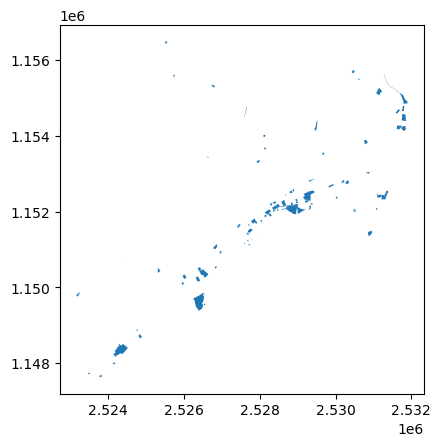

In [100]:
site_polluted.plot()

In [101]:
notes_module_func.columns

Index(['index', 'genre_entretien', 'groupe_entretien',
       'type_surface_entretien', 'buffer_dur', 'buffer_bat', 'buffer_bat_sout',
       'couv_s_design', 'batss_s_design', 'baths_s_design', 'dgav_geo_affect',
       'paf_type_princ', 'paf_type_sec', 'paf_denom_com', 'paf_igt',
       'paf_mixite', 'carto_prof_physiologique_txt',
       'carto_regime_hydrique_txt', 'carto_pierrosite_txt',
       'carto_texture_txt', 'carto_type_sol_txt',
       'carto_matiere_organique_txt', 'carto_degres_acidite_txt',
       'carto_roche_mere_sup_txt', 'viticol_fiche_unite',
       'viticol_roche_mere_txt', 'viticol_type_sol_txt',
       'viticol_prof_enracinement_txt', 'viticol_hydromorphie_txt',
       'viticol_variantes_locales_txt', 'csdur_s_genre_txt',
       'cseau_s_genre_txt', 'area', 'ndvi', 'revetement', 'geometry',
       'building_type', 'ndvi_batiment', 'aff_num', 'couche_chemin', 'id_n_1',
       'id_n_2', 'id_n_3', 'id_n_4', 'perm_note', 'perm_fiab',
       'perm_de_surf_comment_not

In [104]:
notes_module_func_pollue = notes_module_func.copy()

In [105]:
indices_to_update = []

for index, row in notes_module_func_pollue.iterrows():
    intersected = site_polluted['geometry'].intersects(row['geometry'])
    if intersected.any():
        indices_to_update.append(index)

notes_module_func_pollue.loc[indices_to_update, 'pollution_commentaire'] = 'attention cette zone intersecte un "site pollué" référez-vous à la loi et au cadastre des sites pollués avant toute action.'

print('done:', len(indices_to_update), 'rows updated')

done: 5554 rows updated


In [106]:
notes_module_func_pollue['pollution_commentaire'].unique()

array([nan,
       'attention cette zone intersecte un "site pollué" référez-vous à la loi et au cadastre des sites pollués avant toute action.'],
      dtype=object)

In [107]:
notes_module_func_pollue = notes_module_func_pollue.drop(columns=['pollution_note',
       'pollution_fiab', 'pollution_comment_note', 'pollution_comment_fiab'])

In [116]:
notes_module_func_pollue.to_postgis('notes_module_fonc_pollue_iqs2', engine, schema='arm_iqs', index = True, if_exists='replace')

#### note 

when adding the geopandas df to postgis database, sometimes the data type of the column changes from float to text, the reason is that there are None values in the column, and thus the column type changes to text for the whole column. the solution here is to convert all None values in the flaot type columns to NaN and then add the table to postgis. 

another reason can be inconsistency in the data, if there are both whole numbers and also floats, then postgis tries to convert all column's data type to text.


In [13]:
modulated['perm_note'].unique()

array(['1', '1.5', '1.0', '3.0', '2.0', '2.5', '4.0', '1.25', '5.0',
       '6.0', '1.95', '2.7', '1.8', '3.9', '5.4', '3.25', '1.35', '4.8',
       '1.3', '2.6', '1.6', '4.5', '6', '1.2', '2.4', '3.2', '2.25',
       '3.6', '5.2', '1.12', '1.62'], dtype=object)